# Import

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append("..")
import multi_axis as ma
from scipy.ndimage import zoom
import copy
from libertem.utils.generate import hologram_frame
import pandas as pd
import pywt

In [2]:
def plot_2d_mag(mx,my,mz=None,mesh_params=None,Ms=None,s=1, ax=None):
    """ Takes x/y magnetisation projections and creates a plot
        uses quivers for direction and colour for magnitude 
        if mz is None, coloured by magnitude of x/y, else coloured by z"""
    if type(Ms) == type(None):
        Ms = np.max(np.max((mx**2+my**2)**.5))
    
    if ax == None:
        fig = plt.figure(figsize=(4, 4))
        ax = plt.gca()
    #else:
        #fig = ax.gcf()

    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy = np.shape(mx)
        p2 = (sx,sy,sx)
        n = p2
    else:
        p1,p2,n = mesh_params
        
    x = np.linspace(p1[0],p2[0],num=n[0])
    y = np.linspace(p1[1],p2[1],num=n[1])
    xs,ys = np.meshgrid(x,y)
    
    ax.quiver(xs[::s,::s],ys[::s,::s],mx[::s,::s].T,my[::s,::s].T,pivot='mid',scale=Ms*15,width=0.009,headaxislength=5,headwidth=4,minshaft=1.8)
    if type(mz) == type(None):
        mag = (mx**2+my**2)**.5
    else:
        mag = mz
    ax.imshow(mag.T,origin='lower',extent=[p1[0],p2[0],p1[1],p2[1]],vmin=-Ms,vmax=Ms,cmap='RdBu')
#     cbar = plt.colorbar(fraction=0.046, pad=0.04)
#     if type(mz) ==type(None):
#         cbar.set_label('$|M_{\perp}$| / $A $', rotation=-270,fontsize=15)

#     else:
#         cbar.set_label('$M_z$', rotation=-270,fontsize=15)
    ax.set_xlabel('x / m',fontsize=15)
    ax.set_ylabel('y / m',fontsize=15)
    
def algorithm_test(path,mesh_params,BX,BY,BZ,MX=None,MY=None,MZ=None,phis=None,AX=None,AY=None,AZ=None, ntilts=[10], noises=[False],aranges=[90],nmajs=[5],threshes=[(.1,.7)], nmins=[20],multi=True,dual=True,n_pad=100, algorithms = ['SIRT3D_CUDA'],reg_weights=[0.001],noise_vals={'n':1,'fringe':20,'fxc':597,'fyc':566,'rc':50}):
    """ Tests the algorithm for a given M/B/A input over specified tilt,angle,nmaj,nmin ranges for dual/multi scheme 
        
        ntilts = Total number of images in tilt series
        aranges = maximum +ve tilt angle
        nmajs = number of major updates
        nmins = number of minor updates
        multi = test on multi-axis algorithm
        dual = test on dual-axis algorithm
        noises = add preset amount of noise to data
        threshes = 
        """
    # Initialise a dataframe with all the headings we want
    df = pd.DataFrame(columns=['tilt','a_range','noise','alg','reg_weight','tmin','tmax','nmaj','nmin','dual','multi','cod-mean','codx','cody','codz','ang_diff','mag_diff_mean','mag_diff_x','mag_diff_y','mag_diff_z'])
    
    # Loop over number of tilt images
    for tilt in ntilts:
        # Loop over angle ranges
        for a_range in aranges:
            # Generate dual axis dataset
            as_x,as_y,pxs,pys = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= tilt,a_range=a_range,n_pad=n_pad)
            
            for noise in noises:
                if noise ==True:
                    # pxs = ma.noisy_phase(pxs,noise_level=np.pi/4,maxshift=2)
                    # pys = ma.noisy_phase(pys,noise_level=np.pi/4,maxshift=2)
                    pxs = ma.noisy_phase(pxs,holo=True,n=noise_vals['n'],MX=MX,MY=MY,MZ=MZ,angles=as_x,mesh_params=mesh_params,n_pad=n_pad,fringe=noise_vals['fringe'],fxc=noise_vals['fxc'],fyc=noise_vals['fyc'],rc=noise_vals['rc'])
                    pys = ma.noisy_phase(pys,holo=True,n=noise_vals['n'],MX=MX,MY=MY,MZ=MZ,angles=as_y,mesh_params=mesh_params,n_pad=n_pad,fringe=noise_vals['fringe'],fxc=noise_vals['fxc'],fyc=noise_vals['fyc'],rc=noise_vals['rc'])


                bx_p,by_p = ma.dual_axis_B_generation(pxs,pys,mesh_params)
                angles = np.concatenate([as_x,as_y])
                phis = np.concatenate([pxs,pys],axis=1)
                
                for alg in algorithms:
                    for w in reg_weights:
                        # Loop over Major updates
                        for num, nmaj in enumerate(nmajs):
                            # Loop over minor updates
                            for nmin in nmins: 
                                # Calculate dual-axis result
                                if num == 0 and dual==True:
                                    b1,b2 = ma.dual_axis_reconstruction(bx_p,by_p ,as_x,as_y,mesh_params,niter=nmin,algorithm=alg,weight=w,callback_freq=0)
                                    b3 = ma.dual_axis_bz_from_bxby(b1,b2)

                                    codx = ma.COD(BX[n:-n,n:-n,n:-n],b1[n:-n,n:-n,n:-n])
                                    cody = ma.COD(BY[n:-n,n:-n,n:-n],b2[n:-n,n:-n,n:-n])
                                    codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3[n:-n,n:-n,n:-n])

                                    resd = [codx,cody,codz]

                                    # Save result
                                    cod_mean = np.mean(resd)
                                    ang_diff = angle_difference(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],
                                                             b1[n:-n,n:-n,n:-n],b2[n:-n,n:-n,n:-n],b3[n:-n,n:-n,n:-n])
                                    md_mean,md_x,md_y,md_z = mag_difference(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],
                                                             b1[n:-n,n:-n,n:-n],b2[n:-n,n:-n,n:-n],b3[n:-n,n:-n,n:-n])
                                    row = [tilt,a_range,noise,alg,w,0,0,nmaj,nmin,True,False,cod_mean,codx,cody,codz,ang_diff,md_mean,md_x,md_y,md_z]
                                    df.loc[0 if pd.isnull(df.index.max()) else df.index.max() + 1]=row
                                    df.to_pickle(path)
                                    print(df.loc[df.index.max():df.index.max()],'\n')

                                # Loop over threshold values
                                for ts in threshes:
                                    # Calculate multi-axis result
                                    if multi == True:
                                        try:
                                            t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=nmin,thresh_range=ts,algorithm=alg,weight=w)

                                            b1,b2,b3 = ma.calculate_B_from_A(t1,t2,t3,mesh_params=mesh_params)

                                            codx = ma.COD(BX[n:-n,n:-n,n:-n],b1[n:-n,n:-n,n:-n])
                                            cody = ma.COD(BY[n:-n,n:-n,n:-n],b2[n:-n,n:-n,n:-n])
                                            codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3[n:-n,n:-n,n:-n])

                                            res = [codx,cody,codz]
                                            cod_mean = np.mean(res)
                                            ang_diff = angle_difference(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],
                                                                     b1[n:-n,n:-n,n:-n],b2[n:-n,n:-n,n:-n],b3[n:-n,n:-n,n:-n])
                                            md_mean,md_x,md_y,md_z = mag_difference(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],
                                                                     b1[n:-n,n:-n,n:-n],b2[n:-n,n:-n,n:-n],b3[n:-n,n:-n,n:-n])
                                        except:
                                            cod_mean,codx,cody,codz,ang_diff,md_mean,md_x,md_y,md_z = np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
                                        tmin,tmax=ts
                                        row = [tilt,a_range,noise,alg,w,tmin,tmax,nmaj,nmin,False,True,cod_mean,codx,cody,codz,ang_diff,md_mean,md_x,md_y,md_z]
                                        df.loc[0 if pd.isnull(df.index.max()) else df.index.max() + 1]=row
                                        df.to_pickle(path)
                                        print(df.loc[df.index.max():df.index.max()],'\n')
                                
                                
def angle_difference(X1,Y1,Z1,X2,Y2,Z2,full_return=False):
    """ Calculates a.b / |a||b| i.e. looks at how aligned 
    phantom and recon are 
    
    Returns the average absolute value of this (1 is best!) """
    V1 = [X1.ravel(),Y1.ravel(),Z1.ravel()]
    V2 = [X2.ravel(),Y2.ravel(),Z2.ravel()]
    
    ang_diff = (V1[0]*V2[0]+V1[1]*V2[1]+V1[2]*V2[2])/((V1[0]**2+V1[1]**2+V1[2]**2)**.5*(V2[0]**2+V2[1]**2+V2[2]**2)**.5)
    ang_diff = np.reshape(ang_diff,np.shape(X1))
    
    # shift and rescale so that all -1 gives score of 0, 0 gives .5, 1 gives 1 
    ang_diff = (ang_diff +1)/2
    mean = np.mean(ang_diff)
    if full_return == True:
        return mean,ang_diff
    else:
        return mean
    
def mag_difference(X1,Y1,Z1,X2,Y2,Z2,full_return=False):
    """ Calculates the absolute difference in magnitude between points
    in the phantom and the recon, normalised by max value in phantom.
    
    Returns the average value of this difference (i.e. 0 best!)"""
    V1 = [X1.ravel(),Y1.ravel(),Z1.ravel()]
    V2 = [X2.ravel(),Y2.ravel(),Z2.ravel()]
    
    mag_diff = (abs((V1[0]**2+V1[1]**2+V1[2]**2)**.5 - (V2[0]**2+V2[1]**2+V2[2]**2)**.5)) / np.max(abs((V1[0]**2+V1[1]**2+V1[2]**2)**.5))
    mag_diff = np.reshape(mag_diff,np.shape(X1))
    
    mx = np.mean((abs((V1[0]**2)**.5 - (V2[0]**2)**.5)) / np.max(abs((V1[0]**2+V1[1]**2+V1[2]**2)**.5)))
    my = np.mean((abs((V1[1]**2)**.5 - (V2[1]**2)**.5)) / np.max(abs((V1[0]**2+V1[1]**2+V1[2]**2)**.5)))
    mz = np.mean((abs((V1[2]**2)**.5 - (V2[2]**2)**.5)) / np.max(abs((V1[0]**2+V1[1]**2+V1[2]**2)**.5)))

    
    mean = np.mean(mag_diff)
    if full_return == True:
        return mean,mx,my,mz,mag_diff
    else:
        return mean,mx,my,mz
    
def plot_test_results(fpath,x_axis='nmin',y_axis='cod-mean',series='tilt',const={'nmaj':10,'a_range':40,'tmin':0.1,'tmax':0.7,'noise':False,'alg':'SIRT3D_CUDA','reg_weight':0.001}, verbose=True,return_vals=False):
    """ Reads in pickled dataframe results from algorithm test and plots everything
    Choose what you want on x and y axes, then choose which variable will be plotted as multiple series,
    then choose the constant values to be used for the final 2 variables"""
    import matplotlib.font_manager
    import matplotlib
    # Set font and colormap for plotting
    font = {'family':'sans-serif','sans-serif':['Arial'],
            'size'   : 14}
    matplotlib.rc('font', **font)
    
    # read in dataframe with results
    df =pd.read_pickle(fpath)
    
    # extract the different parameter ranges used
    params=['tilt','a_range','nmaj','nmin','tmin','tmax','noise','alg','reg_weight']
    param_vals = {}
    
    for p in params:
        column_values = df[[p]]. values. ravel()
        unique_values = pd.unique(column_values)
        param_vals[p]=unique_values
        if p == 'tmin' or p =='tmax':
            if 0 in param_vals[p]:
                param_vals[p] = np.delete(param_vals[p], np.where(param_vals[p] == 0))
        
    keys = list(const.keys())
    nseries = len(param_vals[series])
    
    
    
    if verbose == True:
        for p in param_vals:
            print(p,param_vals[p])
    
    # Multi Axis plotting
    # extract all rows where column is specific value
    a = df.loc[df['dual'] == False]
    cm=0
    if len(a)>=1:
        # extract dataframe corresponding to specified constant values
        
        b = a.loc[a[keys[0]] == const[keys[0]]]
        d = b.loc[b[keys[1]] == const[keys[1]]]
        e = d.loc[d[keys[2]] == const[keys[2]]]
        f = e.loc[e[keys[3]] == const[keys[3]]]
        g = f.loc[f[keys[4]] == const[keys[4]]]
        h = g.loc[g[keys[5]] == const[keys[5]]]
        c = h.loc[h[keys[6]] == const[keys[6]]]
        
        cm = c
        
        cmap = matplotlib.cm.get_cmap('winter')
        for i,s in enumerate(param_vals[series]):
            # cycle through each value of s and plot each one as a series

            # extract final dataframe corresponding to series s
            d = c.loc[c[series] == s]
            
            #print(d)
            # extract the y-data from this dataframe (likely COD)
            yvals = d[y_axis]
            # plot the data
            col = cmap(i/nseries+1/(nseries)/2)
            try:
                plt.plot(param_vals[x_axis],yvals,'o-',label='M - %.3f'%s,color=col)
            except:
                try:
                    plt.plot(param_vals[x_axis],yvals,'o-',label='M - '+s,color=col)
                except:
                    yvals = np.unique(yvals)
                    plt.plot(param_vals[x_axis],yvals,'o-',label='M - %.3f'%s,color=col)
        
   
    # Dual Axis plotting
    a = df.loc[df['dual'] == True]
    cd = 0
    if len(a)>=1:
        # redefine tmin and tmax to 0 so it doesn't get confused
        const['tmin']=0
        const['tmax']=0
        
        # nmaj value defaults to 2 for dual data - override hyperparameter to ensure this
        # if 'nmaj' in const:
        #     const['nmaj']=2

        b = a.loc[a[keys[0]] == const[keys[0]]]
        d = b.loc[b[keys[1]] == const[keys[1]]]
        e = d.loc[d[keys[2]] == const[keys[2]]]
        f = e.loc[e[keys[3]] == const[keys[3]]]
        g = f.loc[f[keys[4]] == const[keys[4]]]
        h = g.loc[g[keys[5]] == const[keys[5]]]
        c = h.loc[h[keys[6]] == const[keys[6]]]
        cd=c
        cmap = matplotlib.cm.get_cmap('hot')
        if series != 'nmaj' and series != 'tmin' and series != 'tmax' :
            for i,s in enumerate(param_vals[series]):
                # cycle through each value of s and plot each one as a series

                # extract final dataframe corresponding to series s
                d = c.loc[c[series] == s]
                #print(d)
                # extract the y-data from this dataframe (likely COD)
                yvals = d[y_axis]
                # plot the data
                col = cmap(i/nseries+1/(nseries)/2)
                try:
                    plt.plot(param_vals[x_axis],yvals,'ro-',label='D - %.3f'%s,color=col)
                except:
                    try:
                        plt.plot(param_vals[x_axis],yvals,'ro-',label='D -'+s,color=col)
                    except:
                        print('Broken!',s) 
                        print(b)
                        print(param_vals[x_axis],yvals)
        else:
            yvals = c[y_axis]
            plt.plot(param_vals[x_axis],yvals,'ro-',label='D')
            
    plt.legend(title=series,loc=[1.02,.1])
    plt.xlabel(x_axis,fontsize=16)
    plt.ylabel(y_axis,fontsize=16)
    plt.title('%s = %.2f, %s = %.2f,%s = %.2f,\n%s = %.2f,%s = %.3f'%(keys[0], const[keys[0]],keys[1], const[keys[1]],keys[2], const[keys[2]],keys[3], const[keys[3]],keys[4], const[keys[4]]))
    
    
    col = df['cod-mean']
    max_val = col.max()
    max_i = col.idxmax()
    
    if verbose == True:
        print('\n Best result')
        print(df.loc[max_i:max_i],'\n')
        
    if return_vals==True:
        return cd,cm
    
def find_lim(X,Y,Z):
    """ Returns the biggest of abs(min) and max of magnitude of X,Y,Z """
    bmag = (X**2+Y**2+Z**2)**0.5
    bmax = np.max(bmag)
    bmin = np.min(bmag)
    blim = np.max([abs(bmax),abs(bmin)])
    
    bmag=np.max([X,Y,Z])
    bmin=np.min([X,Y,Z])
    
    return blim, bmax, bmin

def create_hopfion_data(tilt=10,a_range=70):
    """" Defaults to create 30x30 images """
    # Generate hopfion
    MX,MY,MZ = ma.Magnetic_Phantom.hopfion(bbox_length_px=100)
    # Crop out the blank space
    MX,MY,MZ = MX[20:-20,20:-20,20:-20],MY[20:-20,20:-20,20:-20],MZ[20:-20,20:-20,20:-20]
    # Reduce resolution to make the simulation smaller
    x=.66
    MXn=zoom(MX, (x,x,x))
    MYn=zoom(MY, (x,x,x))
    MZn=zoom(MZ, (x,x,x))
    MX,MY,MZ=MXn,MYn,MZn
    # Define mesh parameters
    p1 = (0,0,0)
    p2=(220*1e-9,220*1e-9,220*1e-9)
    n = 40
    n_pad=44
    mesh_params = (p1,p2,(n,n,n))

    # Calculate A and B
    AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=n_pad)
    BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params2)
    
    #n_pad=n
    as_x,as_y,pxs,pys = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= tilt,a_range=a_range,n_pad=n_pad)

    # add noise if desired
    # pxs = ma.noisy_phase(pxs,gaussian=True,noise_level=np.pi,lowpass=True)
    # pys = ma.noisy_phase(pys,gaussian=True,noise_level=np.pi,lowpass=True)

    angles_x = ma.generate_angles(mode='x',n_tilt=tilt,alpha=a_range)
    angles_y = ma.generate_angles(mode='y',n_tilt=tilt,beta=a_range,tilt2='beta')
    # pxs = ma.noisy_phase(pxs,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    # pys = ma.noisy_phase(pys,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    pxs = ma.noisy_phase(pxs,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=44,fxc=548,fyc=482,fringe=10,rc=50,n=0.1,v=.4,c=2000)
    pys = ma.noisy_phase(pys,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=44,fxc=548,fyc=482,fringe=10,rc=50,n=0.1,v=.4,c=2000)



    # Dual axis data
    bx_p,by_p = ma.dual_axis_B_generation(pxs,pys,mesh_params)

    # Multi axis data
    angles = np.concatenate([as_x,as_y])
    phis = np.concatenate([pxs,pys],axis=1)
    
    return phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ

def create_bubble_data(tilt=10,a_range=70):
    """" Defaults to create 30x30 images """
    name = r'FeGe_220x220x50nm_0B.npy'
    M = np.load(name)
    MX,MY,MZ = M[:,:,:,0],M[:,:,:,1],M[:,:,:,2]

    z=1#.38

    MX=zoom(MX, (z, z, 1))
    MY=zoom(MY, (z, z, 1))
    MZ=zoom(MZ, (z, z, 1))
    
    # mask = np.zeros_like(MX)
    # mask[10:30,10:30,10:30]=1
    # MX = MX*mask
    # MY = MY*mask
    # MZ = MZ*mask
    
    MX,MY,MZ = ma.rotate_magnetisation(MX,MY,MZ,0,0,45)

    h0= np.hanning(40)
    hann2d = np.sqrt(np.outer(h0,h0))

    for i in range(40):
        MX[:,:,i] = MX[:,:,i]*hann2d

    for i in range(40):
        MY[:,:,i] = MY[:,:,i]*hann2d

    for i in range(40):
        MZ[:,:,i] = MZ[:,:,i]*hann2d

    

    p1 = (0,0,0)
    p2=(220*1e-9,220*1e-9,50*1e-9)
    n = 40
    n_pad=44
    mesh_params = (p1,p2,(n,n,n))
    
    AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=n_pad)
    BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params2)

    #n_pad=n
    as_x,as_y,pxs,pys = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= tilt,a_range=a_range,n_pad=n_pad)

    # add noise if desired
    # pxs = ma.noisy_phase(pxs,gaussian=True,noise_level=np.pi,lowpass=True)
    # pys = ma.noisy_phase(pys,gaussian=True,noise_level=np.pi,lowpass=True)

    angles_x = ma.generate_angles(mode='x',n_tilt=tilt,alpha=a_range)
    angles_y = ma.generate_angles(mode='y',n_tilt=tilt,beta=a_range,tilt2='beta')
    # pxs = ma.noisy_phase(pxs,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    # pys = ma.noisy_phase(pys,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    pxs_n = ma.noisy_phase(pxs,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=44,fxc=576,fyc=529,fringe=10,rc=30,n=0.02,v=.9,c=2000)
    pys_n = ma.noisy_phase(pys,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=44,fxc=576,fyc=529,fringe=10,rc=30,n=0.02,v=.9,c=2000)



    # Dual axis data
    bx_p,by_p = ma.dual_axis_B_generation(pxs,pys,mesh_params)

    # Multi axis data
    angles = np.concatenate([as_x,as_y])
    phis = np.concatenate([pxs_n,pys_n],axis=1)
    
    return phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ

def create_sphere_data(tilt=10,a_range=70):
    """" Defaults to create 30x30 images """
    # Generate sphere
    MX,MY,MZ,_ = ma.Magnetic_Phantom.sphere(bbox_length_px=100,rad_m=15e-9)
    # Crop out the blank space
    MX,MY,MZ = MX[20:-20,20:-20,20:-20],MY[20:-20,20:-20,20:-20],MZ[20:-20,20:-20,20:-20]
    # Reduce resolution to make the simulation smaller
    x=.66
    MX=zoom(MX, (x,x,x))
    MY=zoom(MY, (x,x,x))
    MZ=zoom(MZ, (x,x,x))

    MX,MY,MZ = ma.rotate_magnetisation(MX,MY,MZ,30,50,20)

    # Define mesh parameters
    p1 = (0,0,0)
    p2=(100*1e-9,100*1e-9,100*1e-9)
    n = 40
    n_pad=44
    mesh_params = (p1,p2,(n,n,n))

    # Calculate A and B
    AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=n_pad)
    BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params2)
    
    #n_pad=n
    as_x,as_y,pxs,pys = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= tilt,a_range=a_range,n_pad=n_pad)

    # add noise if desired
    # pxs = ma.noisy_phase(pxs,gaussian=True,noise_level=np.pi,lowpass=True)
    # pys = ma.noisy_phase(pys,gaussian=True,noise_level=np.pi,lowpass=True)

    angles_x = ma.generate_angles(mode='x',n_tilt=tilt,alpha=a_range)
    angles_y = ma.generate_angles(mode='y',n_tilt=tilt,beta=a_range,tilt2='beta')
    # pxs = ma.noisy_phase(pxs,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    # pys = ma.noisy_phase(pys,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    pxs_n = ma.noisy_phase(pxs,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=44,fxc=576,fyc=529,fringe=10,rc=30,n=0.02,v=.7,c=2000)
    pys_n = ma.noisy_phase(pys,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=44,fxc=576,fyc=529,fringe=10,rc=30,n=0.02,v=.7,c=2000)



    # Dual axis data
    bx_p,by_p = ma.dual_axis_B_generation(pxs,pys,mesh_params)

    # Multi axis data
    angles = np.concatenate([as_x,as_y])
    phis = np.concatenate([pxs_n,pys_n],axis=1)
    
    return phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ


def create_hopfion_data_ideal(tilt=60,a_range=90):
    """" Defaults to create 30x30 images """
    # Generate hopfion
    MX,MY,MZ = ma.Magnetic_Phantom.hopfion(bbox_length_px=100)
    # Crop out the blank space
    MX,MY,MZ = MX[20:-20,20:-20,20:-20],MY[20:-20,20:-20,20:-20],MZ[20:-20,20:-20,20:-20]
    # Reduce resolution to make the simulation smaller
    x=.66
    MXn=zoom(MX, (x,x,x))
    MYn=zoom(MY, (x,x,x))
    MZn=zoom(MZ, (x,x,x))
    MX,MY,MZ=MXn,MYn,MZn
    # Define mesh parameters
    p1 = (0,0,0)
    p2=(220*1e-9,220*1e-9,220*1e-9)
    n = 40
    n_pad=44
    mesh_params = (p1,p2,(n,n,n))

    # Calculate A and B
    AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=n_pad)
    BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params2)
    
    #n_pad=n
    as_x,as_y,pxs,pys = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= tilt,a_range=a_range,n_pad=n_pad)

    # add noise if desired
    # pxs = ma.noisy_phase(pxs,gaussian=True,noise_level=np.pi,lowpass=True)
    # pys = ma.noisy_phase(pys,gaussian=True,noise_level=np.pi,lowpass=True)

    angles_x = ma.generate_angles(mode='x',n_tilt=tilt,alpha=a_range)
    angles_y = ma.generate_angles(mode='y',n_tilt=tilt,beta=a_range,tilt2='beta')
    # pxs = ma.noisy_phase(pxs,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    # pys = ma.noisy_phase(pys,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    # pxs = ma.noisy_phase(pxs,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=44,fxc=548,fyc=482,fringe=10,rc=50,n=0.1,v=.4,c=2000)
    # pys = ma.noisy_phase(pys,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=44,fxc=548,fyc=482,fringe=10,rc=50,n=0.1,v=.4,c=2000)



    # Dual axis data
    bx_p,by_p = ma.dual_axis_B_generation(pxs,pys,mesh_params)

    # Multi axis data
    angles = np.concatenate([as_x,as_y])
    phis = np.concatenate([pxs,pys],axis=1)
    
    return phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ

def create_bubble_data_ideal(tilt=60,a_range=90):
    """" Defaults to create 30x30 images """
    name = r'FeGe_220x220x50nm_0B.npy'
    M = np.load(name)
    MX,MY,MZ = M[:,:,:,0],M[:,:,:,1],M[:,:,:,2]

    z=1#.38

    MX=zoom(MX, (z, z, 1))
    MY=zoom(MY, (z, z, 1))
    MZ=zoom(MZ, (z, z, 1))
    
    #MY = -MY[::1,::-1,::1]
    
    MX,MY,MZ = ma.rotate_magnetisation(MX,MY,MZ,0,0,45)

    h0= np.hanning(40)
    hann2d = np.sqrt(np.outer(h0,h0))

    for i in range(40):
        MX[:,:,i] = MX[:,:,i]*hann2d

    for i in range(40):
        MY[:,:,i] = MY[:,:,i]*hann2d

    for i in range(40):
        MZ[:,:,i] = MZ[:,:,i]*hann2d
        
    

    p1 = (0,0,0)
    p2=(220*1e-9,220*1e-9,50*1e-9)
    n = 40
    n_pad=44
    mesh_params = (p1,p2,(n,n,n))
    
    AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=n_pad)
    BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params2)

    #n_pad=n
    as_x,as_y,pxs,pys = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= tilt,a_range=a_range,n_pad=n_pad)

    # add noise if desired
    # pxs = ma.noisy_phase(pxs,gaussian=True,noise_level=np.pi,lowpass=True)
    # pys = ma.noisy_phase(pys,gaussian=True,noise_level=np.pi,lowpass=True)

    angles_x = ma.generate_angles(mode='x',n_tilt=tilt,alpha=a_range)
    angles_y = ma.generate_angles(mode='y',n_tilt=tilt,beta=a_range,tilt2='beta')
    # pxs = ma.noisy_phase(pxs,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    # pys = ma.noisy_phase(pys,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    # pxs_n = ma.noisy_phase(pxs,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=44,fxc=576,fyc=529,fringe=10,rc=30,n=0.03,v=.95,c=2000)
    # pys_n = ma.noisy_phase(pys,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=44,fxc=576,fyc=529,fringe=10,rc=30,n=0.03,v=.95,c=2000)



    # Dual axis data
    bx_p,by_p = ma.dual_axis_B_generation(pxs,pys,mesh_params)

    # Multi axis data
    angles = np.concatenate([as_x,as_y])
    phis = np.concatenate([pxs,pys],axis=1)
    
    return phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ

def create_skyrmion_data(tilt=10,a_range=70):
    """" Defaults to create 30x30 images """
    name = r'skyrmion.npy'
    M = np.load(name)
    MX,MY,MZ = M[:,:,:,0],M[:,:,:,1],M[:,:,:,2]

    z=1#.38

    MX=zoom(MX, (z, z, 1))
    MY=zoom(MY, (z, z, 1))
    MZ=zoom(MZ, (z, z, 1))
    
    #MY = -MY[::1,::-1,::1]

    # h0= np.hanning(40)
    # hann2d = np.sqrt(np.outer(h0,h0))

    # for i in range(40):
    #     MX[:,:,i] = MX[:,:,i]*hann2d

    # for i in range(40):
    #     MY[:,:,i] = MY[:,:,i]*hann2d

    # for i in range(40):
    #     MZ[:,:,i] = MZ[:,:,i]*hann2d

    p1 = (0,0,0)
    p2=(220*1e-9,220*1e-9,50*1e-9)
    n = 40
    n_pad=44
    mesh_params = (p1,p2,(n,n,n))
    
    AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=n_pad)
    BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params2)

    #n_pad=n
    as_x,as_y,pxs,pys = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= tilt,a_range=a_range,n_pad=n_pad)

    # add noise if desired
    # pxs = ma.noisy_phase(pxs,gaussian=True,noise_level=np.pi,lowpass=True)
    # pys = ma.noisy_phase(pys,gaussian=True,noise_level=np.pi,lowpass=True)

    angles_x = ma.generate_angles(mode='x',n_tilt=tilt,alpha=a_range)
    angles_y = ma.generate_angles(mode='y',n_tilt=tilt,beta=a_range,tilt2='beta')
    # pxs = ma.noisy_phase(pxs,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    # pys = ma.noisy_phase(pys,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    pxs_n = ma.noisy_phase(pxs,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=44,fxc=576,fyc=529,fringe=10,rc=30,n=0.03,v=.95,c=2000)
    pys_n = ma.noisy_phase(pys,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=44,fxc=576,fyc=529,fringe=10,rc=30,n=0.03,v=.95,c=2000)



    # Dual axis data
    bx_p,by_p = ma.dual_axis_B_generation(pxs,pys,mesh_params)

    # Multi axis data
    angles = np.concatenate([as_x,as_y])
    phis = np.concatenate([pxs_n,pys_n],axis=1)
    
    return phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ

def create_sphere_data_ideal(tilt=60,a_range=90):
    """" Defaults to create 30x30 images """
    # Generate sphere
    MX,MY,MZ,_ = ma.Magnetic_Phantom.sphere(bbox_length_px=100,rad_m=15e-9)
    # Crop out the blank space
    MX,MY,MZ = MX[20:-20,20:-20,20:-20],MY[20:-20,20:-20,20:-20],MZ[20:-20,20:-20,20:-20]
    # Reduce resolution to make the simulation smaller
    x=.66
    MX=zoom(MX, (x,x,x))
    MY=zoom(MY, (x,x,x))
    MZ=zoom(MZ, (x,x,x))

    MX,MY,MZ = ma.rotate_magnetisation(MX,MY,MZ,30,50,20)

    # Define mesh parameters
    p1 = (0,0,0)
    p2=(100*1e-9,100*1e-9,100*1e-9)
    n = 40
    n_pad=44
    mesh_params = (p1,p2,(n,n,n))

    # Calculate A and B
    AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=n_pad)
    BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params2)
    
    #n_pad=n
    as_x,as_y,pxs,pys = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= tilt,a_range=a_range,n_pad=n_pad)

    # add noise if desired
    # pxs = ma.noisy_phase(pxs,gaussian=True,noise_level=np.pi,lowpass=True)
    # pys = ma.noisy_phase(pys,gaussian=True,noise_level=np.pi,lowpass=True)

    angles_x = ma.generate_angles(mode='x',n_tilt=tilt,alpha=a_range)
    angles_y = ma.generate_angles(mode='y',n_tilt=tilt,beta=a_range,tilt2='beta')
    # pxs = ma.noisy_phase(pxs,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    # pys = ma.noisy_phase(pys,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    # pxs_n = ma.noisy_phase(pxs,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=44,fxc=576,fyc=529,fringe=10,rc=30,n=0.02,v=.7,c=2000)
    # pys_n = ma.noisy_phase(pys,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=44,fxc=576,fyc=529,fringe=10,rc=30,n=0.02,v=.7,c=2000)



    # Dual axis data
    bx_p,by_p = ma.dual_axis_B_generation(pxs,pys,mesh_params)

    # Multi axis data
    angles = np.concatenate([as_x,as_y])
    phis = np.concatenate([pxs,pys],axis=1)
    
    return phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ

def test_run(phis,angles,mesh_params,n_pad,nmaj,nmin,weight,th1,th2):
    # Multi axis
    t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=nmin, 
                                           thresh_range=(th1,th2),algorithm='wavelet_coif1',weight=weight)
    b1m,b2m,b3m = ma.calculate_B_from_A(t1,t2,t3,mesh_params=mesh_params)

    # Dual axis
    cut=int(np.shape(phis)[1]/2)
    px = phis[:,:cut]
    py = phis[:,cut:]
    angx=angles[:cut]
    angy=angles[cut:]
    bx_p,by_p = ma.dual_axis_B_generation(px,py,mesh_params)
    b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,angx,angy,mesh_params,niter=nmin,algorithm='SIRT3D_CUDA',callback_freq=5)
    b3d = ma.dual_axis_bz_from_bxby(b1d,b2d)
    
    return b1m,b2m,b3m, b1d,b2d,b3d

def plot_test_run(BX,BY,BZ,b1m,b2m,b3m,b1d,b2d,b3d,i=20,n=44): 
    # Plot orthoslices of B with COD values
    i = 20
    blim,bmax,bmin = find_lim(BX,BY,BZ)

    ma.plot_component_orthoslices(BX,BY,BZ,npad=n,i=i,vmax=bmax,vmin=bmin)
    plt.title('Phantom B \n COD X, Y, Z (Mean)    ',fontsize=20)

    codx = ma.COD(BX[n:-n,n:-n,n:-n],b1m[n:-n,n:-n,n:-n])
    cody = ma.COD(BY[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n])
    codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n])
    ma.plot_component_orthoslices(b1m,b2m,b3m,npad=n,i=i,vmax=blim,vmin=-blim)
    plt.title('Unmixing algorithm \n %.2f, %.2f, %.2f (%.2f)' % (codx,cody,codz,np.mean([codx,cody,codz])),fontsize=20)

    codx = ma.COD(BX[n:-n,n:-n,n:-n],b1d[n:-n,n:-n,n:-n])
    cody = ma.COD(BY[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n])
    codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n])
    ma.plot_component_orthoslices(b1d,b2d,b3d,npad=n,i=i,vmax=blim,vmin=-blim)
    plt.title('Conventional algorithm \n %.2f, %.2f, %.2f (%.2f)' % (codx,cody,codz,np.mean([codx,cody,codz])),fontsize=20)

# Generate phantoms

In [ ]:
# Create realistic phantoms
phis_h, angles_h, BX_h,BY_h,BZ_h, mesh_params_h,MX_h,MY_h,MZ_h,AX_h,AY_h,AZ_h = create_hopfion_data()
phis_b, angles_b, BX_b,BY_b,BZ_b, mesh_params_b,MX_b,MY_b,MZ_b,AX_b,AY_b,AZ_b = create_bubble_data()
phis_s, angles_s, BX_s,BY_s,BZ_s, mesh_params_s,MX_s,MY_s,MZ_s,AX_s,AY_s,AZ_s = create_sphere_data()

In [ ]:
# Save realistic phantoms
fpath = r'Phantoms/hopfion_phantom.npy'
data = np.array([phis_h, angles_h, BX_h,BY_h,BZ_h, mesh_params_h,MX_h,MY_h,MZ_h,AX_h,AY_h,AZ_h],dtype=object)
np.save(fpath,data)

fpath = r'Phantoms/bubble_phantom.npy'
data = np.array([phis_b, angles_b, BX_b,BY_b,BZ_b, mesh_params_b,MX_b,MY_b,MZ_b,AX_b,AY_b,AZ_b],dtype=object)
np.save(fpath,data)

fpath = r'Phantoms/sphere_phantom.npy'
data = np.array([phis_s, angles_s, BX_s,BY_s,BZ_s, mesh_params_s,MX_s,MY_s,MZ_s,AX_s,AY_s,AZ_s],dtype=object)
np.save(fpath,data)

In [ ]:
# Create ideal phantoms
phis_hi, angles_hi, BX_hi,BY_hi,BZ_hi, mesh_params_hi,MX_hi,MY_hi,MZ_hi = create_hopfion_data_ideal(tilt=30)
phis_bi, angles_bi, BX_bi,BY_bi,BZ_bi, mesh_params_bi,MX_bi,MY_bi,MZ_bi = create_bubble_data_ideal(tilt=30)
phis_si, angles_si, BX_si,BY_si,BZ_si, mesh_params_si,MX_si,MY_si,MZ_si = create_sphere_data_ideal(tilt=30)

In [ ]:
# Save ideal phantoms
fpath = r'Phantoms/hopfion_phantom_ideal2.npy'
data = np.array([phis_hi, angles_hi, BX_hi,BY_hi,BZ_hi, mesh_params_hi,MX_hi,MY_hi,MZ_hi],dtype=object)
np.save(fpath,data)

fpath = r'Phantoms/bubble_phantom_ideal2.npy'
data = np.array([phis_bi, angles_bi, BX_bi,BY_bi,BZ_bi, mesh_params_bi,MX_bi,MY_bi,MZ_bi],dtype=object)
np.save(fpath,data)

fpath = r'Phantoms/sphere_phantom_ideal2.npy'
data = np.array([phis_si, angles_si, BX_si,BY_si,BZ_si, mesh_params_si,MX_si,MY_si,MZ_si],dtype=object)
np.save(fpath,data)

In [3]:
# Load real phantoms
[phis_h, angles_h, BX_h,BY_h,BZ_h, mesh_params_h,MX_h,MY_h,MZ_h,AX_h,AY_h,AZ_h ] = np.load(r'Phantoms/hopfion_phantom.npy',allow_pickle=True)
[phis_b, angles_b, BX_b,BY_b,BZ_b, mesh_params_b,MX_b,MY_b,MZ_b,AX_b,AY_b,AZ_b ] = np.load(r'Phantoms/bubble_phantom.npy',allow_pickle=True)
[phis_s, angles_s, BX_s,BY_s,BZ_s, mesh_params_s,MX_s,MY_s,MZ_s,AX_s,AY_s,AZ_s ] = np.load(r'Phantoms/sphere_phantom.npy',allow_pickle=True)

In [ ]:
# Load ideal phantoms
[phis_hi, angles_hi, BX_hi,BY_hi,BZ_hi, mesh_params_hi,MX_hi,MY_hi,MZ_hi] = np.load(r'Phantoms/hopfion_phantom_ideal.npy',allow_pickle=True)
[phis_bi, angles_bi, BX_bi,BY_bi,BZ_bi, mesh_params_bi,MX_bi,MY_bi,MZ_bi] = np.load(r'Phantoms/bubble_phantom_ideal.npy',allow_pickle=True)
[phis_si, angles_si, BX_si,BY_si,BZ_si, mesh_params_si,MX_si,MY_si,MZ_si ] = np.load(r'Phantoms/sphere_phantom_ideal.npy',allow_pickle=True)

In [ ]:
# Plot real to check
ma.plot_phases_interactive(phis_h,angles_h)
ma.plot_phases_interactive(phis_b,angles_b)
ma.plot_phases_interactive(phis_s,angles_s)

In [ ]:
# Plot ideal to check
ma.plot_phases_interactive(phis_hi,angles_hi)
ma.plot_phases_interactive(phis_bi,angles_bi)
ma.plot_phases_interactive(phis_si,angles_si)

# Plot phantoms

In [ ]:
# Load/define hopfion parameters
MX,MY,MZ,mesh_params = MX_h,MY_h,MZ_h,mesh_params_h
n_pad=44
fxc,fyc,fringe,rc,n,v,c = 548, 482, 10, 50, .1, .4, 2000

# Create phase images
a,_,p,_ = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= 2,a_range=0,n_pad=44)
pn = ma.noisy_phase(p,holo=True,MX=MX,MY=MY,MZ=MZ,angles=a,mesh_params=mesh_params,n_pad=44,fxc=fxc,fyc=fyc,fringe=fringe,rc=rc,n=n,v=v,c=c)

# Create holograms
aa=a[0]
phase_m = copy.deepcopy(p[:,0,:])
phase_tot = zoom(phase_m,(10,10))
MXr,MYr,MZr=ma.rotate_magnetisation(MX,MY,MZ,aa[0],aa[1],aa[2])
mag =(MXr**2+MYr**2+MZr**2)**.5 # magnitude of magnetisation
mag = mag/np.max(mag) # rescale so 1 is max
thickness = ma.project_along_z(mag,mesh_params=mesh_params) # project
thickness = np.pad(thickness,[(n_pad,n_pad),(n_pad,n_pad)],mode='edge')
amp = 1-thickness/np.max(thickness)/2
amp = zoom(amp,(10,10))
holo = hologram_frame(amp, phase_tot,sampling=fringe,visibility=v,poisson_noise=n,counts=c)
ref = hologram_frame(np.ones_like(phase_tot), np.zeros_like(phase_tot),sampling=fringe,visibility=v,poisson_noise=n)

In [ ]:
print(np.max(pn)-np.min(pn), 1/(np.mean(abs(abs(pn[44:-44,0,44:-44])-abs(pn[44:-44:,1,44:-44])))/np.pi), np.min(pn),np.max(pn))

In [ ]:
# Plot 
i = 19
n=44
f,axs = plt.subplots(nrows=4,figsize=(4,15))

plot_2d_mag(MX[:,:,i],MY[:,::1,i],MZ[:,:,i],s=2,ax=axs[0])
axs[1].imshow(p[n:-n,0,n:-n],cmap='gray')
n=44*10
axs[2].imshow(holo[n:-n,n:-n],cmap='gray')
n=44
axs[3].imshow(pn[n:-n,0,n:-n],cmap='gray')

for ax in axs:
    ax.axis('off')
f = plt.gcf()
f.patch.set_facecolor('white')
plt.tight_layout()

noise = pn-p
SNR = np.var(p)/np.var(noise)
print('SNR: ',SNR)

In [ ]:
MX,MY,MZ,mesh_params = MX_h,MY_h,MZ_h,mesh_params_h
n_pad=44
fxc,fyc,fringe,rc,n,v,c = 548, 482, 10, 50, .1, .4, 2000
# Create phase images
a,_,p,_ = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= 10,a_range=70,n_pad=44)
pn = ma.noisy_phase(p,holo=True,MX=MX,MY=MY,MZ=MZ,angles=a,mesh_params=mesh_params,n_pad=44,fxc=fxc,fyc=fyc,fringe=fringe,rc=rc,n=n,v=v,c=c)

noise = pn-p
SNR = np.var(p)/np.var(noise)
print('SNR: ',SNR)

In [ ]:
# Load/define stripe parameters
MX,MY,MZ,mesh_params = MX_b,MY_b,MZ_b,mesh_params_b
n_pad=44
fxc,fyc,fringe,rc,n,v,c = 576, 529, 10, 30, .02, .9, 2000
# Create phase images
a,_,p,_ = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= 2,a_range=0,n_pad=44)
pn = ma.noisy_phase(p,holo=True,MX=MX,MY=MY,MZ=MZ,angles=a,mesh_params=mesh_params,n_pad=44,fxc=fxc,fyc=fyc,fringe=fringe,rc=rc,n=n,v=v,c=c)

# Create holograms
aa=a[0]
phase_m = copy.deepcopy(p[:,0,:])
phase_tot = zoom(phase_m,(10,10))
MXr,MYr,MZr=ma.rotate_magnetisation(MX,MY,MZ,aa[0],aa[1],aa[2])
mag =(MXr**2+MYr**2+MZr**2)**.5 # magnitude of magnetisation
mag = mag/np.max(mag) # rescale so 1 is max
thickness = ma.project_along_z(mag,mesh_params=mesh_params) # project
thickness = np.pad(thickness,[(n_pad,n_pad),(n_pad,n_pad)],mode='edge')
amp = 1-thickness/np.max(thickness)/2
amp = zoom(amp,(10,10))
holo = hologram_frame(amp, phase_tot,sampling=fringe,visibility=v,poisson_noise=n,counts=c)
ref = hologram_frame(np.ones_like(phase_tot), np.zeros_like(phase_tot),sampling=fringe,visibility=v,poisson_noise=n)

In [ ]:
print(np.max(pn)-np.min(pn), 1/(np.mean(abs(abs(pn[44:-44,0,44:-44])-abs(pn[44:-44:,1,44:-44])))/np.pi), np.min(pn),np.max(pn))

In [ ]:
# Plot 
i = 20
n=44
f,axs = plt.subplots(nrows=4,figsize=(4,15))

plot_2d_mag(MX[:,:,i],MY[:,::1,i],MZ[:,:,i],s=2,ax=axs[0])
axs[1].imshow(p[n:-n,0,n:-n],cmap='gray')
n=44*10
axs[2].imshow(holo[n:-n,n:-n],cmap='gray')
n=44
axs[3].imshow(pn[n:-n,0,n:-n],cmap='gray')

for ax in axs:
    ax.axis('off')
f = plt.gcf()
f.patch.set_facecolor('white')
plt.tight_layout()

noise = pn-p
SNR = np.var(p)/np.var(noise)
print('SNR: ',SNR)

In [ ]:
MX,MY,MZ,mesh_params = MX_b,MY_b,MZ_b,mesh_params_b
n_pad=44
fxc,fyc,fringe,rc,n,v,c = 576, 529, 10, 30, .03, .95, 2000
# Create phase images
a,_,p,_ = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= 10,a_range=70,n_pad=44)
pn = ma.noisy_phase(p,holo=True,MX=MX,MY=MY,MZ=MZ,angles=a,mesh_params=mesh_params,n_pad=44,fxc=fxc,fyc=fyc,fringe=fringe,rc=rc,n=n,v=v,c=c)

noise = pn-p
SNR = np.var(p)/np.var(noise)
print('SNR: ',SNR)

In [ ]:
# Load/define sphere parameters
MX,MY,MZ,mesh_params = MX_s,MY_s,MZ_s,mesh_params_s
n_pad=44
fxc,fyc,fringe,rc,n,v,c = 576, 529, 10, 30, .02, .7, 2000

# Create phase images
a,_,p,_ = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= 2,a_range=0,n_pad=44)
pn = ma.noisy_phase(p,holo=True,MX=MX,MY=MY,MZ=MZ,angles=a,mesh_params=mesh_params,n_pad=44,fxc=fxc,fyc=fyc,fringe=fringe,rc=rc,n=n,v=v,c=c)

# Create holograms
aa=a[0]
phase_m = copy.deepcopy(p[:,0,:])
phase_tot = zoom(phase_m,(10,10))
MXr,MYr,MZr=ma.rotate_magnetisation(MX,MY,MZ,aa[0],aa[1],aa[2])
mag =(MXr**2+MYr**2+MZr**2)**.5 # magnitude of magnetisation
mag = mag/np.max(mag) # rescale so 1 is max
thickness = ma.project_along_z(mag,mesh_params=mesh_params) # project
thickness = np.pad(thickness,[(n_pad,n_pad),(n_pad,n_pad)],mode='edge')
amp = 1-thickness/np.max(thickness)/2
amp = zoom(amp,(10,10))
holo = hologram_frame(amp, phase_tot,sampling=fringe,visibility=v,poisson_noise=n,counts=c)
ref = hologram_frame(np.ones_like(phase_tot), np.zeros_like(phase_tot),sampling=fringe,visibility=v,poisson_noise=n)

In [ ]:
print(np.max(pn)-np.min(pn), 1/(np.mean(abs(abs(pn[44:-44,0,44:-44])-abs(pn[44:-44:,1,44:-44])))/np.pi), np.min(pn),np.max(pn))

In [ ]:
plt.imshow(pn[44:-44,0,44:-44],cmap='gray')
plt.colorbar()

In [ ]:
# Plot 
i = 20
n=44
f,axs = plt.subplots(nrows=4,figsize=(4,15))

plot_2d_mag(MX[:,:,i],MY[:,::1,i],MZ[:,:,i],s=2,ax=axs[0])
axs[1].imshow(p[n:-n,0,n:-n],cmap='gray')
n=44*10
axs[2].imshow(holo[n:-n,n:-n],cmap='gray')
n=44
axs[3].imshow(pn[n:-n,0,n:-n],cmap='gray')

for ax in axs:
    ax.axis('off')
f = plt.gcf()
f.patch.set_facecolor('white')
plt.tight_layout()

noise = pn-p
SNR = np.var(p)/np.var(noise)
print('SNR: ', SNR)

In [ ]:
MX,MY,MZ,mesh_params = MX_s,MY_s,MZ_s,mesh_params_s
n_pad=44
fxc,fyc,fringe,rc,n,v,c = 576, 529, 10, 30, .02, .7, 2000
# Create phase images
a,_,p,_ = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= 10,a_range=70,n_pad=44)
pn = ma.noisy_phase(p,holo=True,MX=MX,MY=MY,MZ=MZ,angles=a,mesh_params=mesh_params,n_pad=44,fxc=fxc,fyc=fyc,fringe=fringe,rc=rc,n=n,v=v,c=c)

noise = pn-p
SNR = np.var(p)/np.var(noise)
print('SNR: ',SNR)

# Test area

In [ ]:
def test_run(phis,angles,mesh_params,n_pad,nmaj,nmin,weight,th1,th2):
    # Multi axis
    t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=nmin, 
                                           thresh_range=(th1,th2),algorithm='wavelet_coif1',weight=weight)
    b1m,b2m,b3m = ma.calculate_B_from_A(t1,t2,t3,mesh_params=mesh_params)

    # Dual axis
    cut=int(np.shape(phis)[1]/2)
    px = phis[:,:cut]
    py = phis[:,cut:]
    angx=angles[:cut]
    angy=angles[cut:]
    bx_p,by_p = ma.dual_axis_B_generation(px,py,mesh_params)
    b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,angx,angy,mesh_params,niter=nmin,algorithm='SIRT3D_CUDA',callback_freq=5)
    b3d = ma.dual_axis_bz_from_bxby(b1d,b2d)
    
    return b1m,b2m,b3m, b1d,b2d,b3d

def plot_test_run(BX,BY,BZ,b1m,b2m,b3m,b1d,b2d,b3d,i=20,n=44): 
    # Plot orthoslices of B with COD values
    i = 20
    blim,bmax,bmin = find_lim(BX,BY,BZ)

    ma.plot_component_orthoslices(BX,BY,BZ,npad=n,i=i,vmax=bmax,vmin=bmin)
    plt.title('Phantom B \n COD X, Y, Z (Mean)    ',fontsize=20)

    codx = ma.COD(BX[n:-n,n:-n,n:-n],b1m[n:-n,n:-n,n:-n])
    cody = ma.COD(BY[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n])
    codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n])
    ma.plot_component_orthoslices(b1m,b2m,b3m,npad=n,i=i,vmax=blim,vmin=-blim)
    plt.title('Unmixing algorithm \n %.2f, %.2f, %.2f (%.2f)' % (codx,cody,codz,np.mean([codx,cody,codz])),fontsize=20)

    codx = ma.COD(BX[n:-n,n:-n,n:-n],b1d[n:-n,n:-n,n:-n])
    cody = ma.COD(BY[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n])
    codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n])
    ma.plot_component_orthoslices(b1d,b2d,b3d,npad=n,i=i,vmax=blim,vmin=-blim)
    plt.title('Conventional algorithm \n %.2f, %.2f, %.2f (%.2f)' % (codx,cody,codz,np.mean([codx,cody,codz])),fontsize=20)

..\multi_axis.py:2616: RuntimeWarning: divide by zero encountered in true_divide
  new_x = weight_phases(new_x,1/ws[:,0])
..\multi_axis.py:2619: RuntimeWarning: divide by zero encountered in true_divide
  new_y = weight_phases(new_y,1/ws[:,1])


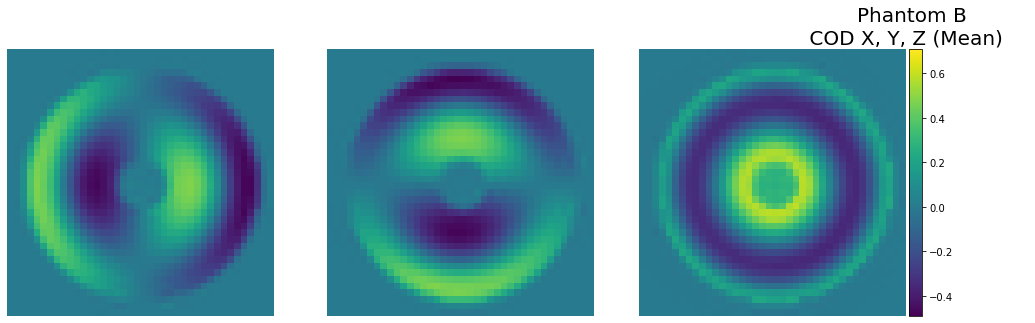

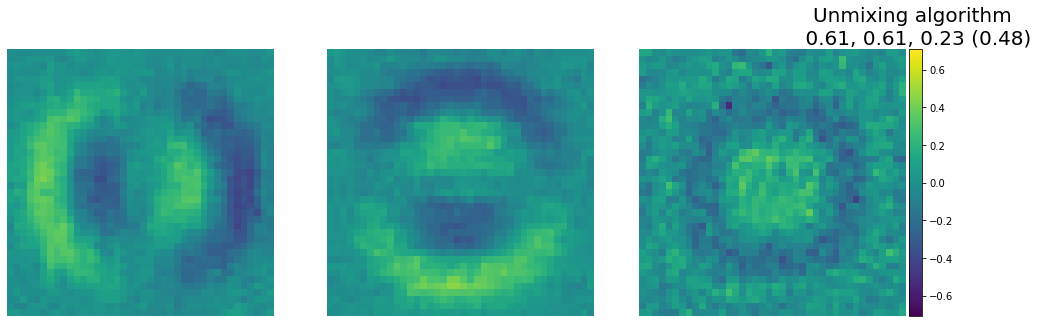

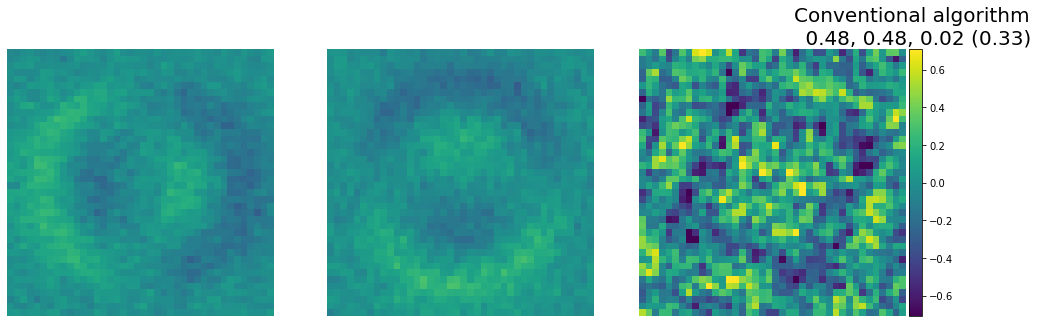

In [4]:
phis = phis_h
angles=angles_h
mesh_params = mesh_params_h

n_pad=44
nmaj=3
nmin=15
weight=2e-3
th1,th2=.2,.8
BX,BY,BZ=BX_h,BY_h,BZ_h

b1m,b2m,b3m, b1d,b2d,b3d = test_run(phis,angles,mesh_params,n_pad,nmaj,nmin,weight,th1,th2)
plot_test_run(BX,BY,BZ,b1m,b2m,b3m,b1d,b2d,b3d,i=20,n=44)

In [5]:
n=44
fpath = 'hopactual'
ma.save_B_to_paraview(fpath,BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n])

fpath = 'hopwrap'
ma.save_B_to_paraview(fpath,b1m[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n])

fpath = 'hopconv'
ma.save_B_to_paraview(fpath,b1d[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n])

In [ ]:
plot_test_run(BX,BY,BZ,b1m,b2m,b3m,b1d,b2d,b3d,i=20,n=44)

In [ ]:
phis = phis_b
angles=angles_b
mesh_params = mesh_params_b

n_pad=44
nmaj=3
nmin=5
weight=.9e-2
th1,th2=.01,.8
BX,BY,BZ=BX_b,BY_b,BZ_b

b1m,b2m,b3m, b1d,b2d,b3d = test_run(phis,angles,mesh_params,n_pad,nmaj,nmin,weight,th1,th2)


In [ ]:
plot_test_run(BX,BY,BZ,b1m,b2m,b3m,b1d,b2d,b3d,i=20,n=44)

In [ ]:
phis = phis_s
angles=angles_s
mesh_params = mesh_params_s

n_pad=44
nmaj=3
nmin=10
weight=3e-3
th1,th2=.2,.8
BX,BY,BZ=BX_s,BY_s,BZ_s

b1m,b2m,b3m, b1d,b2d,b3d = test_run(phis,angles,mesh_params,n_pad,nmaj,nmin,weight,th1,th2)


In [ ]:
plot_test_run(BX,BY,BZ,b1m,b2m,b3m,b1d,b2d,b3d,i=20,n=49)

# Iterations

In [ ]:
def test_iter(name,data,th1,th2,w,nmajs=[1,2,3,4,5,6,7,8,9,10],niters = [3,6,9,12,15,20,25,30,40,50,60,70],n=44):
    phis,angles,BX,BY,BZ,mesh_params = data
    n_pad=44
    res_m = []
    res_m2 = []
    all_m = []
    all_m2 = []
    all_m3 = []
    nmajs=[1,2,3,4,5,6,7,8,9,10]
    niters = [3,6,9,12,15,20,25,30,40,50,60,70]
    for nmaj in nmajs:
        res_m = []
        res_m2 = []
        res_m3 = []
        for ni in niters:
            t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=ni, 
                                           thresh_range=(th1,th2),algorithm='wavelet_sym2',weight=w)
            b1m,b2m,b3m = ma.calculate_B_from_A(t1,t2,t3,mesh_params=mesh_params)

            codx = ma.COD(BX[n:-n,n:-n,n:-n],b1m[n:-n,n:-n,n:-n])
            cody = ma.COD(BY[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n])
            codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n])
            res_m.append([codx,cody,codz])

            ang_diff = angle_difference(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],
                                                                     b1m[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n])

            res_m2.append(ang_diff)
            
            magdif = mag_difference(BX,BY,BZ,b1m,b2m,b3m)

            print([codx,cody,codz])

        all_m.append(res_m)
        all_m2.append(res_m2)
        magdif = mag_difference(BX,BY,BZ,b1m,b2m,b3m)
        
        
        np.save('Data/iterations_'+name+'_cod_multi.npy',all_m)
        np.save('Data/iterations_'+name+'_ang_multi.npy',all_m2)
        
    res_d = []
    res_d2 = []
    
    cut=int(np.shape(phis)[1]/2)
    px = phis[:,:cut]
    py = phis[:,cut:]
    angx=angles[:cut]
    angy=angles[cut:]
    bx_p,by_p = ma.dual_axis_B_generation(px,py,mesh_params)
    
    for ni in niters:
        b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,angx,angy,mesh_params,niter=ni,algorithm='SIRT3D_CUDA',callback_freq=5)
        b3d = ma.dual_axis_bz_from_bxby(b1d,b2d)

        codx = ma.COD(BX[n:-n,n:-n,n:-n],b1d[n:-n,n:-n,n:-n])
        cody = ma.COD(BY[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n])
        codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n])
        res_d.append([codx,cody,codz])

        ang_diff = angle_difference(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],
                                                                 b1d[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n])

        res_d2.append(ang_diff)
        print(mag_difference(BX,BY,BZ,b1d,b2d,b3d))
        np.save('Data/iterations_'+name+'_cod_dual.npy',res_d)
        np.save('Data/iterations_'+name+'_ang_dual.npy',res_d2)

In [ ]:
# real tests
# data = phis_h, angles_h, BX_h,BY_h,BZ_h, mesh_params_h
# th1,th2,w = .2,.8,5e-3
# test_iter('hop_real',data,th1,th2,w)

# data = phis_s, angles_s, BX_s,BY_s,BZ_s, mesh_params_s
# th1,th2,w = .2,.8,3e-3
# test_iter('sph_real',data,th1,th2,w)

data = phis_b, angles_b, BX_b,BY_b,BZ_b, mesh_params_b
th1,th2,w = .01,.85,.9e-2
test_iter('bub_real',data,th1,th2,w)

# ideal tests
# data = phis_hi, angles_hi, BX_hi,BY_hi,BZ_hi, mesh_params_hi
# th1,th2,w = .05,.85,0
# test_iter('hop_ideal',data,th1,th2,w,n=48)

# data = phis_si, angles_si, BX_si,BY_si,BZ_si, mesh_params_si
# th1,th2,w = .05,.85,0
# test_iter('sph_ideal',data,th1,th2,w,n=50)

# data = phis_bi, angles_bi, BX_bi,BY_bi,BZ_bi, mesh_params_bi
# th1,th2,w = .05,.85,0
# test_iter('bub_ideal',data,th1,th2,w,n=52)

In [ ]:
res_d = np.load('Data/iterations_sph_real_cod_dual.npy')
all_m = np.load('Data/iterations_sph_real_cod_multi.npy')

# res_d = np.load('Data/iterations_hop_real_cod_dual.npy')
# all_m = np.load('Data/iterations_hop_real_cod_multi.npy')

# res_d = np.load('Data/iterations_bub_real_cod_dual.npy')
# all_m = np.load('Data/iterations_bub_real_cod_multi.npy')

niters = [3,6,9,12,15,20,25,30,40,50,60,70]
nmajs=[1,2,3,4,5,6,7,8,9,10]

In [ ]:
import matplotlib.font_manager
import matplotlib as mpl
# Set font and colormap for plotting
# font = {'family':'serif',
#         'size'   : 12}

font = {'family':'sans-serif','sans-serif':'Arial',
        'size'   : 13}
matplotlib.rc('font', **font)
    

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# twin object for two different y-axis on the sample plot
#ax2=ax.twinx()

# make a plot
ax.plot(niters,np.mean(res_d,axis=1),'o-',color='coral')
#ax2.plot(niters,res_d2,'o--',color='coral',markerfacecolor='w')

#cmap = matplotlib.cm.get_cmap('BuGn')
cmap = mpl.cm.Greens(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[8:,:-1])

for i in range(len(nmajs)):
    col = cmap(i/6)
    ax.plot(niters,np.mean(all_m[i],axis=1),'o-',color=col)
    # set x-axis label
    ax.set_xlabel("$n_{min}$",fontsize=14)
    # set y-axis label
    ax.set_ylabel("Mean $R^2(B_{0},B_{r})$",fontsize=14)

    # make a plot with different y-axis using second axis object
    #ax2.plot(niters,all_m2[i],'o--',color=col,markerfacecolor='w')
    
    #ax2.set_ylabel("Mean $\cos\\theta$ ",fontsize=14)


plt.show()

In [ ]:
res_d = np.load('Data/iterations_sph_ideal_cod_dual.npy')
all_m = np.load('Data/iterations_sph_ideal_cod_multi.npy')

# res_d = np.load('Data/iterations_bub_ideal_cod_dual.npy')
# all_m = np.load('Data/iterations_bub_ideal_cod_multi.npy')

# res_d = np.load('Data/iterations_hop_ideal_cod_dual.npy')
# all_m = np.load('Data/iterations_hop_ideal_cod_multi.npy')

niters = [3,6,9,12,15,20,25,30,40,50,60,70]

In [ ]:
import matplotlib.font_manager
import matplotlib as mpl
# Set font and colormap for plotting
# font = {'family':'serif',
#         'size'   : 12}

font = {'family':'sans-serif','sans-serif':'Arial',
        'size'   : 13}
matplotlib.rc('font', **font)
    

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# twin object for two different y-axis on the sample plot
#ax2=ax.twinx()

# make a plot
ax.plot(niters,np.mean(res_d,axis=1),'o-',color='coral')
#ax2.plot(niters,res_d2,'o--',color='coral',markerfacecolor='w')

#cmap = matplotlib.cm.get_cmap('BuGn')
cmap = mpl.cm.Greens(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[8:,:-1])

for i in range(len(nmajs)):
    col = cmap(i/6)
    ax.plot(niters,np.mean(all_m[i],axis=1),'o-',color=col)
    # set x-axis label
    ax.set_xlabel("$n_{min}$",fontsize=14)
    # set y-axis label
    ax.set_ylabel("Mean $R^2(B_{0},B_{r})$",fontsize=14)

    # make a plot with different y-axis using second axis object
    #ax2.plot(niters,all_m2[i],'o--',color=col,markerfacecolor='w')
    
    #ax2.set_ylabel("Mean $\cos\\theta$ ",fontsize=14)


plt.show()

In [ ]:
# Generate colorbar
cmap = mpl.cm.Greens_r(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[0:-5,:-1])
cols=[]
for i in range(len(nmajs)):
    col = cmap(i/10)
    cols.append(col)

cmap2=mpl.colors.ListedColormap(cols)
c = plt.pcolor([(1,2),(1,2)], edgecolors='k', linewidths=4, cmap=cmap2, vmin=0.0, vmax=1.0)
cbar = plt.colorbar(c)
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=-90,fontsize=15)
cbar.set_ticks(np.arange(0,1,1/10)+0.05)
cbar.set_ticklabels([10,9,8,7,6,5,4,3,2,1])

plt.show()

In [ ]:
plt.plot(1,1,'g-',label='WRAP',color='g')
plt.plot(1,1,'--',label='Conventional',color='coral')
plt.legend(fontsize=16,fancybox=True)

In [ ]:
res_ds = np.load('Data/iterations_sph_real_cod_dual.npy')
all_ms = np.load('Data/iterations_sph_real_cod_multi.npy')

res_dh = np.load('Data/iterations_hop_real_cod_dual.npy')
all_mh = np.load('Data/iterations_hop_real_cod_multi.npy')

res_db = np.load('Data/iterations_bub_real_cod_dual.npy')
all_mb = np.load('Data/iterations_bub_real_cod_multi.npy')

res_dsi = np.load('Data/iterations_sph_ideal_cod_dual.npy')
all_msi = np.load('Data/iterations_sph_ideal_cod_multi.npy')

res_dbi = np.load('Data/iterations_bub_ideal_cod_dual.npy')
all_mbi = np.load('Data/iterations_bub_ideal_cod_multi.npy')

res_dhi = np.load('Data/iterations_hop_ideal_cod_dual.npy')
all_mhi = np.load('Data/iterations_hop_ideal_cod_multi.npy')

In [ ]:
import matplotlib.font_manager
import matplotlib as mpl

# create figure and axis objects with subplots()
font = {'family':'sans-serif','sans-serif':'Arial',
        'size'   : 13}
matplotlib.rc('font', **font)
cmap = mpl.cm.Greens(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[8:,:-1])
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(10,5))


##### Hopfion ideal
axs[0].plot(niters,np.mean(res_dhi,axis=1),'o--',color='coral',markerfacecolor='w')

for i in range(len(nmajs)):
    col = cmap(i/10)
    axs[0].plot(niters,np.mean(all_mhi[i],axis=1),'o-',color=col,markerfacecolor='w')
#    axs[0].set_xlabel("$n_{min}$",fontsize=14)
#    axs[0].set_ylabel("Mean $R^2(B_{0},B_{r})$",fontsize=14)
    
# hopfion real
axs[0].plot(niters,np.mean(res_dh,axis=1),'o--',color='coral',markerfacecolor='w')

for i in range(len(nmajs)):
    col = cmap(i/10)
    axs[0].plot(niters,np.mean(all_mh[i],axis=1),'o-',color=col,markerfacecolor='w')
#    axs[0].set_xlabel("$n_{min}$",fontsize=14)
    axs[0].set_ylabel("Mean $R^2(B_{0},B_{r})$",fontsize=16)

axs[0].fill_between([-3,75],[.6,.6],[1.1,1.1],color='grey',alpha=.2)

##### bub ideal
axs[1].plot(niters,np.mean(res_dbi,axis=1),'s--',color='coral')

for i in range(len(nmajs)):
    col = cmap(i/10)
    axs[1].plot(niters,np.mean(all_mbi[i],axis=1),'s-',color=col)
#    axs[1].set_xlabel("$n_{min}$",fontsize=14)
    
# bub real
axs[1].plot(niters,np.mean(res_db,axis=1),'s--',color='coral')

for i in range(len(nmajs)):
    col = cmap(i/10)
    axs[1].plot(niters,np.mean(all_mb[i],axis=1),'s-',color=col)
    axs[1].set_xlabel("$n_{min}$",fontsize=16)

axs[1].fill_between([-3,75],[.7,.7],[1.1,1.1],color='grey',alpha=.2)

##### sph ideal
axs[2].plot(niters,np.mean(res_dsi,axis=1),'o--',color='coral')

for i in range(len(nmajs)):
    col = cmap(i/10)
    axs[2].plot(niters,np.mean(all_msi[i],axis=1),'o-',color=col)
#    axs[2].set_xlabel("$n_{min}$",fontsize=14)
    
# sph real
axs[2].plot(niters,np.mean(res_ds,axis=1),'o--',color='coral')

for i in range(len(nmajs)):
    col = cmap(i/10)
    axs[2].plot(niters,np.mean(all_ms[i],axis=1),'o-',color=col)
#    axs[2].set_xlabel("$n_{min}$",fontsize=14)

axs[2].fill_between([-3,75],[.78,.78],[1.1,1.1],color='grey',alpha=.2)
    
    
# Final formatting
for ax in axs:
    ax.set_ylim([.26,1.02])
    ax.set_xlim([-2,74])
    
for ax in axs[1:]:
    ax.set_yticklabels([])


plt.tight_layout()
plt.show()

# Thresholding

In [ ]:
def test_threshold(name,data, nmin,weight):
    phis,angles,BX,BY,BZ,mesh_params = data
    n_pad=44
    n=44
    nmaj=3

    # Dual axis
    px = phis[:,:10]
    py = phis[:,10:]
    angx=angles[:10]
    angy=angles[10:]
    bx_p,by_p = ma.dual_axis_B_generation(px,py,mesh_params)
    b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,angx,angy,mesh_params,niter=nmin,algorithm='SIRT3D_CUDA',callback_freq=5)
    b3d = ma.dual_axis_bz_from_bxby(b1d,b2d)
    codx = ma.COD(BX[n:-n,n:-n,n:-n],b1d[n:-n,n:-n,n:-n])
    cody = ma.COD(BY[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n])
    codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n])

    cod = np.mean([codx,cody,codz])
    np.save('Data/thresh_'+name+'_dual.npy',cod)

    res = []
    ts = [0.01,.1,.2,.3,.4,.5,.6,.7,.8]
    for t in ts:
        # Multi axis
        t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=nmin, 
                                               thresh_range=(t,.8),algorithm='wavelet_sym2',weight=weight)
        b1m,b2m,b3m = ma.calculate_B_from_A(t1,t2,t3,mesh_params=mesh_params)

        n=n_pad
        codx = ma.COD(BX[n:-n,n:-n,n:-n],b1m[n:-n,n:-n,n:-n])
        cody = ma.COD(BY[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n])
        codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n])

        cod = np.mean([codx,cody,codz])
        res.append(cod)

    np.save('Data/thresh_'+name+'_multi.npy',res)

In [ ]:
# real tests
# data = phis_h, angles_h, BX_h,BY_h,BZ_h, mesh_params_h
# nmin,w = 28,5e-3
# test_threshold('h',data,nmin,w)

# data = phis_s, angles_s, BX_s,BY_s,BZ_s, mesh_params_s
# nmin,w = 18,3e-3
# test_threshold('s',data,nmin,w)

data = phis_b, angles_b, BX_b,BY_b,BZ_b, mesh_params_b
nmin,w = 20,.9e-2
test_threshold('b',data,nmin,w)

In [ ]:
ts = [0.01,.1,.2,.3,.4,.5,.6,.7,.8]

res_s = np.load(r'Data/thresh_s_multi.npy')
res_h = np.load(r'Data/thresh_h_multi.npy')
res_b = np.load(r'Data/thresh_b_multi.npy')
d_s = np.load(r'Data/thresh_s_dual.npy')
d_h=np.load(r'Data/thresh_h_dual.npy')
d_b = np.load(r'Data/thresh_b_dual.npy')

In [ ]:
s_norm = res_s-d_s
h_norm = res_h-d_h
b_norm = res_b-d_b

In [ ]:
import matplotlib
# font = {'sans-serif' :'Ariel',
#         'size'   : 14}
# matplotlib.rc('font', **font)

import matplotlib
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Ariel"

plt.plot(ts,s_norm,'-o',color='b')
plt.plot(ts,b_norm,'-s',color='r')
plt.plot(ts,h_norm,'-o',c='g',markerfacecolor='w')




# res_m = np.mean([b_norm,h_norm,s_norm],axis=0)
# plt.plot(ts, res_m,'-',color=r'forestgreen',lw=2.5)

# e = np.std([b_norm,h_norm,s_norm],axis=0)
# plt.fill_between(ts,res_m-e,res_m+e,color=r'forestgreen',alpha=.2)

# d_m = np.mean([d_b,d_s,d_h])
# e = np.std([d_b,d_s,d_h])
# plt.plot((0.01,.9),(d_b,d_b),'--',color='orange')
# plt.fill_between((0.01,.9),(d_b-e,d_b-e),(d_b+e,d_b+e),color='orange',alpha=.2)

plt.xlabel('Final threshold $t$',fontsize=16)
plt.ylabel('$\Delta$ $R^2(B_{0},B_{r}$)',fontsize=16)

plt.plot((0,.8),(0,0),'--',color='grey')

labels = ['+ 0.0', '+ 0.1','+ 0.2','+ 0.3','+ 0.4']
y = [0,.1,.2,.3,.4]
plt.yticks(y, labels)

f = plt.gcf()
f.patch.set_facecolor('white')
plt.legend(['Sphere','Stripe','Hopfion'],fontsize=12,loc='lower right',framealpha=.5)

In [ ]:
angles = ([0,0,90],[0,90,0],[90,0,0])
ws = ma.calculate_A_contributions(angles)

# plot a collection scheme
%matplotlib inline
fig = plt.figure(figsize=(6,6))
ax1 = fig.gca(projection='3d')

# AXES
bs = []
for i,a in enumerate(angles):
    mrot = ma.rotation_matrix(a[0],a[1],a[2])
    b = np.dot(mrot,[0,0,1.5])
    bs.append(b)
    cmap='winter_r'#'twilight_shifted'#'Wistia'#'autumn_r' #'winter_r'
    marker='o'#'x'#'|'#'_'
    t=0.6
    plt.plot([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],'-',color='k',alpha=.2)
    ax1.scatter([b[0]],[b[1]],[b[2]],c='k',s=30,alpha=1,marker='.')
    
    
# CONE
h=.7
t=.6
theta = np.arccos(t)*360/(2*np.pi)
x = 1/np.tan(np.deg2rad(theta))
rval=h/x
theta = np.linspace(0, 2*np.pi, 200)
r = np.linspace(0, rval, 200)
t,R =np.meshgrid(theta, r)

X = R*np.cos(t)
Y = R*np.sin(t)
Z = R*x

ax1.plot_surface(X, Y, Z,alpha=0.6, cmap='Greys_r',vmax=.9,zorder=1)
ax1.plot_surface(X, Y, -Z,alpha=.6, cmap='Greys',vmin=-.9,zorder=1)



# POINTS
angles = ma.generate_angles(mode='dual',n_tilt=30,alpha=70,beta=70,tilt2='beta')
ws = ma.calculate_A_contributions(angles)
bs = []
for i,a in enumerate(angles):
    mrot = ma.rotation_matrix(a[0],a[1],a[2])
    b = np.dot(mrot,[0,0,1])
    bs.append(b)
    #cmap='coolwarm'#'twilight_shifted'#'Wistia'#'autumn_r' #'winter_r'
    marker='o'#'x'#'|'#'_'
    t=0.6
    if abs(ws[i,2]) > t: #or abs(ws[i,1]) > t or abs(ws[i,2]) > t:
        plt.plot([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],'-',color='k',alpha=.2)
        #ax1.scatter([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],c=[-b[2],b[2]],s=25,cmap='twilight_shifted',alpha=1,marker=marker)
        ax1.scatter([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],s=25,c='blue',alpha=1,marker=marker,zorder=500)
    else:
        plt.plot([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],'-',color='k',alpha=.2)
        #ax1.scatter([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],c=[-b[2],b[2]],s=25,cmap='winter_r',alpha=1,marker=marker,vmax=.8)
        ax1.scatter([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],s=25,c='red',alpha=.5,marker=marker,zorder=500)




    
    
    
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.set_zticklabels([])
plt.xlabel('x',fontsize='20')
plt.ylabel('y',fontsize='20')
ax1.set_zlabel('z',fontsize='20')
plt.xlim([-1,1])
plt.ylim([-1,1])
ax1.set_zlim([-1,1])
plt.axis('off')

ax1.azim = -60
ax1.dist = 10
ax1.elev = 20


f = plt.gcf()
f.patch.set_facecolor('white')

# Regularisation

In [ ]:
def test_reg(name,data, nmin,th1,th2):
    phis,angles,BX,BY,BZ,mesh_params = data
    n_pad=44
    n=44
    nmaj=3

    # Dual axis
    px = phis[:,:10]
    py = phis[:,10:]
    angx=angles[:10]
    angy=angles[10:]
    bx_p,by_p = ma.dual_axis_B_generation(px,py,mesh_params)
    b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,angx,angy,mesh_params,niter=nmin,algorithm='SIRT3D_CUDA',callback_freq=5)
    b3d = ma.dual_axis_bz_from_bxby(b1d,b2d)
    codx = ma.COD(BX[n:-n,n:-n,n:-n],b1d[n:-n,n:-n,n:-n])
    cody = ma.COD(BY[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n])
    codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n])

    cod = np.mean([codx,cody,codz])
    np.save('Data/regco_'+name+'_dual.npy',cod)

    res = []
    weights  = np.logspace(-4,-1,30)
    for w in weights:
        # Multi axis
        t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=nmin, 
                                               thresh_range=(th1,th2),algorithm='wavelet_coif1',weight=w)
        b1m,b2m,b3m = ma.calculate_B_from_A(t1,t2,t3,mesh_params=mesh_params)

        n=n_pad
        codx = ma.COD(BX[n:-n,n:-n,n:-n],b1m[n:-n,n:-n,n:-n])
        cody = ma.COD(BY[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n])
        codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n])

        cod = np.mean([codx,cody,codz])
        res.append(cod)

    np.save('Data/regco_'+name+'_multi.npy',res)
    
def test_reg_comp(name,data, nmin,th1,th2):
    phis,angles,BX,BY,BZ,mesh_params = data
    n_pad=44
    n=44
    nmaj=3

    # Dual axis
    px = phis[:,:10]
    py = phis[:,10:]
    angx=angles[:10]
    angy=angles[10:]
    bx_p,by_p = ma.dual_axis_B_generation(px,py,mesh_params)
    b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,angx,angy,mesh_params,niter=nmin,algorithm='SIRT3D_CUDA',callback_freq=5)
    b3d = ma.dual_axis_bz_from_bxby(b1d,b2d)
    codx = ma.COD(BX[n:-n,n:-n,n:-n],b1d[n:-n,n:-n,n:-n])
    cody = ma.COD(BY[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n])
    codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n])

    cod = [codx,cody,codz]
    np.save('Data/regcomp_'+name+'_dual.npy',cod)

    res = []
    weights  = np.logspace(-4,-1,30)
    for w in weights:
        # Multi axis
        t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=nmin, 
                                               thresh_range=(th1,th2),algorithm='wavelet_coif1',weight=w)
        b1m,b2m,b3m = ma.calculate_B_from_A(t1,t2,t3,mesh_params=mesh_params)

        n=n_pad
        codx = ma.COD(BX[n:-n,n:-n,n:-n],b1m[n:-n,n:-n,n:-n])
        cody = ma.COD(BY[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n])
        codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n])

        cod = [codx,cody,codz]
        res.append(cod)

    np.save('Data/regcomp_'+name+'_multi.npy',res)

In [ ]:
# real tests
# data = phis_h, angles_h, BX_h,BY_h,BZ_h, mesh_params_h
# nmin = 15
# th1=.2
# test_reg('h',data,nmin,th1,.8)

# data = phis_b, angles_b, BX_b,BY_b,BZ_b, mesh_params_b
# nmin = 5
# th1=0.01
# test_reg('b',data,nmin,th1,.8)

# data = phis_s, angles_s, BX_s,BY_s,BZ_s, mesh_params_s
# nmin = 10
# th1=0.2
# test_reg('s',data,nmin,th1,.8)

In [ ]:
res_h = np.load('Data/reg_h_multi.npy')
res_b = np.load('Data/reg_b_multi.npy')
res_s = np.load('Data/reg_s_multi.npy')

res_hd = np.load('Data/reg_h_dual.npy')
res_bd = np.load('Data/reg_b_dual.npy')
res_sd = np.load('Data/reg_s_dual.npy')

dif_h = res_h-res_hd
dif_b = res_b-res_bd
dif_s = res_s-res_sd

In [ ]:
res_h = np.load('Data/regco_h_multi.npy')
res_b = np.load('Data/regco_b_multi.npy')
res_s = np.load('Data/regco_s_multi.npy')

res_hd = np.load('Data/regco_h_dual.npy')
res_bd = np.load('Data/regco_b_dual.npy')
res_sd = np.load('Data/regco_s_dual.npy')

dif_h = res_h-res_hd
dif_b = res_b-res_bd
dif_s = res_s-res_sd

In [ ]:
import matplotlib
font = {'sans-serif' :'Ariel',
        'size'   : 14}
matplotlib.rc('font', **font)

x = np.logspace(-4,-1,30)

plt.plot(x,dif_s,'bo-',label='Sphere')
plt.plot(x,dif_b ,'rs-',label='Stripe')
plt.plot(x,dif_h,'go-',markerfacecolor='white',label='hopfion')


ax = plt.gca()
ax.set_xscale('log')


plt.xlabel('Regularisation weighting $\lambda_{CS}$ ',fontsize=16)
plt.ylabel('$\Delta$ $R^2(B_{0},B_{r}$)',fontsize=16)

plt.plot((1e-4,.1),(0,0),'--',color='grey')

labels = ['− 0.1','0.0', '+ 0.1','+ 0.2','+ 0.3','+ 0.4']
y = [-.1,0,.1,.2,.3,.4]
plt.yticks(y, labels)

f = plt.gcf()
f.patch.set_facecolor('white')
plt.legend(fontsize=12,loc='upper left',framealpha=.5)

In [ ]:
# to visualise reg for individual components of B on hopfion
data = phis_h, angles_h, BX_h,BY_h,BZ_h, mesh_params_h
nmin = 15
th1=.2
test_reg_comp('h',data,nmin,th1,.8)

In [ ]:
res_h = np.load('Data/regcomp_h_multi.npy')
res_hd = np.load('Data/regcomp_h_dual.npy')

res_b = np.load('Data/regcomp_b_multi.npy')
res_bd = np.load('Data/regcomp_b_dual.npy')

res_s = np.load('Data/regcomp_s_multi.npy')
res_sd = np.load('Data/regcomp_s_dual.npy')

difh_x = np.take(res_h,0,axis=1)-res_hd[0]
difh_y = np.take(res_h,1,axis=1)-res_hd[1]
difh_z = np.take(res_h,2,axis=1)-res_hd[2]

difb_x = np.take(res_b,0,axis=1)-res_bd[0]
difb_y = np.take(res_b,1,axis=1)-res_bd[1]
difb_z = np.take(res_b,2,axis=1)-res_bd[2]

difs_x = np.take(res_s,0,axis=1)-res_sd[0]
difs_y = np.take(res_s,1,axis=1)-res_sd[1]
difs_z = np.take(res_s,2,axis=1)-res_sd[2]

In [ ]:
import matplotlib
font = {'sans-serif' :'Ariel',
        'size'   : 14}
matplotlib.rc('font', **font)

x = np.logspace(-4,-1,30)

dx,dy,dz = difb_x,difb_y,difb_z

plt.plot(x,dx,'rx-',markerfacecolor='white',label='Bx')
plt.plot(x,dy,'bo-',markerfacecolor='white',label='By')
plt.plot(x,dz,'gs-',markerfacecolor='white',label='Bz')
plt.plot(x,np.mean([dx,dy,dz],axis=0),'ko-',label='Mean')

ixmax, xmax = x[np.argmax(dx)], np.max(dx)
iymax, ymax = x[np.argmax(dy)], np.max(dy)
izmax, zmax = x[np.argmax(dz)], np.max(dz)
immax, mmax = x[np.argmax(np.mean([dx,dy,dz],axis=0))], np.max(np.mean([dx,dy,dz],axis=0))

plt.plot([ixmax,ixmax],[-.2,xmax],'r:')
plt.plot([iymax,iymax],[-.2,ymax],'b:')
plt.plot([izmax,izmax],[-.2,zmax],'g:')
plt.plot([immax,immax],[-.2,mmax],'k:')

ax = plt.gca()
ax.set_xscale('log')


plt.xlabel('Regularisation weighting $\lambda_{CS}$ ',fontsize=16)
plt.ylabel('$\Delta$ $R^2(B_{i}^0,B_{i}^r$)',fontsize=16)

plt.title('COD variation for individual components of B \n Hopfion')

plt.plot((1e-4,.1),(0,0),'--',color='grey')

labels = ['− 0.2', '− 0.1','0.0', '+ 0.1','+ 0.2','+ 0.3','+ 0.4','+ 0.5']
y = [-.2,-.1,0,.1,.2,.3,.4,.5]
plt.yticks(y, labels)

f = plt.gcf()
f.patch.set_facecolor('white')
plt.legend(fontsize=12,loc='upper left',framealpha=.5)

In [ ]:
abs(np.log10(1e-4) - np.log10(1e-1))

In [ ]:
# to visualise reg for individual components of B on hopfion
data = phis_b, angles_b, BX_b,BY_b,BZ_b, mesh_params_b
nmin = 5
th1=0.01
test_reg_comp('b',data,nmin,th1,.8)

data = phis_s, angles_s, BX_s,BY_s,BZ_s, mesh_params_s
nmin = 10
th1=0.2
test_reg_comp('s',data,nmin,th1,.8)

In [ ]:
# Legend

import matplotlib
font = {'sans-serif' :'Ariel',
        'size'   : 14}
matplotlib.rc('font', **font)

x = np.logspace(-4,-1,30)
y = np.linspace(-.1,.4,30)
plt.plot(x,y,'bo-',label='Sphere')
plt.plot(x,y ,'rs-',label='Stripe')
plt.plot(x,y,'go-',markerfacecolor='white',label='Hopfion')


ax = plt.gca()
ax.set_xscale('log')


plt.xlabel('Regularisation weighting $\lambda_{CS}$ ',fontsize=16)
plt.ylabel('$\Delta$ $R^2(B_{0},B_{r}$)',fontsize=16)

plt.plot((1e-4,.1),(0,0),'--',color='grey')

labels = ['− 0.1','0.0', '+ 0.1','+ 0.2','+ 0.3','+ 0.4']
y = [-.1,0,.1,.2,.3,.4]
plt.yticks(y, labels)

f = plt.gcf()
f.patch.set_facecolor('white')
plt.legend(fontsize=12,loc='upper left',framealpha=.5)

In [ ]:
phis = phis_h
angles=angles_h
mesh_params = mesh_params_h

n_pad=44
nmaj=3
nmin=15
th1,th2=.2,.8
BX,BY,BZ=BX_h,BY_h,BZ_h

#cod .15
_,_,bz1, _,_,_ = test_run(phis,angles,mesh_params,n_pad,nmaj,nmin,.1e-3,th1,th2)

#cod .38
_,_,bz2, _,_,_ = test_run(phis,angles,mesh_params,n_pad,nmaj,nmin,9e-3,th1,th2)

#cod .32
_,_,bz3, _,_,_ = test_run(phis,angles,mesh_params,n_pad,nmaj,nmin,.05,th1,th2)

In [ ]:
.1e-3,9e-3,.05

In [ ]:
f,axs = plt.subplots(ncols=4,figsize=(16,4))
axs[0].imshow(BZ[n:-n,n:-n,20+n])
axs[1].imshow(bz1[n:-n,n:-n,20+n])
axs[2].imshow(bz2[n:-n,n:-n,20+n])
axs[3].imshow(bz3[n:-n,n:-n,20+n])

for ax in axs:
    ax.axis('off')
    
plt.tight_layout()

In [ ]:
np.min(BZ[n:-n,n:-n,20+n]),np.max(BZ[n:-n,n:-n,20+n])

In [ ]:
np.min(bz2[n:-n,n:-n,20+n]),np.max(bz2[n:-n,n:-n,20+n])

In [ ]:
plot_test_run(BX,BY,BZ,b1m,b2m,b3m,b1d,b2d,b3d,i=20,n=44) #.1e-3

In [ ]:
plot_test_run(BX,BY,BZ,b1m,b2m,b3m,b1d,b2d,b3d,i=20,n=44) #9e-3

In [ ]:
plot_test_run(BX,BY,BZ,b1m,b2m,b3m,b1d,b2d,b3d,i=20,n=44) #.04

# Compression efficiency

In [ ]:
def test_comp(As):
    all_diffs = []
    best = ['coif1','haar','sym2','db2','fourier','TV','im']
    n=44
    
    # For each sample...
    for A in As:
        diffs = []
        n=44
        A = np.concatenate([A[0][n:-n,n:-n,n:-n],A[1][n:-n,n:-n,n:-n],A[2][n:-n,n:-n,n:-n]])
        
        # Calculate baseline
        res_plain = np.mean(abs(A.ravel())/np.max(abs(A)))
        
        # And each compression method...
        for w in best:
            if w == 'im':
                mean = res_plain

            elif w == 'fourier':
                f = np.fft.fft2(A)
                mean=np.mean(abs(f).ravel()/np.max(abs(f)))
            elif w == 'TV':
                f = (np.gradient(A)[0]**2+np.gradient(A)[1]**2)**.5
                mean=np.mean(abs(f).ravel()/np.max(abs(f)))

            
            # For all the wavelets...
            else:
                # calculate wavelet transform
                res = pywt.wavedecn(A,w) 
                arr = pywt.coeffs_to_array(res)
                # Find average absolute value, normalised by max
                mean = np.mean(abs(arr[0].ravel())/np.max(abs(arr[0])))
            
            # Define score as log of value as a fraction of
            diff = np.log10(mean/res_plain)
            diffs.append(diff)
        all_diffs.append(diffs)
        
    print(res_plain)
    return all_diffs

In [ ]:
As_hop = [AX_h,AY_h,AZ_h]
As_bub = [AX_b,AY_b,AZ_b]
As_sph = [AX_s,AY_s,AZ_s]
As = [As_hop,As_bub,As_sph]

In [ ]:
all_diffs = test_comp(As)

In [ ]:
import matplotlib
font = {'sans-serif' :'Ariel',
        'size'   : 12}
matplotlib.rc('font', **font)

plt.figure(figsize=(5,3))

best = ['Coiflet 1','Haar','Symlet 2','Daubechies 2','Fourier','TV','Original'][::-1]
mean_diffs = np.mean(all_diffs,axis=0)
ys =1/np.exp(mean_diffs[::-1])
err = np.std(1/np.exp(all_diffs[::-1]),axis=0)#/np.sqrt(6)
mean_diffs = np.nan_to_num(mean_diffs)
err = np.nan_to_num(err)
plt.errorbar(np.arange(len(ys)),ys,yerr=err,color='k',ecolor='r',fmt='-ko',capsize=5)
plt.ylabel('Compression factor $\psi$',fontsize=14)
#plt.xlabel('Sparsifying transform',fontsize=14)
plt.xticks(ticks=np.arange(len(mean_diffs)),labels=best,rotation=45,fontsize=12,ha='right',rotation_mode='anchor')
plt.show()

In [ ]:
import numpy as np
import pywt
from matplotlib import pyplot as plt
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

n=44
x = AZ_h[n:-n,n:-n,n+20]
shape = x.shape

fig, axes = plt.subplots(ncols=2)
level=2

# compute the 2D DWT
c = pywt.wavedec2(x, 'coif1', mode='periodization', level=level)

# normalize each coefficient array independently for better visibility
# c[0] /= np.abs(c[0]).max()
# for detail_level in range(level):
#     print(detail_level)
#     c[detail_level + 1] = [d/np.abs(d).max()*.2 for d in c[detail_level + 1]]

    # show the normalized coefficients
arr, slices = pywt.coeffs_to_array(c)

axes[1].imshow(np.ma.log(abs(arr)), cmap='viridis',vmin=-25,vmax=-15)
axes[1].set_axis_off()

axes[1].plot([19,19],[0,39],color='w',linewidth=2.5)
axes[1].plot([9,9],[0,19],color='w',linewidth=2.5)
axes[1].plot([0,19],[9,9],color='w',linewidth=2.5)
axes[1].plot([0,39],[19,19],color='w',linewidth=2.5)

axes[0].imshow(np.ma.log(abs(AZ_h[n:-n,n:-n,n+20])),cmap='viridis',vmin=-25,vmax=-15)
axes[0].axis('off')
#plt.colorbar(c,)
plt.tight_layout()
plt.show()

In [ ]:
np.max(np.ma.log(abs(AZ_h[n:-n,n:-n,n+20]))), np.min(np.ma.log(abs(AZ_h[n:-n,n:-n,n+20]))), np.max(np.ma.log(arr)),np.min(np.ma.log(arr))

In [ ]:
fig, axs = plt.subplots(ncols=2,figsize=(7,2.6))

#axs[0].set_ylabel('Count',fontsize=14)
axs[0].hist(abs(AZ_h[n:-n,n:-n,n+20].ravel())/np.max(AZ_h[n:-n,n:-n,n+20]),bins=50,log=True,color='k')
axs[1].hist(abs(arr.ravel())/np.max(arr),bins=50,log=True,color='k')

a = np.mean(abs(AZ_h[n:-n,n:-n,n+20].ravel())/np.max(AZ_h[n:-n,n:-n,n+20]))
b = np.mean(abs(arr.ravel())/np.max(arr))

for ax in axs:
    ax.set_ylim([0,2000])

    
for ax in axs[1:]:
    ax.set_yticklabels([])
    
axs[0].plot([a,a],[0,2000,],'r--',lw=2.5)
axs[1].plot([b,b],[0,2000,],'r--',lw=2.5)

#plt.tight_layout()
plt.show()

In [ ]:
a/b

# OLD

In [ ]:
import matplotlib
font = {'sans-serif' :'Ariel',
        'size'   : 13}
matplotlib.rc('font', **font)

plt.scatter(ts,res_b,marker='*',color='k')
plt.scatter(ts,res_h,marker='o',c='white',edgecolor='k')
plt.scatter(ts,res_s,marker='o',color='k')

res_m = np.mean([res_b,res_h,res_s],axis=0)
plt.plot(ts, res_m,'-',color=r'forestgreen')

e = np.std([res_b,res_h,res_s],axis=0)
plt.fill_between(ts,res_m-e,res_m+e,color=r'forestgreen',alpha=.2)

d_m = np.mean([d_b,d_s,d_h])
e = np.std([d_b,d_s,d_h])
plt.plot((0.01,.9),(d_b,d_b),'--',color='orange')
plt.fill_between((0.01,.9),(d_b-e,d_b-e),(d_b+e,d_b+e),color='orange',alpha=.2)

plt.xlabel('Threshold $t$',fontsize=15)
plt.ylabel('COD',fontsize=15)

f = plt.gcf()
f.patch.set_facecolor('white')

### Without noise

In [ ]:
# Generate hopfion
MX,MY,MZ = ma.Magnetic_Phantom.hopfion(bbox_length_px=100)
# Crop out the blank space
MX,MY,MZ = MX[20:-20,20:-20,20:-20],MY[20:-20,20:-20,20:-20],MZ[20:-20,20:-20,20:-20]
# Reduce resolution to make the simulation smaller
x=.66
MXn=zoom(MX, (x,x,x))
MYn=zoom(MY, (x,x,x))
MZn=zoom(MZ, (x,x,x))
MX,MY,MZ=MXn,MYn,MZn
# Define mesh parameters
p1 = (0,0,0)
p2=(220*1e-9,220*1e-9,220*1e-9)
n = 40
n_pad=44
mesh_params = (p1,p2,(n,n,n))

# Calculate A and B
AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=n_pad)
BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params2)

In [ ]:
tilt = 60
a_range = 90
n_pad=44
as_x,as_y,pxs,pys = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= tilt,a_range=a_range,n_pad=n_pad)

# add noise if desired
# pxs = ma.noisy_phase(pxs,gaussian=True,noise_level=np.pi,lowpass=True)
# pys = ma.noisy_phase(pys,gaussian=True,noise_level=np.pi,lowpass=True)

angles_x = ma.generate_angles(mode='x',n_tilt=tilt,alpha=a_range)
angles_y = ma.generate_angles(mode='y',n_tilt=tilt,beta=a_range,tilt2='beta')
# pxs = ma.noisy_phase(pxs,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
# pys = ma.noisy_phase(pys,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
# pxs_n = ma.noisy_phase(pxs,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=44,fxc=548,fyc=482,fringe=10,rc=50,n=0.1,v=.4,c=2000)
# pys_n = ma.noisy_phase(pys,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=44,fxc=548,fyc=482,fringe=10,rc=50,n=0.1,v=.4,c=2000)



# Dual axis data
bx_p,by_p = ma.dual_axis_B_generation(pxs,pys,mesh_params)

# Multi axis data
angles = np.concatenate([as_x,as_y])
phis = np.concatenate([pxs,pys],axis=1)

In [ ]:
# Define parameters
nmaj = 3
nmin=100
tmin,tmax = 0.05,0.85
w=0.0002

# Multi-axis recon
t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=nmin, 
                                   thresh_range=(tmin,tmax),algorithm='wavelet_sym2',weight=w,)
b1m,b2m,b3m = ma.calculate_B_from_A(t1,t2,t3,mesh_params=mesh_params)

# Dual axis recon
b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,as_x,as_y,mesh_params,niter=nmin,algorithm='SIRT3D_CUDA',callback_freq=5)
b3d = ma.dual_axis_bz_from_bxby(b1d,b2d)

In [ ]:
def find_lim(X,Y,Z):
    """ Returns the biggest of abs(min) and max of magnitude of X,Y,Z """
    bmag = (X**2+Y**2+Z**2)**0.5
    bmax = np.max(bmag)
    bmin = np.min(bmag)
    blim = np.max([abs(bmax),abs(bmin)])
    
    bmag=np.max([X,Y,Z])
    bmin=np.min([X,Y,Z])
    
    return blim, bmax, bmin

In [ ]:
# Plot orthoslices of B with COD values
n=n_pad
i = 15
blim,bmax,bmin = find_lim(BX,BY,BZ)

ma.plot_component_orthoslices(BX,BY,BZ,npad=n,i=i,vmax=bmax,vmin=bmin)
plt.title('Phantom B \n COD X, Y, Z (Mean)    ',fontsize=20)

codx = ma.COD(BX[n:-n,n:-n,n:-n],b1m[n:-n,n:-n,n:-n])
cody = ma.COD(BY[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n])
codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n])
ma.plot_component_orthoslices(b1m,b2m,b3m,npad=n,i=i,vmax=blim,vmin=-blim)
plt.title('Unmixing algorithm \n %.2f, %.2f, %.2f (%.2f)' % (codx,cody,codz,np.mean([codx,cody,codz])),fontsize=20)

codx = ma.COD(BX[n:-n,n:-n,n:-n],b1d[n:-n,n:-n,n:-n])
cody = ma.COD(BY[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n])
codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n])
ma.plot_component_orthoslices(b1d,b2d,b3d,npad=n,i=i,vmax=blim,vmin=-blim)
plt.title('Conventional algorithm \n %.2f, %.2f, %.2f (%.2f)' % (codx,cody,codz,np.mean([codx,cody,codz])),fontsize=20)

In [ ]:

n_pad=44
n=n_pad
res_m = []
res_m2 = []
all_m = []
all_m2 = []
nmajs=[1,2,3,4,5,6,7,8,9,10]
niters = [3,6,9,12,15,20,25,30,40,50,60,70]
for nmaj in nmajs:
    res_m = []
    res_m2 = []
    for ni in niters:
        t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=ni, 
                                       thresh_range=(0.05,0.8),algorithm='wavelet_sym2',weight=5e-3)
        b1m,b2m,b3m = ma.calculate_B_from_A(t1,t2,t3,mesh_params=mesh_params)

        codx = ma.COD(BX[n:-n,n:-n,n:-n],b1m[n:-n,n:-n,n:-n])
        cody = ma.COD(BY[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n])
        codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n])
        res_m.append([codx,cody,codz])

        ang_diff = angle_difference(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],
                                                                 b1m[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n])

        res_m2.append(ang_diff)

        print([codx,cody,codz])
        
    all_m.append(res_m)
    all_m2.append(res_m2)
    np.save('Data/iterations_hop_cod_ideal.npy',all_m)
    np.save('Data/iterations1_hop_ang_ideal.npy',all_m2)

In [ ]:
res_d = []
res_d2 = []
for ni in niters:
    b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,as_x,as_y,mesh_params,niter=ni,algorithm='SIRT3D_CUDA',callback_freq=5)
    b3d = ma.dual_axis_bz_from_bxby(b1d,b2d)

    codx = ma.COD(BX[n:-n,n:-n,n:-n],b1d[n:-n,n:-n,n:-n])
    cody = ma.COD(BY[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n])
    codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n])
    res_d.append([codx,cody,codz])
    
    ang_diff = angle_difference(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],
                                                             b1d[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n])
    
    res_d2.append(ang_diff)
    np.save('Data/iterations_hop_cod_ideal_dual.npy',res_d)
    np.save('Data/iterations_hop_ang_ideal_dual.npy',res_d2)
    
    # plt.imshow(b1d[n:-n,n:-n,15])
    # plt.show()

In [ ]:
import matplotlib.font_manager
import matplotlib as mpl
# Set font and colormap for plotting
# font = {'family':'serif',
#         'size'   : 12}

font = {'family':'sans-serif','sans-serif':'Arial',
        'size'   : 13}
matplotlib.rc('font', **font)
    

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# twin object for two different y-axis on the sample plot
#ax2=ax.twinx()

# make a plot
ax.plot(niters,np.mean(res_d,axis=1),'o-',color='coral')
#ax2.plot(niters,res_d2,'o--',color='coral',markerfacecolor='w')

#cmap = matplotlib.cm.get_cmap('BuGn')
cmap = mpl.cm.Greens(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[8:,:-1])

for i in range(len(nmajs)):
    col = cmap(i/6)
    ax.plot(niters,np.mean(all_m[i],axis=1),'o-',color=col)
    # set x-axis label
    ax.set_xlabel("$n_{min}$",fontsize=14)
    # set y-axis label
    ax.set_ylabel("Mean $R^2(B_{0},B_{r})$",fontsize=14)

    # make a plot with different y-axis using second axis object
    #ax2.plot(niters,all_m2[i],'o--',color=col,markerfacecolor='w')
    
    #ax2.set_ylabel("Mean $\cos\\theta$ ",fontsize=14)


plt.show()

# Extra shapes

In [ ]:
phis = phis_s
angles=angles_s
mesh_params = mesh_params_s
BX,BY,BZ = BX_s,BY_s,BZ_s

res_m = []
res_m2 = []
all_m = []
all_m2 = []
for nmaj in nmajs:
    res_m = []
    res_m2 = []
    for ni in niters:
        t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=ni, 
                                       thresh_range=(0.6,0.8),algorithm='wavelet_sym2',weight=0.001)
        b1m,b2m,b3m = ma.calculate_B_from_A(t1,t2,t3,mesh_params=mesh_params)

        codx = ma.COD(BX[n:-n,n:-n,n:-n],b1m[n:-n,n:-n,n:-n])
        cody = ma.COD(BY[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n])
        codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n])
        res_m.append([codx,cody,codz])

        ang_diff = angle_difference(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],
                                                                 b1m[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n])

        res_m2.append(ang_diff)

        print([codx,cody,codz])
        
    all_m.append(res_m)
    all_m2.append(res_m2)
    np.save('Data/iterations_bub_-m.npy',all_m)
    np.save('Data/iterations1_bub_-m2.npy',all_m2)

# Thresholding figure

### Diagrams

In [ ]:
angles = ma.generate_angles(mode='dual',n_tilt=20,alpha=70,beta=70,tilt2='beta')
ws = ma.calculate_A_contributions(angles)

# plot a collection scheme
%matplotlib inline
fig = plt.figure(figsize=(6,6))
ax1 = fig.gca(projection='3d')

bs = []
for i,a in enumerate(angles):
    mrot = ma.rotation_matrix(a[0],a[1],a[2])
    b = np.dot(mrot,[0,0,1])
    bs.append(b)
    cmap='winter_r'#'twilight_shifted'#'Wistia'#'autumn_r' #'winter_r'
    marker='o'#'x'#'|'#'_'
    t=0.8
    if abs(ws[i,0]) > t: #or abs(ws[i,1]) > t or abs(ws[i,2]) > t:
        plt.plot([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],'-',color='k',alpha=.2)
        ax1.scatter([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],c=[-b[2],b[2]],s=25,cmap=cmap,alpha=1,marker=marker)
    else:
        plt.plot([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],'-',color='k',alpha=.02)
        ax1.scatter([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],c=[-b[2],b[2]],s=25,cmap=cmap,alpha=0.1,marker=marker)

ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.set_zticklabels([])
plt.xlabel('x',fontsize='20')
plt.ylabel('y',fontsize='20')
ax1.set_zlabel('z',fontsize='20')
plt.xlim([-1,1])
plt.ylim([-1,1])
ax1.set_zlim([-1,1])
plt.axis('off')

f = plt.gcf()
f.patch.set_facecolor('white')

### Results

In [ ]:
def create_hopfion_data(tilt=10,a_range=70):
    """" Defaults to create 30x30 images """
    # Generate hopfion
    MX,MY,MZ = ma.Magnetic_Phantom.hopfion(bbox_length_px=100)
    # Crop out the blank space
    MX,MY,MZ = MX[20:-20,20:-20,20:-20],MY[20:-20,20:-20,20:-20],MZ[20:-20,20:-20,20:-20]
    # Reduce resolution to make the simulation smaller
    x=.66
    MXn=zoom(MX, (x,x,x))
    MYn=zoom(MY, (x,x,x))
    MZn=zoom(MZ, (x,x,x))
    MX,MY,MZ=MXn,MYn,MZn
    # Define mesh parameters
    p1 = (0,0,0)
    p2=(220*1e-9,220*1e-9,220*1e-9)
    n = 40
    n_pad=44
    mesh_params = (p1,p2,(n,n,n))

    # Calculate A and B
    AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=n_pad)
    BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params2)
    
    #n_pad=n
    as_x,as_y,pxs,pys = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= tilt,a_range=a_range,n_pad=n_pad)

    # add noise if desired
    # pxs = ma.noisy_phase(pxs,gaussian=True,noise_level=np.pi,lowpass=True)
    # pys = ma.noisy_phase(pys,gaussian=True,noise_level=np.pi,lowpass=True)

    angles_x = ma.generate_angles(mode='x',n_tilt=tilt,alpha=a_range)
    angles_y = ma.generate_angles(mode='y',n_tilt=tilt,beta=a_range,tilt2='beta')
    # pxs = ma.noisy_phase(pxs,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    # pys = ma.noisy_phase(pys,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    pxs = ma.noisy_phase(pxs,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=44,fxc=548,fyc=482,fringe=10,rc=50,n=0.1,v=.4,c=2000)
    pys = ma.noisy_phase(pys,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=44,fxc=548,fyc=482,fringe=10,rc=50,n=0.1,v=.4,c=2000)



    # Dual axis data
    bx_p,by_p = ma.dual_axis_B_generation(pxs,pys,mesh_params)

    # Multi axis data
    angles = np.concatenate([as_x,as_y])
    phis = np.concatenate([pxs,pys],axis=1)
    
    return phis, angles, BX,BY,BZ, mesh_params

def create_bubble_data(tilt=10,a_range=70):
    """" Defaults to create 30x30 images """
    name = r'FeGe_220x220x50nm_0B.npy'
    M = np.load(name)
    MX,MY,MZ = M[:,:,:,0],M[:,:,:,1],M[:,:,:,2]

    z=1#.38

    MX=zoom(MX, (z, z, 1))
    MY=zoom(MY, (z, z, 1))
    MZ=zoom(MZ, (z, z, 1))

    # h0= np.hanning(40)
    # hann2d = np.sqrt(np.outer(h0,h0))

    # for i in range(40):
    #     MX[:,:,i] = MX[:,:,i]*hann2d

    # for i in range(40):
    #     MY[:,:,i] = MY[:,:,i]*hann2d

    # for i in range(40):
    #     MZ[:,:,i] = MZ[:,:,i]*hann2d

    p1 = (0,0,0)
    p2=(220*1e-9,220*1e-9,50*1e-9)
    n = 40
    n_pad=44
    mesh_params = (p1,p2,(n,n,n))
    
    AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=n_pad)
    BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params2)

    #n_pad=n
    as_x,as_y,pxs,pys = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= tilt,a_range=a_range,n_pad=n_pad)

    # add noise if desired
    # pxs = ma.noisy_phase(pxs,gaussian=True,noise_level=np.pi,lowpass=True)
    # pys = ma.noisy_phase(pys,gaussian=True,noise_level=np.pi,lowpass=True)

    angles_x = ma.generate_angles(mode='x',n_tilt=tilt,alpha=a_range)
    angles_y = ma.generate_angles(mode='y',n_tilt=tilt,beta=a_range,tilt2='beta')
    # pxs = ma.noisy_phase(pxs,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    # pys = ma.noisy_phase(pys,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    pxs_n = ma.noisy_phase(pxs,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=44,fxc=576,fyc=529,fringe=10,rc=30,n=0.03,v=.95,c=2000)
    pys_n = ma.noisy_phase(pys,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=44,fxc=576,fyc=529,fringe=10,rc=30,n=0.03,v=.95,c=2000)



    # Dual axis data
    bx_p,by_p = ma.dual_axis_B_generation(pxs,pys,mesh_params)

    # Multi axis data
    angles = np.concatenate([as_x,as_y])
    phis = np.concatenate([pxs_n,pys_n],axis=1)
    
    return phis, angles, BX,BY,BZ, mesh_params

def create_sphere_data(tilt=10,a_range=70):
    """" Defaults to create 30x30 images """
    # Generate sphere
    MX,MY,MZ,_ = ma.Magnetic_Phantom.sphere(bbox_length_px=100,rad_m=15e-9)
    # Crop out the blank space
    MX,MY,MZ = MX[20:-20,20:-20,20:-20],MY[20:-20,20:-20,20:-20],MZ[20:-20,20:-20,20:-20]
    # Reduce resolution to make the simulation smaller
    x=.66
    MX=zoom(MX, (x,x,x))
    MY=zoom(MY, (x,x,x))
    MZ=zoom(MZ, (x,x,x))

    MX,MY,MZ = ma.rotate_magnetisation(MX,MY,MZ,30,50,20)

    # Define mesh parameters
    p1 = (0,0,0)
    p2=(100*1e-9,100*1e-9,100*1e-9)
    n = 40
    n_pad=44
    mesh_params = (p1,p2,(n,n,n))

    # Calculate A and B
    AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=n_pad)
    BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params2)
    
    #n_pad=n
    as_x,as_y,pxs,pys = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= tilt,a_range=a_range,n_pad=n_pad)

    # add noise if desired
    # pxs = ma.noisy_phase(pxs,gaussian=True,noise_level=np.pi,lowpass=True)
    # pys = ma.noisy_phase(pys,gaussian=True,noise_level=np.pi,lowpass=True)

    angles_x = ma.generate_angles(mode='x',n_tilt=tilt,alpha=a_range)
    angles_y = ma.generate_angles(mode='y',n_tilt=tilt,beta=a_range,tilt2='beta')
    # pxs = ma.noisy_phase(pxs,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    # pys = ma.noisy_phase(pys,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    pxs_n = ma.noisy_phase(pxs,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=44,fxc=576,fyc=529,fringe=10,rc=30,n=0.02,v=.7,c=2000)
    pys_n = ma.noisy_phase(pys,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=44,fxc=576,fyc=529,fringe=10,rc=30,n=0.02,v=.7,c=2000)



    # Dual axis data
    bx_p,by_p = ma.dual_axis_B_generation(pxs,pys,mesh_params)

    # Multi axis data
    angles = np.concatenate([as_x,as_y])
    phis = np.concatenate([pxs_n,pys_n],axis=1)
    
    return phis, angles, BX,BY,BZ, mesh_params


In [ ]:
phis_h, angles_h, BX_h,BY_h,BZ_h, mesh_params_h = create_hopfion_data()

In [ ]:
phis_b, angles_b, BX_b,BY_b,BZ_b, mesh_params_b = create_bubble_data()

In [ ]:
phis_s, angles_s, BX_s,BY_s,BZ_s, mesh_params_s = create_sphere_data()

In [ ]:
fpath = r'Phantoms/hopfion_phantom.npy'
data = np.array([phis_h, angles_h, BX_h,BY_h,BZ_h, mesh_params_h],dtype=object)
np.save(fpath,data)

In [ ]:
fpath = r'Phantoms/bubble_phantom.npy'
data = np.array([phis_b, angles_b, BX_b,BY_b,BZ_b, mesh_params_b],dtype=object)
np.save(fpath,data)

In [ ]:
fpath = r'Phantoms/sphere_phantom.npy'
data = np.array([phis_s, angles_s, BX_s,BY_s,BZ_s, mesh_params_s],dtype=object)
np.save(fpath,data)

In [ ]:
[phis_h, angles_h, BX_h,BY_h,BZ_h, mesh_params_h] = np.load(r'Phantoms/hopfion_phantom.npy',allow_pickle=True)
[phis_b, angles_b, BX_b,BY_b,BZ_b, mesh_params_b] = np.load(r'Phantoms/bubble_phantom.npy',allow_pickle=True)
[phis_s, angles_s, BX_s,BY_s,BZ_s, mesh_params_s] = np.load(r'Phantoms/sphere_phantom.npy',allow_pickle=True)

In [ ]:
ma.plot_phases_interactive(phis_h,angles_h)
ma.plot_phases_interactive(phis_b,angles_b)
ma.plot_phases_interactive(phis_s,angles_s)

In [ ]:
noise = phi

In [ ]:
[3, 28, 0.1879949295030625, 0.842406473375256, 0.01403424461153915],
 0.4734122416382978)

In [ ]:
phis = phis_h
angles=angles_h
mesh_params = mesh_params_h
n_pad=44
nmaj=3
nmin=28
weight=5e-3
th1,th2=.2,.8

# Multi axis
t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=nmin, 
                                       thresh_range=(th1,th2),algorithm='wavelet_sym2',weight=weight)
b1m,b2m,b3m = ma.calculate_B_from_A(t1,t2,t3,mesh_params=mesh_params)

# Dual axis
px = phis[:,:10]
py = phis[:,10:]
angx=angles[:10]
angy=angles[10:]
bx_p,by_p = ma.dual_axis_B_generation(px,py,mesh_params)
b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,angx,angy,mesh_params,niter=nmin,algorithm='SIRT3D_CUDA',callback_freq=5)
b3d = ma.dual_axis_bz_from_bxby(b1d,b2d)

In [ ]:
# Plot orthoslices of B with COD values
#BX,BY,BZ=BX_h,BY_h,BZ_h
BX,BY,BZ=BX_h,BY_h,BZ_h
n=n_pad
i = 20
blim,bmax,bmin = find_lim(BX,BY,BZ)

ma.plot_component_orthoslices(BX,BY,BZ,npad=44,i=i,vmax=bmax,vmin=bmin)
plt.title('Phantom B \n COD X, Y, Z (Mean)    ',fontsize=20)

codx = ma.COD(BX[n:-n,n:-n,n:-n],b1m[n:-n,n:-n,n:-n])
cody = ma.COD(BY[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n])
codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n])
ma.plot_component_orthoslices(b1m,b2m,b3m,npad=n,i=i,vmax=blim,vmin=-blim)
plt.title('Unmixing algorithm \n %.2f, %.2f, %.2f (%.2f)' % (codx,cody,codz,np.mean([codx,cody,codz])),fontsize=20)

codx = ma.COD(BX[n:-n,n:-n,n:-n],b1d[n:-n,n:-n,n:-n])
cody = ma.COD(BY[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n])
codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n])
ma.plot_component_orthoslices(b1d,b2d,b3d,npad=n,i=i,vmax=blim,vmin=-blim)
plt.title('Conventional algorithm \n %.2f, %.2f, %.2f (%.2f)' % (codx,cody,codz,np.mean([codx,cody,codz])),fontsize=20)

In [ ]:
([8, 27, 0.2862887094669117, 0.6723007984415802, 0.002204325904575555],
 0.461990463095353)

In [ ]:
phis = phis_b
angles=angles_b
mesh_params = mesh_params_b
n_pad=44
nmaj=3
nmin=10
weight=6e-3
th1,th2=.01,.8

# Multi axis
t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=nmin, 
                                       thresh_range=(th1,th2),algorithm='wavelet_sym2',weight=weight)
b1m,b2m,b3m = ma.calculate_B_from_A(t1,t2,t3,mesh_params=mesh_params)

# Dual axis
px = phis[:,:10]
py = phis[:,10:]
angx=angles[:10]
angy=angles[10:]
bx_p,by_p = ma.dual_axis_B_generation(px,py,mesh_params)
b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,angx,angy,mesh_params,niter=nmin,algorithm='SIRT3D_CUDA',callback_freq=5)
b3d = ma.dual_axis_bz_from_bxby(b1d,b2d)

In [ ]:
# Plot orthoslices of B with COD values
#BX,BY,BZ=BX_h,BY_h,BZ_h
BX,BY,BZ=BX_b,BY_b,BZ_b
n=n_pad
i = 20
blim,bmax,bmin = find_lim(BX,BY,BZ)

ma.plot_component_orthoslices(BX,BY,BZ,npad=44,i=i,vmax=bmax,vmin=bmin)
plt.title('Phantom B \n COD X, Y, Z (Mean)    ',fontsize=20)

codx = ma.COD(BX[n:-n,n:-n,n:-n],b1m[n:-n,n:-n,n:-n])
cody = ma.COD(BY[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n])
codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n])
ma.plot_component_orthoslices(b1m,b2m,b3m,npad=n,i=i,vmax=blim,vmin=-blim)
plt.title('Unmixing algorithm \n %.2f, %.2f, %.2f (%.2f)' % (codx,cody,codz,np.mean([codx,cody,codz])),fontsize=20)

codx = ma.COD(BX[n:-n,n:-n,n:-n],b1d[n:-n,n:-n,n:-n])
cody = ma.COD(BY[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n])
codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n])
ma.plot_component_orthoslices(b1d,b2d,b3d,npad=n,i=i,vmax=blim,vmin=-blim)
plt.title('Conventional algorithm \n %.2f, %.2f, %.2f (%.2f)' % (codx,cody,codz,np.mean([codx,cody,codz])),fontsize=20)

In [ ]:
[3, 20, 0.4099250273949032, 0.657777930442959, 0.0029788770118258988] 0.7225816215362038

In [ ]:
phis = phis_s
angles=angles_s
mesh_params = mesh_params_s
n_pad=44
nmaj=3
nmin=18
weight=3e-3
t1,t2=0.2,.8

# Multi axis
t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=nmin, 
                                       thresh_range=(t1,t2),algorithm='wavelet_sym2',weight=weight)
b1m,b2m,b3m = ma.calculate_B_from_A(t1,t2,t3,mesh_params=mesh_params)

# Dual axis
px = phis[:,:10]
py = phis[:,10:]
angx=angles[:10]
angy=angles[10:]
bx_p,by_p = ma.dual_axis_B_generation(px,py,mesh_params)
b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,angx,angy,mesh_params,niter=nmin,algorithm='SIRT3D_CUDA',callback_freq=5)
b3d = ma.dual_axis_bz_from_bxby(b1d,b2d)

In [ ]:
# Plot orthoslices of B with COD values
#BX,BY,BZ=BX_h,BY_h,BZ_h
BX,BY,BZ=BX_s,BY_s,BZ_s
n=n_pad
i = 20
blim,bmax,bmin = find_lim(BX,BY,BZ)

ma.plot_component_orthoslices(BX,BY,BZ,npad=44,i=i,vmax=bmax,vmin=bmin)
plt.title('Phantom B \n COD X, Y, Z (Mean)    ',fontsize=20)

codx = ma.COD(BX[n:-n,n:-n,n:-n],b1m[n:-n,n:-n,n:-n])
cody = ma.COD(BY[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n])
codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n])
ma.plot_component_orthoslices(b1m,b2m,b3m,npad=n,i=i,vmax=blim,vmin=-blim)
plt.title('Unmixing algorithm \n %.2f, %.2f, %.2f (%.2f)' % (codx,cody,codz,np.mean([codx,cody,codz])),fontsize=20)

codx = ma.COD(BX[n:-n,n:-n,n:-n],b1d[n:-n,n:-n,n:-n])
cody = ma.COD(BY[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n])
codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n])
ma.plot_component_orthoslices(b1d,b2d,b3d,npad=n,i=i,vmax=blim,vmin=-blim)
plt.title('Conventional algorithm \n %.2f, %.2f, %.2f (%.2f)' % (codx,cody,codz,np.mean([codx,cody,codz])),fontsize=20)

In [ ]:
np.mean([codx,cody,codz])

In [ ]:
def fmax_polarpeak(params,phis):
    """ Function to be maximised
        First argument is variables to be optimised shifts = (xshift,yshift)
        Second argument is the image array """
    nmaj,nmin,t1,t2,weight=params
    t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=nmin, 
                                       thresh_range=(t1,t2),algorithm='wavelet_sym2',weight=weight)
    b1m,b2m,b3m = ma.calculate_B_from_A(t1,t2,t3,mesh_params=mesh_params)
    codx = ma.COD(BX[n:-n,n:-n,n:-n],b1m[n:-n,n:-n,n:-n])
    cody = ma.COD(BY[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n])
    codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n])
    cod = np.mean([codx,cody,codz])
    
    return cod

In [ ]:
import random
def simAnneal(f, seed_x, phis,numsteps=20, sigma=60):
    """ 
    Input a function to be optimised, f(x,*args)
    Input an initial guess at x, in this case our assumed shift - (0,0) should be close-ish
    We also need to input the relevant image, will will go to *args in f,
    Then we control the number of iterations, and the s.d. of a gaussian distribution around the initial guess"""
    
    # Setup
    optimal_x = [i for i in seed_x]
    optimal_w = f(optimal_x,phis)
    cur_w = optimal_w#f(seed_x,phis)
    cur_x = optimal_x
    
    # Iterate for given number of steps
    for i in range(numsteps):
        new_x = np.array(cur_x)
        # New guess is previous guess + number randomly chosen from Gaussian distribution
        # The width of the distribution decreases with each iteration
        
        # make new guesses with constraints
        lower,upper=2,10
        mu,sigma=seed_x[0],10 * (numsteps-i*.9)/numsteps
        new_x[0] = int(stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(1)[0])

        lower,upper=5,100
        mu,sigma=seed_x[1],30* (numsteps-i*.9)/numsteps
        new_x[1] = int(stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(1)[0])

        lower,upper=0.01,0.7
        mu,sigma=seed_x[2],.4* (numsteps-i*.9)/numsteps
        new_x[2] = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(1)[0]

        lower,upper=0.5,0.9
        mu,sigma=seed_x[3],.4* (numsteps-i*.9)/numsteps
        new_x[3] = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(1)[0]

        lower,upper=1,9
        mu,sigma=seed_x[4],3* (numsteps-i*.9)/numsteps
        val = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(1)[0]
        lower,upper=-6,-1
        mu,sigma=np.log10(seed_x[4]),3* (numsteps-i*.9)/numsteps
        exp = int(stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(1)[0])
        new_x[4]=val*10**exp
        
        try:
            new_x = new_x.tolist()
        except:
            pass
        new_x[0]=int(new_x[0])
        new_x[1]=int(new_x[1])
        
        # Evaluate function with new guess
        try:
            new_w = f(new_x,phis)
            print(new_x,new_w)
        except:
            print(new_x)
            print('bad guess')
            new_w=cur_w
        
        # Update current guess for two conditions:
            # New guess was better than current guess
            # Random number is bigger than (1-new/current)
        if (new_w > cur_w) or (random.random()  > (1 - new_w / cur_w)) :
            cur_x = new_x
            cur_w = new_w
            
            # Update optimal guess if current is better than previous optimal
            if cur_w > optimal_w:
                optimal_w = cur_w
                optimal_x = cur_x
                
    return optimal_x, optimal_w

In [ ]:
import scipy.stats as stats
phis = phis_s
angles=angles_s
mesh_params = mesh_params_s
BX, BY, BZ = BX_s, BY_s, BZ_s
n_pad=44
nmaj=2
nmin=30
weight=1e-3
t=0.6

params_0 = 4,30,.6,.6,0.001
opt=simAnneal(fmax_polarpeak,params_0,phis,numsteps=60)

In [ ]:
opt

In [ ]:
phis = phis_b
angles=angles_b
mesh_params = mesh_params_b
BX, BY, BZ = BX_b, BY_b, BZ_b
n_pad=44
nmaj=2
nmin=30
weight=1e-3
t=0.6

params_0 = 4,30,.6,.6,0.001
opt=simAnneal(fmax_polarpeak,params_0,phis,numsteps=60)

In [ ]:
phis = phis_h
angles=angles_h
mesh_params = mesh_params_h
BX, BY, BZ = BX_h, BY_h, BZ_h
n_pad=44
nmaj=2
nmin=30
weight=1e-3
t=0.6

params_0 = 4,30,.6,.6,0.001
opt=simAnneal(fmax_polarpeak,params_0,phis,numsteps=60)

In [ ]:
opt

In [ ]:
[8, 31, 0.5985601993251738, 0.578200962140814, 0.0030708286102649873] 0.7095389596567602

In [ ]:
i=1
j= 1
seed_x=params_0
sigma=50
numsteps=20
new_x = np.array([random.gauss(x, sigma* (numsteps-i*.75)/numsteps) for x in seed_x])
while j<100000:
    j+=1
    new_x = np.array([random.gauss(x, sigma* (numsteps-i*.75)/numsteps) for x in seed_x])
    new_x[0] = np.
    cond = new_x[0] <2 or new_x[0] >10 or new_x[1] <5 or new_x[1] >100 or new_x[2] <0.01 or new_x[2] >0.7 or new_x[3] <0.5 or new_x[3] > 0.9 or new_x[4] < 1e-6 or new_x[4] >0.1
    if cond == 0:
        #new_x = np.array([random.gauss(i, sigma* (numsteps-i*.75)/numsteps) for i in seed_x])
        
        new_x = int(new_x[0]),int(new_x[1]),new_x[2],new_x[3],new_x[4]
        print(i,new_x)
        break

In [ ]:
import scipy.stats as stats

lower,upper=2,10
mu,sigma=seed_x[0],10
new_x[0] = int(stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(1)[0])

lower,upper=5,100
mu,sigma=seed_x[1],30
new_x[1] = int(stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(1)[0])

lower,upper=0.01,0.7
mu,sigma=seed_x[2],.4
new_x[2] = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(1)[0]

lower,upper=0.5,0.9
mu,sigma=seed_x[3],.4
new_x[3] = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(1)[0]

lower,upper=1,9
mu,sigma=seed_x[4],3
val = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(1)[0]
lower,upper=-6,-1
mu,sigma=np.log10(seed_x[4]),3
exp = int(stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(1)[0])
new_x[4]=val*10**exp

# new_x = new_x.tolist()
new_x[0]=int(new_x[0])
new_x[1]=int(new_x[1])

new_x

In [ ]:
exp = int(stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(1)[0])
np.e**exp

## Actual thresholding bit

In [ ]:
phis = phis_s
angles=angles_s
mesh_params = mesh_params_s
BX,BY,BZ=BX_s,BY_s,BZ_s
n_pad=49
nmaj=3
nmin=16
weight=2e-3
t


# Dual axis
px = phis[:,:10]
py = phis[:,10:]
angx=angles[:10]
angy=angles[10:]
bx_p,by_p = ma.dual_axis_B_generation(px,py,mesh_params)
b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,angx,angy,mesh_params,niter=nmin,algorithm='SIRT3D_CUDA',callback_freq=5)
b3d = ma.dual_axis_bz_from_bxby(b1d,b2d)
codx = ma.COD(BX[n:-n,n:-n,n:-n],b1d[n:-n,n:-n,n:-n])
cody = ma.COD(BY[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n])
codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n])

cod = np.mean([codx,cody,codz])
print('dual',cod)

res = []
ts = [0.01,.1,.2,.3,.4,.5,.6,.7,.8,.9]
for t in ts:
    # Multi axis
    t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=nmin, 
                                           thresh_range=(t,t),algorithm='wavelet_sym2',weight=weight)
    b1m,b2m,b3m = ma.calculate_B_from_A(t1,t2,t3,mesh_params=mesh_params)
    
    n=n_pad
    codx = ma.COD(BX[n:-n,n:-n,n:-n],b1m[n:-n,n:-n,n:-n])
    cody = ma.COD(BY[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n])
    codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n])
    
    cod = np.mean([codx,cody,codz])
    res.append(cod)
    
np.save('Data/thresh_s.npy',res)

In [ ]:
[phis_h, angles_h, BX_h,BY_h,BZ_h, mesh_params_h] = np.load(r'Phantoms/hopfion_phantom.npy',allow_pickle=True)
phis = phis_h
angles=angles_h
mesh_params = mesh_params_h
BX,BY,BZ=BX_h,BY_h,BZ_h
n_pad=49
nmaj=3
nmin=30
weight=1e-3
t


# Dual axis
px = phis[:,:10]
py = phis[:,10:]
angx=angles[:10]
angy=angles[10:]
bx_p,by_p = ma.dual_axis_B_generation(px,py,mesh_params)
b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,angx,angy,mesh_params,niter=nmin,algorithm='SIRT3D_CUDA',callback_freq=5)
b3d = ma.dual_axis_bz_from_bxby(b1d,b2d)
codx = ma.COD(BX[n:-n,n:-n,n:-n],b1d[n:-n,n:-n,n:-n])
cody = ma.COD(BY[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n])
codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n])

cod = np.mean([codx,cody,codz])
print('dual',cod)

res = []
ts = [0.01,.1,.2,.3,.4,.5,.6,.7,.8,.9]
for t in ts:
    # Multi axis
    t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=nmin, 
                                           thresh_range=(t,t),algorithm='wavelet_sym2',weight=weight)
    b1m,b2m,b3m = ma.calculate_B_from_A(t1,t2,t3,mesh_params=mesh_params)
    
    n=n_pad
    codx = ma.COD(BX[n:-n,n:-n,n:-n],b1m[n:-n,n:-n,n:-n])
    cody = ma.COD(BY[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n])
    codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n])
    
    cod = np.mean([codx,cody,codz])
    res.append(cod)
    
np.save('Data/thresh_h.npy',res)

In [ ]:
np.shape(BX_h)

In [ ]:
[phis_b, angles_b, BX_b,BY_b,BZ_b, mesh_params_b] = np.load(r'Phantoms/bubble_phantom2.npy',allow_pickle=True)
phis = phis_b
angles=angles_b
mesh_params = mesh_params_b
BX,BY,BZ=BX_b,BY_b,BZ_b
n_pad=49
nmaj=3
nmin=26
weight=3e-3
t


# Dual axis
px = phis[:,:10]
py = phis[:,10:]
angx=angles[:10]
angy=angles[10:]
bx_p,by_p = ma.dual_axis_B_generation(px,py,mesh_params)
b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,angx,angy,mesh_params,niter=nmin,algorithm='SIRT3D_CUDA',callback_freq=5)
b3d = ma.dual_axis_bz_from_bxby(b1d,b2d)
codx = ma.COD(BX[n:-n,n:-n,n:-n],b1d[n:-n,n:-n,n:-n])
cody = ma.COD(BY[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n])
codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n])

cod = np.mean([codx,cody,codz])
print('dual',cod)

res = []
ts = [0.01,.1,.2,.3,.4,.5,.6,.7,.8,.9]
for t in ts:
    # Multi axis
    t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=nmin, 
                                           thresh_range=(t,t),algorithm='wavelet_sym2',weight=weight)
    b1m,b2m,b3m = ma.calculate_B_from_A(t1,t2,t3,mesh_params=mesh_params)
    
    n=n_pad
    codx = ma.COD(BX[n:-n,n:-n,n:-n],b1m[n:-n,n:-n,n:-n])
    cody = ma.COD(BY[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n])
    codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n])
    
    cod = np.mean([codx,cody,codz])
    res.append(cod)
    
np.save('Data/thresh_b2.npy',res)

In [ ]:
ts = [0.01,.1,.2,.3,.4,.5,.6,.7,.8,.9]


res_s = np.load(r'Data/thresh_s.npy')
res_h = np.load(r'Data/thresh_h.npy')
res_b = np.load(r'Data/thresh_b2.npy')
d_s = 0.404
d_h=0.443
d_b = 0.486

In [ ]:
plt.plot(ts,res_s)
plt.plot((0.01,.9),(d_s,d_s),'--')

plt.xlabel('Threshold')
plt.ylabel('COD')

In [ ]:
plt.plot(ts,res_h)
plt.plot((0.01,.9),(d_h,d_h),'--')

plt.xlabel('Threshold')
plt.ylabel('COD')

In [ ]:
plt.plot(ts,res_b)
plt.plot((0.01,.9),(d_b,d_b),'--')

plt.xlabel('Threshold')
plt.ylabel('COD')

In [ ]:
import matplotlib
font = {'sans-serif' :'Ariel',
        'size'   : 13}
matplotlib.rc('font', **font)

plt.scatter(ts,res_b,marker='*',color='k')
plt.scatter(ts,res_h,marker='o',c='white',edgecolor='k')
plt.scatter(ts,res_s,marker='o',color='k')

res_m = np.mean([res_b,res_h,res_s],axis=0)
plt.plot(ts, res_m,'-',color=r'forestgreen')

e = np.std([res_b,res_h,res_s],axis=0)
plt.fill_between(ts,res_m-e,res_m+e,color=r'forestgreen',alpha=.2)

d_m = np.mean([d_b,d_s,d_h])
e = np.std([d_b,d_s,d_h])
plt.plot((0.01,.9),(d_b,d_b),'--',color='orange')
plt.fill_between((0.01,.9),(d_b-e,d_b-e),(d_b+e,d_b+e),color='orange',alpha=.2)

plt.xlabel('Threshold $t$',fontsize=15)
plt.ylabel('COD',fontsize=15)

f = plt.gcf()
f.patch.set_facecolor('white')

In [ ]:
angles = ma.generate_angles(mode='dual',n_tilt=20,alpha=70,beta=70,tilt2='beta')
ws = ma.calculate_A_contributions(angles)

# plot a collection scheme
%matplotlib inline
fig = plt.figure(figsize=(6,6))
ax1 = fig.gca(projection='3d')

bs = []
for i,a in enumerate(angles):
    mrot = ma.rotation_matrix(a[0],a[1],a[2])
    b = np.dot(mrot,[0,0,1])
    bs.append(b)
    cmap='winter_r'#'twilight_shifted'#'Wistia'#'autumn_r' #'winter_r'
    marker='o'#'x'#'|'#'_'
    t=0.8
    if abs(ws[i,0]) > t: #or abs(ws[i,1]) > t or abs(ws[i,2]) > t:
        plt.plot([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],'-',color='k',alpha=.2)
        ax1.scatter([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],c=[-b[2],b[2]],s=25,cmap=cmap,alpha=1,marker=marker)
    else:
        plt.plot([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],'-',color='k',alpha=.02)
        ax1.scatter([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],c=[-b[2],b[2]],s=25,cmap=cmap,alpha=0.1,marker=marker)

ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.set_zticklabels([])
plt.xlabel('x',fontsize='20')
plt.ylabel('y',fontsize='20')
ax1.set_zlabel('z',fontsize='20')
plt.xlim([-1,1])
plt.ylim([-1,1])
ax1.set_zlim([-1,1])
plt.axis('off')

f = plt.gcf()
f.patch.set_facecolor('white')

In [ ]:
angles = ([0,0,90],[0,90,0],[90,0,0])
ws = ma.calculate_A_contributions(angles)

# plot a collection scheme
%matplotlib inline
fig = plt.figure(figsize=(6,6))
ax1 = fig.gca(projection='3d')

# AXES
bs = []
for i,a in enumerate(angles):
    mrot = ma.rotation_matrix(a[0],a[1],a[2])
    b = np.dot(mrot,[0,0,1.5])
    bs.append(b)
    cmap='winter_r'#'twilight_shifted'#'Wistia'#'autumn_r' #'winter_r'
    marker='o'#'x'#'|'#'_'
    t=0.6
    plt.plot([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],'-',color='k',alpha=.2)
    ax1.scatter([b[0]],[b[1]],[b[2]],c='k',s=30,alpha=1,marker='.')
    
    
# CONE
h=.7
t=.6
theta = np.arccos(t)*360/(2*np.pi)
x = 1/np.tan(np.deg2rad(theta))
rval=h/x
theta = np.linspace(0, 2*np.pi, 100)
r = np.linspace(0, rval, 100)
t,R =np.meshgrid(theta, r)

X = R*np.cos(t)
Y = R*np.sin(t)
Z = R*x

ax1.plot_surface(X, Y, Z,alpha=0.4, cmap='Greys_r',vmax=.8)
ax1.plot_surface(X, Y, -Z,alpha=0.4, cmap='Greys',vmin=-.8)



# POINTS
angles = ma.generate_angles(mode='dual',n_tilt=30,alpha=70,beta=70,tilt2='beta')
ws = ma.calculate_A_contributions(angles)
bs = []
for i,a in enumerate(angles):
    mrot = ma.rotation_matrix(a[0],a[1],a[2])
    b = np.dot(mrot,[0,0,1])
    bs.append(b)
    #cmap='coolwarm'#'twilight_shifted'#'Wistia'#'autumn_r' #'winter_r'
    marker='o'#'x'#'|'#'_'
    t=0.6
    if abs(ws[i,2]) > t: #or abs(ws[i,1]) > t or abs(ws[i,2]) > t:
        plt.plot([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],'-',color='k',alpha=.2)
        #ax1.scatter([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],c=[-b[2],b[2]],s=25,cmap='twilight_shifted',alpha=1,marker=marker)
        ax1.scatter([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],s=25,c='blue',alpha=1,marker=marker)
    else:
        plt.plot([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],'-',color='k',alpha=.2)
        #ax1.scatter([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],c=[-b[2],b[2]],s=25,cmap='winter_r',alpha=1,marker=marker,vmax=.8)
        ax1.scatter([-b[0],b[0]],[-b[1],b[1]],[-b[2],b[2]],s=25,c='red',alpha=.5,marker=marker)




    
    
    
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.set_zticklabels([])
plt.xlabel('x',fontsize='20')
plt.ylabel('y',fontsize='20')
ax1.set_zlabel('z',fontsize='20')
plt.xlim([-1,1])
plt.ylim([-1,1])
ax1.set_zlim([-1,1])
plt.axis('off')

ax1.azim = -60
ax1.dist = 10
ax1.elev = 20


f = plt.gcf()
f.patch.set_facecolor('white')

In [ ]:
angles

In [ ]:
ws

# Details figure

In [ ]:
def test_run_m(phis,angles,mesh_params,n_pad,nmaj,nmin,weight,th1,th2):
    # Multi axis
    t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=nmin, 
                                           thresh_range=(th1,th2),algorithm='wavelet_coif1',weight=weight)
    b1m,b2m,b3m = ma.calculate_B_from_A(t1,t2,t3,mesh_params=mesh_params)

    return b1m,b2m,b3m

def test_run_d(phis,angles,mesh_params,nmin):
    # Dual axis
    cut=int(np.shape(phis)[1]/2)
    px = phis[:,:cut]
    py = phis[:,cut:]
    angx=angles[:cut]
    angy=angles[cut:]
    bx_p,by_p = ma.dual_axis_B_generation(px,py,mesh_params)
    b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,angx,angy,mesh_params,niter=nmin,algorithm='SIRT3D_CUDA',callback_freq=5)
    b3d = ma.dual_axis_bz_from_bxby(b1d,b2d)
    
    return b1d,b2d,b3d

def angle_difference(X1,Y1,Z1,X2,Y2,Z2,full_return=False):
    """ Calculates a.b / |a||b| i.e. looks at how aligned 
    phantom and recon are 
    
    Returns the average absolute value of this (1 is best!) """
    V1 = [X1.ravel(),Y1.ravel(),Z1.ravel()]
    V2 = [X2.ravel(),Y2.ravel(),Z2.ravel()]
    
    ang_diff = (V1[0]*V2[0]+V1[1]*V2[1]+V1[2]*V2[2])/((V1[0]**2+V1[1]**2+V1[2]**2)**.5*(V2[0]**2+V2[1]**2+V2[2]**2)**.5)
    ang_diff = np.reshape(ang_diff,np.shape(X1))
    
    # shift and rescale so that all -1 gives score of 0, 0 gives .5, 1 gives 1 
    #ang_diff = (ang_diff +1)/2
    ang_diff = ang_diff
    mean = np.mean(ang_diff)
    if full_return == True:
        return mean,ang_diff
    else:
        return mean
    
def mag_difference(X1,Y1,Z1,X2,Y2,Z2,full_return=False):
    """ Calculates the absolute difference in magnitude between points
    in the phantom and the recon, normalised by max value in phantom.
    
    Returns the average value of this difference (i.e. 0 best!)"""
    V1 = [X1.ravel(),Y1.ravel(),Z1.ravel()]
    V2 = [X2.ravel(),Y2.ravel(),Z2.ravel()]
    
    mag_diff = (abs((V1[0]**2+V1[1]**2+V1[2]**2)**.5 - (V2[0]**2+V2[1]**2+V2[2]**2)**.5)) / np.max(abs((V1[0]**2+V1[1]**2+V1[2]**2)**.5))
    mag_diff = np.reshape(mag_diff,np.shape(X1))
    
    mx = np.mean((abs((V1[0]**2)**.5 - (V2[0]**2)**.5)) / np.max(abs((V1[0]**2+V1[1]**2+V1[2]**2)**.5)))
    my = np.mean((abs((V1[1]**2)**.5 - (V2[1]**2)**.5)) / np.max(abs((V1[0]**2+V1[1]**2+V1[2]**2)**.5)))
    mz = np.mean((abs((V1[2]**2)**.5 - (V2[2]**2)**.5)) / np.max(abs((V1[0]**2+V1[1]**2+V1[2]**2)**.5)))

    
    mean = np.mean(mag_diff)
    if full_return == True:
        return mean,mx,my,mz,mag_diff
    else:
        return mean,mx,my,mz
    
def plot_adiff(am,ad,i=20):
    
    import matplotlib
    font = {'sans-serif' :'Ariel',
            'size'   : 11}
    matplotlib.rc('font', **font)
    
    f = plt.figure(figsize=(4.4,4.4))
    grid = ImageGrid(f, 111,
                    nrows_ncols = (1,2),
                    axes_pad = 0.1,
                    cbar_location = "right",
                    cbar_mode="single",
                    cbar_size="7%",
                    cbar_pad=0.1
                    )
    
    grid[0].imshow(am[:,:,i],cmap='inferno_r',vmax=1,vmin=-1)
    imc=grid[1].imshow(ad[:,:,i],cmap='inferno_r',vmax=1,vmin=-1)
    
    grid[0].axis('off')
    grid[1].axis('off')
        
    plt.colorbar(imc, cax=grid.cbar_axes[0],ticks=[-1,-.5,0,.5,1])
    
# def plot_component(b,n_pad=44,i=20,vmax=.6,vmin=-.49,ax=None):
#     if ax == None:
#         f,ax=plt.subplots()
#     ax.imshow(b[n_pad:-n_pad,n_pad:-n_pad,i+n_pad],vmax=vmax,vmin=vmin,cmap='coolwarm')
#     ax.axis('off')
    
def plot_all_ortho(bx,by,bz,b1m,b2m,b3m,b1d,b2d,b3d,vmax=.6,vmin=-.49,circ=False,text=True,i=20):

    
    f,axs = plt.subplots(nrows=3,ncols=3,figsize=(6.6,6.6))
    plot_component(bx,ax=axs[0,0],vmax=vmax,vmin=vmin,circ=circ,text=text,i=i)
    plot_component(by,ax=axs[0,1],vmax=vmax,vmin=vmin,circ=circ,text=text,i=i)
    plot_component(bz,ax=axs[0,2],vmax=vmax,vmin=vmin,circ=circ,text=text,i=i)
    
    plot_component(b1m,ax=axs[1,0],vmax=vmax,vmin=vmin,circ=circ,text=text,i=i)
    plot_component(b2m,ax=axs[1,1],vmax=vmax,vmin=vmin,circ=circ,text=text,i=i)
    plot_component(b3m,ax=axs[1,2],vmax=vmax,vmin=vmin,circ=circ,text=text,i=i)
    
    plot_component(b1d,ax=axs[2,0],vmax=vmax,vmin=vmin,circ=circ,text=text,i=i)
    plot_component(b2d,ax=axs[2,1],vmax=vmax,vmin=vmin,circ=circ,text=text,i=i)
    plot_component(b3d,ax=axs[2,2],vmax=vmax,vmin=vmin,circ=circ,text=True,i=i)
    
    plt.subplots_adjust(wspace=0.01, hspace=0.05)
    
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_mdiff(bm,bd,i=20):
    
    import matplotlib
    font = {'sans-serif' :'Ariel',
            'size'   : 11}
    matplotlib.rc('font', **font)
    
    f = plt.figure(figsize=(4.4,4.4))
    grid = ImageGrid(f, 111,
                    nrows_ncols = (1,2),
                    axes_pad = 0.1,
                    cbar_location = "right",
                    cbar_mode="single",
                    cbar_size="7%",
                    cbar_pad=0.1
                    )

    grid[0].imshow(bm[:,:,i],cmap='inferno',vmax=1,vmin=0)
    imc=grid[1].imshow(bd[:,:,i],cmap='inferno',vmax=1,vmin=0)
    
    grid[0].axis('off')
    grid[1].axis('off')
        
    plt.colorbar(imc, cax=grid.cbar_axes[0])

In [ ]:
[phis_hi, angles_hi, BX_hi,BY_hi,BZ_hi, mesh_params_hi,MX_hi,MY_hi,MZ_hi] = np.load(r'Phantoms/hopfion_phantom_ideal.npy',allow_pickle=True)
[phis_h, angles_h, BX_h,BY_h,BZ_h, mesh_params_h,MX_h,MY_h,MZ_h,AX_h,AY_h,AZ_h ] = np.load(r'Phantoms/hopfion_phantom.npy',allow_pickle=True)

In [ ]:
n_pad,nmaj,nmin,weight,th1,th2 = 44,3,12,9e-3,.2,.8
b1m,b2m,b3m = test_run_m(phis_h,angles_h,mesh_params_h,n_pad,nmaj,nmin,weight,th1,th2)

nmin = 3
b1d,b2d,b3d = test_run_d(phis_h,angles_h,mesh_params_h,nmin)

In [ ]:
plot_test_run(BX_h,BY_h,BZ_h,b1m,b2m,b3m,b1d,b2d,b3d,i=20,n=44)

In [ ]:
BX,BY,BZ=BX_h,BY_h,BZ_h
n=n_pad
aval,am=angle_difference(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],
                        b1m[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n],full_return=True)
bval,magx,magy,magz,bm=mag_difference(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],
                        b1m[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n],full_return=True)

aval,ad=angle_difference(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],
                        b1d[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n],full_return=True)
bval,magx,magy,magz,bd=mag_difference(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],
                        b1d[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n],full_return=True)


In [ ]:
plot_all_ortho(BX_h,BY_h,BZ_h,b1m,b2m,b3m,b1d,b2d,b3d)
plt.show()
plot_adiff(am,ad)
plt.show()
plot_mdiff(bm,bd)

In [ ]:
step = mesh_params_h[1][0]/mesh_params_h[2][0]
for i in range(41):
    plot_all_ortho(BX_h,BY_h,BZ_h,b1m,b2m,b3m,b1d,b2d,b3d,vmax=.6,vmin=-.5,circ=False,text=False,i=i)
    plt.text(-40,45,'z = %.1f nm'%(step*i*1e9),fontsize=16)
    plt.text(-93,4,'Conventional',fontsize=16,rotation=90)
    plt.text(-93,-27,'WRAP',fontsize=16,rotation=90)
    plt.text(-93,-72,'Phantom',fontsize=16,rotation=90)
    plt.text(-69,-87,'$B_x$',fontsize=16)
    plt.text(-27,-87,'$B_y$',fontsize=16)
    plt.text(15,-87,'$B_z$',fontsize=16)
    plt.savefig(r'Data/Movies/hopfion/%02d.png'%i)
    plt.show()
    
import imageio
images = []
for i in range(41):
    filename=r'Data/Movies/hopfion/%02d.png'%i
    images.append(imageio.imread(filename))
imageio.mimsave('Data/Movies/hopfion.gif', images)

In [ ]:
#[phis_hi, angles_hi, BX_hi,BY_hi,BZ_hi, mesh_params_hi,MX_hi,MY_hi,MZ_hi] = np.load(r'Phantoms/sphere_phantom_ideal.npy',allow_pickle=True)
[phis_s, angles_s, BX_s,BY_s,BZ_s, mesh_params_s,MX_s,MY_s,MZ_s,AX_s,AY_s,AZ_s ] = np.load(r'Phantoms/sphere_phantom.npy',allow_pickle=True)

In [ ]:
n_pad,nmaj,nmin,weight,th1,th2 = 44,3,12,2e-3,.2,.8
b1m,b2m,b3m = test_run_m(phis_s,angles_s,mesh_params_s,n_pad,nmaj,nmin,weight,th1,th2)

nmin = 3
b1d,b2d,b3d = test_run_d(phis_s,angles_s,mesh_params_s,nmin)

In [ ]:
BX,BY,BZ=BX_s,BY_s,BZ_s
n=n_pad
aval,am=angle_difference(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],
                        b1m[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n],full_return=True)
bval,magx,magy,magz,bm=mag_difference(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],
                        b1m[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n],full_return=True)

aval,ad=angle_difference(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],
                        b1d[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n],full_return=True)
bval,magx,magy,magz,bd=mag_difference(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],
                        b1d[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n],full_return=True)


In [ ]:
plt.text(

In [ ]:
import matplotlib
font = {'sans-serif' :'Ariel',
        'size'   : 11}
matplotlib.rc('font', **font)
import matplotlib.patheffects as pe

def plot_component(b,n_pad=44,i=20,vmax=.6,vmin=-.49,ax=None, circ=False,text=True):
    if ax == None:
        f,ax=plt.subplots()
    ax.imshow(b[n_pad:-n_pad,n_pad:-n_pad,i+n_pad],vmax=vmax,vmin=vmin,cmap='coolwarm')
    ax.axis('off')
    if text == True:
        if vmax == None:
            ax.text(38,33,'%.2f T'%np.max(b[n_pad:-n_pad,n_pad:-n_pad,i+n_pad]),color='r',horizontalalignment='right',
                   path_effects=[pe.withStroke(linewidth=4, foreground="white")])
            ax.text(38,38,'%.2f T'%np.min(b[n_pad:-n_pad,n_pad:-n_pad,i+n_pad]),color='b',horizontalalignment='right',
                   path_effects=[pe.withStroke(linewidth=4, foreground="white")])
        else:
            ax.text(38,33,'%.2f T'%vmax,color='r',horizontalalignment='right',
                   path_effects=[pe.withStroke(linewidth=4, foreground="white")])
            ax.text(38,38,'%.2f T'%vmin,color='b',horizontalalignment='right',
                   path_effects=[pe.withStroke(linewidth=4, foreground="white")])
    
    if circ == True:
        circ = plt.Circle((20, 20), 10, color='k', fill=False,linewidth=2.5,linestyle='--',alpha=.7)
        ax.add_patch(circ)
    

    
plot_all_ortho(BX_s,BY_s,BZ_s,b1m,b2m,b3m,b1d,b2d,b3d,vmax=None,vmin=None,circ=True)

In [ ]:
plot_all_ortho(BX_s,BY_s,BZ_s,b1m,b2m,b3m,b1d,b2d,b3d,vmax=.4,vmin=-.5,circ=False,text=False,i=i)
plt.text(-40,45,'z = %.1f nm'%(step*i*1e9),fontsize=16)

plt.text(-93,4,'Conventional',fontsize=16,rotation=90)
plt.text(-93,-27,'WRAP',fontsize=16,rotation=90)
plt.text(-93,-72,'Phantom',fontsize=16,rotation=90)

plt.text(-69,-87,'$B_x$',fontsize=16)
plt.text(-27,-87,'$B_y$',fontsize=16)
plt.text(15,-87,'$B_z$',fontsize=16)

In [ ]:
step = mesh_params_s[1][0]/mesh_params_s[2][0]

In [ ]:
for i in range(41):
    plot_all_ortho(BX_s,BY_s,BZ_s,b1m,b2m,b3m,b1d,b2d,b3d,vmax=.4,vmin=-.5,circ=False,text=False,i=i)
    plt.text(-40,45,'z = %.1f nm'%(step*i*1e9),fontsize=16)
    plt.text(-93,4,'Conventional',fontsize=16,rotation=90)
    plt.text(-93,-27,'WRAP',fontsize=16,rotation=90)
    plt.text(-93,-72,'Phantom',fontsize=16,rotation=90)
    plt.text(-69,-87,'$B_x$',fontsize=16)
    plt.text(-27,-87,'$B_y$',fontsize=16)
    plt.text(15,-87,'$B_z$',fontsize=16)
    plt.savefig(r'Data/Movies/sphere/%02d.png'%i)
    plt.show()

In [ ]:
import imageio
images = []
for i in range(41):
    filename=r'Data/Movies/sphere/%02d.png'%i
    images.append(imageio.imread(filename))
imageio.mimsave('Data/Movies/sphere.gif', images)

In [ ]:
def plot_adiff(am,ad,i=20):
    
    import matplotlib
    font = {'sans-serif' :'Ariel',
            'size'   : 11}
    matplotlib.rc('font', **font)
    
    f = plt.figure(figsize=(4.4,4.4))
    grid = ImageGrid(f, 111,
                    nrows_ncols = (1,2),
                    axes_pad = 0.1,
                    cbar_location = "right",
                    cbar_mode="single",
                    cbar_size="7%",
                    cbar_pad=0.1
                    )
    
    grid[0].imshow(am[:,:,i],cmap='hot_r',vmax=1,vmin=-1)
    imc=grid[1].imshow(ad[:,:,i],cmap='hot_r',vmax=1,vmin=-1)
    
    grid[0].axis('off')
    grid[1].axis('off')
        
    cbar = plt.colorbar(imc, cax=grid.cbar_axes[0],ticks=[-1,1])
    cbar.set_ticklabels([r'$\bf{W}$ (−1)', r'$\bf{B}$ (1)'])
    #cbar.ax.invert_yaxis()
    
    ax = plt.gca()
    circ = plt.Circle((20, 20), 10, color='w', fill=False,linewidth=2.5,linestyle='--',alpha=.8)
    circ2 = plt.Circle((20, 20), 10, color='w', fill=False,linewidth=2.5,linestyle='--',alpha=.8)
    grid[0].add_patch(circ)
    grid[1].add_patch(circ2)
    
    
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_mdiff(bm,bd,i=20):
    
    import matplotlib
    font = {'sans-serif' :'Ariel',
            'size'   : 11}
    matplotlib.rc('font', **font)
    
    f = plt.figure(figsize=(4.4,4.4))
    grid = ImageGrid(f, 111,
                    nrows_ncols = (1,2),
                    axes_pad = 0.1,
                    cbar_location = "right",
                    cbar_mode="single",
                    cbar_size="7%",
                    cbar_pad=0.1
                    )

    grid[0].imshow(bm[:,:,i],cmap='hot',vmax=1,vmin=0)
    imc=grid[1].imshow(bd[:,:,i],cmap='hot',vmax=1,vmin=0)
    
    grid[0].axis('off')
    grid[1].axis('off')
        
    cbar = plt.colorbar(imc, cax=grid.cbar_axes[0],ticks=[0,1])
    cbar.set_ticklabels([r'$\bf{B}$ (0)', r'$\bf{W}$ (1)'])
    #cbar.ax.invert_yaxis()
    
    ax = plt.gca()
    circ = plt.Circle((20, 20), 10, color='w', fill=False,linewidth=2.5,linestyle='--',alpha=.8)
    circ2 = plt.Circle((20, 20), 10, color='w', fill=False,linewidth=2.5,linestyle='--',alpha=.8)
    grid[0].add_patch(circ)
    grid[1].add_patch(circ2)

In [ ]:
#plot_all_ortho(BX_s,BY_s,BZ_s,b1m,b2m,b3m,b1d,b2d,b3d,vmax=.5,vmin=-.25)
# plot_all_ortho(BX_s,BY_s,BZ_s,b1m,b2m,b3m,b1d,b2d,b3d,vmax=None,vmin=None,circ=True)
# plt.show()
plot_adiff(am,ad)
plt.show()
plot_mdiff(bm,bd)

In [ ]:
[phis_s, angles_s, BX_s,BY_s,BZ_s, mesh_params_s,MX_s,MY_s,MZ_s,AX_s,AY_s,AZ_s ] = np.load(r'Phantoms/bubble_phantom.npy',allow_pickle=True)

In [ ]:
n_pad,nmaj,nmin,weight,th1,th2 = 44,3,3,9e-3,.2,.8
b1m,b2m,b3m = test_run_m(phis_s,angles_s,mesh_params_s,n_pad,nmaj,nmin,weight,th1,th2)

nmin = 3
b1d,b2d,b3d = test_run_d(phis_s,angles_s,mesh_params_s,nmin)

In [ ]:
BX,BY,BZ=BX_s,BY_s,BZ_s
n=n_pad
aval,am=angle_difference(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],
                        b1m[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n],full_return=True)
bval,magx,magy,magz,bm=mag_difference(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],
                        b1m[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n],full_return=True)

aval,ad=angle_difference(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],
                        b1d[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n],full_return=True)
bval,magx,magy,magz,bd=mag_difference(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],
                        b1d[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n],full_return=True)


In [ ]:
plot_all_ortho(BX_s,BY_s,BZ_s,b1m,b2m,b3m,b1d,b2d,b3d,vmax=None,vmin=None)
plt.show()
plot_adiff(am,ad)
plt.show()
plot_mdiff(bm,bd)

In [ ]:
step = mesh_params_s[1][0]/mesh_params_s[2][0]
for i in range(41):
    plot_all_ortho(BX_s,BY_s,BZ_s,b1m*8,b2m*8,b3m*8,b1d*6,b2d*6,b3d*6,vmax=.4,vmin=-.4,circ=False,text=False,i=i)
    plt.text(-40,45,'z = %.1f nm'%(step*i*1e9),fontsize=16)
    plt.text(-93,4,'Conventional',fontsize=16,rotation=90)
    plt.text(-93,-27,'WRAP',fontsize=16,rotation=90)
    plt.text(-93,-72,'Phantom',fontsize=16,rotation=90)
    plt.text(-69,-87,'$B_x$',fontsize=16)
    plt.text(-27,-87,'$B_y$',fontsize=16)
    plt.text(15,-87,'$B_z$',fontsize=16)
    plt.savefig(r'Data/Movies/bubble/%02d.png'%i)
    plt.show()
    
import imageio
images = []
for i in range(41):
    filename=r'Data/Movies/bubble/%02d.png'%i
    images.append(imageio.imread(filename))
imageio.mimsave('Data/Movies/bubble.gif', images)

# handling bad data figure

In [ ]:
def create_hopfion_data(tilt=10,a_range=70,noise=0.1):
    """" Defaults to create 30x30 images """
    # Generate hopfion
    MX,MY,MZ = ma.Magnetic_Phantom.hopfion(bbox_length_px=100)
    # Crop out the blank space
    MX,MY,MZ = MX[20:-20,20:-20,20:-20],MY[20:-20,20:-20,20:-20],MZ[20:-20,20:-20,20:-20]
    # Reduce resolution to make the simulation smaller
    x=.66
    MXn=zoom(MX, (x,x,x))
    MYn=zoom(MY, (x,x,x))
    MZn=zoom(MZ, (x,x,x))
    MX,MY,MZ=MXn,MYn,MZn
    # Define mesh parameters
    p1 = (0,0,0)
    p2=(220*1e-9,220*1e-9,220*1e-9)
    n = 40
    n_pad=44
    mesh_params = (p1,p2,(n,n,n))

    # Calculate A and B
    AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=n_pad)
    BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params2)
    
    #n_pad=n
    as_x,as_y,pxs,pys = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= tilt,a_range=a_range,n_pad=n_pad)

    # add noise if desired
    # pxs = ma.noisy_phase(pxs,gaussian=True,noise_level=np.pi,lowpass=True)
    # pys = ma.noisy_phase(pys,gaussian=True,noise_level=np.pi,lowpass=True)

    angles_x = ma.generate_angles(mode='x',n_tilt=tilt,alpha=a_range)
    angles_y = ma.generate_angles(mode='y',n_tilt=tilt,beta=a_range,tilt2='beta')
    # pxs = ma.noisy_phase(pxs,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    # pys = ma.noisy_phase(pys,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    pxs = ma.noisy_phase(pxs,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=44,fxc=548,fyc=482,fringe=10,rc=50,n=noise,v=.4,c=2000)
    pys = ma.noisy_phase(pys,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=44,fxc=548,fyc=482,fringe=10,rc=50,n=noise,v=.4,c=2000)



    # Dual axis data
    bx_p,by_p = ma.dual_axis_B_generation(pxs,pys,mesh_params)

    # Multi axis data
    angles = np.concatenate([as_x,as_y])
    phis = np.concatenate([pxs,pys],axis=1)
    
    return phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ

def create_bubble_data(tilt=10,a_range=70,noise=0.02):
    """" Defaults to create 30x30 images """
    name = r'FeGe_220x220x50nm_0B.npy'
    M = np.load(name)
    MX,MY,MZ = M[:,:,:,0],M[:,:,:,1],M[:,:,:,2]

    z=1#.38

    MX=zoom(MX, (z, z, 1))
    MY=zoom(MY, (z, z, 1))
    MZ=zoom(MZ, (z, z, 1))
    
    # mask = np.zeros_like(MX)
    # mask[10:30,10:30,10:30]=1
    # MX = MX*mask
    # MY = MY*mask
    # MZ = MZ*mask
    
    MX,MY,MZ = ma.rotate_magnetisation(MX,MY,MZ,0,0,45)

    h0= np.hanning(40)
    hann2d = np.sqrt(np.outer(h0,h0))

    for i in range(40):
        MX[:,:,i] = MX[:,:,i]*hann2d

    for i in range(40):
        MY[:,:,i] = MY[:,:,i]*hann2d

    for i in range(40):
        MZ[:,:,i] = MZ[:,:,i]*hann2d

    

    p1 = (0,0,0)
    p2=(220*1e-9,220*1e-9,50*1e-9)
    n = 40
    n_pad=44
    mesh_params = (p1,p2,(n,n,n))
    
    AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=n_pad)
    BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params2)

    #n_pad=n
    as_x,as_y,pxs,pys = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= tilt,a_range=a_range,n_pad=n_pad)

    # add noise if desired
    # pxs = ma.noisy_phase(pxs,gaussian=True,noise_level=np.pi,lowpass=True)
    # pys = ma.noisy_phase(pys,gaussian=True,noise_level=np.pi,lowpass=True)

    angles_x = ma.generate_angles(mode='x',n_tilt=tilt,alpha=a_range)
    angles_y = ma.generate_angles(mode='y',n_tilt=tilt,beta=a_range,tilt2='beta')
    # pxs = ma.noisy_phase(pxs,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    # pys = ma.noisy_phase(pys,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    pxs_n = ma.noisy_phase(pxs,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=44,fxc=576,fyc=529,fringe=10,rc=30,n=noise,v=.9,c=2000)
    pys_n = ma.noisy_phase(pys,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=44,fxc=576,fyc=529,fringe=10,rc=30,n=noise,v=.9,c=2000)



    # Dual axis data
    bx_p,by_p = ma.dual_axis_B_generation(pxs,pys,mesh_params)

    # Multi axis data
    angles = np.concatenate([as_x,as_y])
    phis = np.concatenate([pxs_n,pys_n],axis=1)
    
    return phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ

def create_sphere_data(tilt=10,a_range=70,noise=0.02):
    """" Defaults to create 30x30 images """
    # Generate sphere
    MX,MY,MZ,_ = ma.Magnetic_Phantom.sphere(bbox_length_px=100,rad_m=15e-9)
    # Crop out the blank space
    MX,MY,MZ = MX[20:-20,20:-20,20:-20],MY[20:-20,20:-20,20:-20],MZ[20:-20,20:-20,20:-20]
    # Reduce resolution to make the simulation smaller
    x=.66
    MX=zoom(MX, (x,x,x))
    MY=zoom(MY, (x,x,x))
    MZ=zoom(MZ, (x,x,x))

    MX,MY,MZ = ma.rotate_magnetisation(MX,MY,MZ,30,50,20)

    # Define mesh parameters
    p1 = (0,0,0)
    p2=(100*1e-9,100*1e-9,100*1e-9)
    n = 40
    n_pad=44
    mesh_params = (p1,p2,(n,n,n))

    # Calculate A and B
    AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=n_pad)
    BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params2)
    
    #n_pad=n
    as_x,as_y,pxs,pys = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= tilt,a_range=a_range,n_pad=n_pad)

    # add noise if desired
    # pxs = ma.noisy_phase(pxs,gaussian=True,noise_level=np.pi,lowpass=True)
    # pys = ma.noisy_phase(pys,gaussian=True,noise_level=np.pi,lowpass=True)

    angles_x = ma.generate_angles(mode='x',n_tilt=tilt,alpha=a_range)
    angles_y = ma.generate_angles(mode='y',n_tilt=tilt,beta=a_range,tilt2='beta')
    # pxs = ma.noisy_phase(pxs,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    # pys = ma.noisy_phase(pys,holo=True,n=2,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=n_pad,fringe=20,fxc=597,fyc=566,rc=50)
    pxs_n = ma.noisy_phase(pxs,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_x,mesh_params=mesh_params,n_pad=44,fxc=576,fyc=529,fringe=10,rc=30,n=noise,v=.7,c=2000)
    pys_n = ma.noisy_phase(pys,holo=True,MX=MX,MY=MY,MZ=MZ,angles=angles_y,mesh_params=mesh_params,n_pad=44,fxc=576,fyc=529,fringe=10,rc=30,n=noise,v=.7,c=2000)



    # Dual axis data
    bx_p,by_p = ma.dual_axis_B_generation(pxs,pys,mesh_params)

    # Multi axis data
    angles = np.concatenate([as_x,as_y])
    phis = np.concatenate([pxs_n,pys_n],axis=1)
    
    return phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ
    
def test_run_m(phis,angles,mesh_params,n_pad,nmaj,nmin,weight,th1,th2):
    # Multi axis
    t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=nmin, 
                                           thresh_range=(th1,th2),algorithm='wavelet_coif1',weight=weight)
    b1m,b2m,b3m = ma.calculate_B_from_A(t1,t2,t3,mesh_params=mesh_params)

    return b1m,b2m,b3m

def test_run_d(phis,angles,mesh_params,nmin):
    # Dual axis
    cut=int(np.shape(phis)[1]/2)
    px = phis[:,:cut]
    py = phis[:,cut:]
    angx=angles[:cut]
    angy=angles[cut:]
    bx_p,by_p = ma.dual_axis_B_generation(px,py,mesh_params)
    b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,angx,angy,mesh_params,niter=nmin,algorithm='SIRT3D_CUDA',callback_freq=5)
    b3d = ma.dual_axis_bz_from_bxby(b1d,b2d)
    
    return b1d,b2d,b3d

In [ ]:
phis_h, angles_h, BX_h,BY_h,BZ_h, mesh_params_h,MX_h,MY_h,MZ_h,AX_h,AY_h,AZ_h = create_hopfion_data(tilt=2,a_range=5,noise=.7)

In [ ]:
ma.plot_phases_interactive(phis_h)

In [ ]:
fractions = [0.01,0.33,0.66,1,2,3.5,5]
plt.plot(fractions,np.arange(len(fractions))[::-1],'.')

In [ ]:
def create_noise_phantoms(fractions):
    for f in fractions:
        # hopfion
        ni=.1
        n_new = .1*f
        phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ = create_hopfion_data(noise=n_new)     
        data = [phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ]
        s='%.2f'%f
        s=s.replace('.','-')
        fpath = 'noise-tilt/noise_h_'+s+'.npy'
        np.save('noise-tilt/noise_h_'+s+'.npy',data)
        
        # bubble
        ni=.02
        n_new = .1*f
        phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ = create_bubble_data(noise=n_new)     
        data = [phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ]
        s='%.2f'%f
        s=s.replace('.','-')
        fpath = 'noise-tilt/noise_b_'+s+'.npy'
        np.save('noise-tilt/noise_b_'+s+'.npy',data)
        
        # sphere
        ni=.02
        n_new = .1*f
        phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ = create_sphere_data(noise=n_new)     
        data = [phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ]
        s='%.2f'%f
        s=s.replace('.','-')
        fpath = 'noise-tilt/noise_s_'+s+'.npy'
        np.save('noise-tilt/noise_s_'+s+'.npy',data)
        
def create_angle_phantoms(angle_lims):
    for a in angle_lims:
        # hopfion
        phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ = create_hopfion_data(a_range=a)     
        data = [phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ]

        fpath = 'noise-tilt/angle_h_%i.npy'%a
        np.save(fpath,data)
        
        # bubble
        phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ = create_bubble_data(a_range=a)     
        data = [phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ]

        fpath = 'noise-tilt/angle_b_%i.npy'%a
        np.save(fpath,data)
        
        # sphere
        phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ = create_sphere_data(a_range=a)     
        data = [phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ]

        fpath = 'noise-tilt/angle_s_%i.npy'%a
        np.save(fpath,data)
        
def create_tilt_phantoms(tilts):
    # nb tilt is number of tilts per axis, so total will be 2x t
    for t in tilts:
        # hopfion
        phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ = create_hopfion_data(tilt=t)     
        data = [phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ]

        fpath = 'noise-tilt/tilt_h_%i.npy'%t
        np.save(fpath,data)
        
        # bubble
        phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ = create_bubble_data(tilt=t)     
        data = [phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ]

        fpath = 'noise-tilt/tilt_b_%i.npy'%t
        np.save(fpath,data)
        
        # sphere
        phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ = create_sphere_data(tilt=t)     
        data = [phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ]

        fpath = 'noise-tilt/tilt_s_%i.npy'%t
        np.save(fpath,data)

In [ ]:
def test_noise_phantoms(fractions):
    res_h_m = []
    res_h_d = []
    res_b_m = []
    res_b_d = []
    res_s_m = []
    res_s_d = []
    
    for f in fractions:
        # hopfion
            ## Load data
        s='%.2f'%f
        s=s.replace('.','-')
        fpath = 'noise-tilt/noise_h_'+s+'.npy'
        phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ = np.load(fpath,allow_pickle=True)
            ## Calculate
        n_pad,nmaj,nmin,weight,th1,th2 = 44,3,10,9e-3,.2,.8
        b1m,b2m,b3m = test_run_m(phis,angles,mesh_params,n_pad,nmaj,nmin,weight,th1,th2)
        b1d,b2d,b3d = test_run_d(phis,angles,mesh_params,nmin)
        mean_m = calc_mean_COD(BX,BY,BZ,b1m,b2m,b3m)
        mean_d = calc_mean_COD(BX,BY,BZ,b1d,b2d,b3d)
            ## save
        res_h_m.append(mean_m)
        res_h_d.append(mean_d)
        np.save('noise-tilt/noise_h_res_m.npy',res_h_m)
        np.save('noise-tilt/noise_h_res_d.npy',res_h_d)
        
        # bubble
            ## Load data
        s='%.2f'%f
        s=s.replace('.','-')
        fpath = 'noise-tilt/noise_b_'+s+'.npy'
        phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ = np.load(fpath,allow_pickle=True)
            ## Calculate
        n_pad,nmaj,nmin,weight,th1,th2 = 44,3,10,9e-3,.2,.8
        b1m,b2m,b3m = test_run_m(phis,angles,mesh_params,n_pad,nmaj,nmin,weight,th1,th2)
        b1d,b2d,b3d = test_run_d(phis,angles,mesh_params,nmin)
        mean_m = calc_mean_COD(BX,BY,BZ,b1m,b2m,b3m)
        mean_d = calc_mean_COD(BX,BY,BZ,b1d,b2d,b3d)
            ## save
        res_b_m.append(mean_m)
        res_b_d.append(mean_d)
        np.save('noise-tilt/noise_b_res_m.npy',res_b_m)
        np.save('noise-tilt/noise_b_res_d.npy',res_b_d)
        
        # sphere
            ## Load data
        s='%.2f'%f
        s=s.replace('.','-')
        fpath = 'noise-tilt/noise_s_'+s+'.npy'
        phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ = np.load(fpath,allow_pickle=True)
            ## Calculate
        n_pad,nmaj,nmin,weight,th1,th2 = 44,3,10,2e-3,.2,.8
        b1m,b2m,b3m = test_run_m(phis,angles,mesh_params,n_pad,nmaj,nmin,weight,th1,th2)
        b1d,b2d,b3d = test_run_d(phis,angles,mesh_params,nmin)
        mean_m = calc_mean_COD(BX,BY,BZ,b1m,b2m,b3m)
        mean_d = calc_mean_COD(BX,BY,BZ,b1d,b2d,b3d)
            ## save
        res_s_m.append(mean_m)
        res_s_d.append(mean_d)
        np.save('noise-tilt/noise_s_res_m.npy',res_s_m)
        np.save('noise-tilt/noise_s_res_d.npy',res_s_d)

def test_angle_phantoms(angle_lims):
    res_h_m = []
    res_h_d = []
    res_b_m = []
    res_b_d = []
    res_s_m = []
    res_s_d = []
    
    for a in angle_lims:
        # hopfion
            ## Load data
        fpath = 'noise-tilt/angle_h_%i.npy'%a
        phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ = np.load(fpath,allow_pickle=True)
            ## Calculate
        n_pad,nmaj,nmin,weight,th1,th2 = 44,3,10,9e-3,.2,.8
        if a<60:
            th2=.6
            if a<45:
                th2=.45
                if a<30:
                    th2=.3
        b1m,b2m,b3m = test_run_m(phis,angles,mesh_params,n_pad,nmaj,nmin,weight,th1,th2)
        b1d,b2d,b3d = test_run_d(phis,angles,mesh_params,nmin)
        mean_m = calc_mean_COD(BX,BY,BZ,b1m,b2m,b3m)
        mean_d = calc_mean_COD(BX,BY,BZ,b1d,b2d,b3d)
            ## save
        res_h_m.append(mean_m)
        res_h_d.append(mean_d)
        np.save('noise-tilt/angle_h_res_m.npy',res_h_m)
        np.save('noise-tilt/angle_h_res_d.npy',res_h_d)
        
        # bubble
            ## Load data
        fpath = 'noise-tilt/angle_b_%i.npy'%a
        phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ = np.load(fpath,allow_pickle=True)
            ## Calculate
        n_pad,nmaj,nmin,weight,th1,th2 = 44,3,10,9e-3,.2,.8
        if a<60:
            th2=.6
            if a<45:
                th2=.45
                if a<30:
                    th2=.3
        b1m,b2m,b3m = test_run_m(phis,angles,mesh_params,n_pad,nmaj,nmin,weight,th1,th2)
        b1d,b2d,b3d = test_run_d(phis,angles,mesh_params,nmin)
        mean_m = calc_mean_COD(BX,BY,BZ,b1m,b2m,b3m)
        mean_d = calc_mean_COD(BX,BY,BZ,b1d,b2d,b3d)
            ## save
        res_b_m.append(mean_m)
        res_b_d.append(mean_d)
        np.save('noise-tilt/angle_b_res_m.npy',res_b_m)
        np.save('noise-tilt/angle_b_res_d.npy',res_b_d)
        
        # sphere
            ## Load data
        fpath = 'noise-tilt/angle_s_%i.npy'%a
        phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ = np.load(fpath,allow_pickle=True)
            ## Calculate
        n_pad,nmaj,nmin,weight,th1,th2 = 44,3,10,2e-3,.2,.8
        if a<60:
            th2=.6
            if a<45:
                th2=.45
                if a<30:
                    th2=.3
        b1m,b2m,b3m = test_run_m(phis,angles,mesh_params,n_pad,nmaj,nmin,weight,th1,th2)
        b1d,b2d,b3d = test_run_d(phis,angles,mesh_params,nmin)
        mean_m = calc_mean_COD(BX,BY,BZ,b1m,b2m,b3m)
        mean_d = calc_mean_COD(BX,BY,BZ,b1d,b2d,b3d)
            ## save
        res_s_m.append(mean_m)
        res_s_d.append(mean_d)
        np.save('noise-tilt/angle_s_res_m.npy',res_s_m)
        np.save('noise-tilt/angle_s_res_d.npy',res_s_d)

def test_tilt_phantoms(tilts):
    res_h_m = []
    res_h_d = []
    res_b_m = []
    res_b_d = []
    res_s_m = []
    res_s_d = []
    
    for t in tilts:
        # hopfion
            ## Load data
        fpath = 'noise-tilt/tilt_h_%i.npy'%t
        phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ = np.load(fpath,allow_pickle=True)
            ## Calculate
        n_pad,nmaj,nmin,weight,th1,th2 = 44,3,10,9e-3,.2,.8
        b1m,b2m,b3m = test_run_m(phis,angles,mesh_params,n_pad,nmaj,nmin,weight,th1,th2)
        b1d,b2d,b3d = test_run_d(phis,angles,mesh_params,nmin)
        mean_m = calc_mean_COD(BX,BY,BZ,b1m,b2m,b3m)
        mean_d = calc_mean_COD(BX,BY,BZ,b1d,b2d,b3d)
            ## save
        res_h_m.append(mean_m)
        res_h_d.append(mean_d)
        np.save('noise-tilt/tilt_h_res_m.npy',res_h_m)
        np.save('noise-tilt/tilt_h_res_d.npy',res_h_d)
        
        # bubble
            ## Load data
        fpath = 'noise-tilt/tilt_b_%i.npy'%t
        phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ = np.load(fpath,allow_pickle=True)
            ## Calculate
        n_pad,nmaj,nmin,weight,th1,th2 = 44,3,10,9e-3,.2,.8
        b1m,b2m,b3m = test_run_m(phis,angles,mesh_params,n_pad,nmaj,nmin,weight,th1,th2)
        b1d,b2d,b3d = test_run_d(phis,angles,mesh_params,nmin)
        mean_m = calc_mean_COD(BX,BY,BZ,b1m,b2m,b3m)
        mean_d = calc_mean_COD(BX,BY,BZ,b1d,b2d,b3d)
            ## save
        res_b_m.append(mean_m)
        res_b_d.append(mean_d)
        np.save('noise-tilt/tilt_b_res_m.npy',res_b_m)
        np.save('noise-tilt/tilt_b_res_d.npy',res_b_d)
        
        # sphere
            ## Load data
        fpath = 'noise-tilt/tilt_s_%i.npy'%t
        phis, angles, BX,BY,BZ, mesh_params,MX,MY,MZ,AX,AY,AZ = np.load(fpath,allow_pickle=True)
            ## Calculate
        n_pad,nmaj,nmin,weight,th1,th2 = 44,3,10,2e-3,.2,.8
        b1m,b2m,b3m = test_run_m(phis,angles,mesh_params,n_pad,nmaj,nmin,weight,th1,th2)
        b1d,b2d,b3d = test_run_d(phis,angles,mesh_params,nmin)
        
        mean_m = calc_mean_COD(BX,BY,BZ,b1m,b2m,b3m)
        mean_d = calc_mean_COD(BX,BY,BZ,b1d,b2d,b3d)
            ## save
        res_s_m.append(mean_m)
        res_s_d.append(mean_d)
        np.save('noise-tilt/tilt_s_res_m.npy',res_s_m)
        np.save('noise-tilt/tilt_s_res_d.npy',res_s_d)
        
def calc_mean_COD(BX,BY,BZ,b1,b2,b3,n=44):
    codx = ma.COD(BX[n:-n,n:-n,n:-n],b1[n:-n,n:-n,n:-n])
    cody = ma.COD(BY[n:-n,n:-n,n:-n],b2[n:-n,n:-n,n:-n])
    codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3[n:-n,n:-n,n:-n])

    res = [codx,cody,codz]
    cod_mean = np.mean(res)
    
    return cod_mean


In [ ]:
fractions = [0.01,0.33,0.66,1,2,3.5,5]
create_noise_phantoms(fractions)
test_noise_phantoms(fractions)

In [ ]:
angle_lims = [20,30,45,60,70,80,90]
create_angle_phantoms(angle_lims)
test_angle_phantoms(angle_lims)

In [ ]:
tilts = [5,10,15,20,30,45,60]
create_tilt_phantoms(tilts)
test_tilt_phantoms(tilts)

In [ ]:
fractions = [0.01,0.33,0.66,1,2,3.5,5]
angle_lims = [20,30,45,60,70,80,90]
#tilts = [5,10,15,20,30,45,60]
tilts = [3,5,7,10,15,20,30]

# noise
res_n_m_h = np.load('noise-tilt/noise_h_res_m.npy')
res_n_d_h = np.load('noise-tilt/noise_h_res_d.npy')
res_n_m_b = np.load('noise-tilt/noise_b_res_m.npy')
res_n_d_b = np.load('noise-tilt/noise_b_res_d.npy')
res_n_m_s = np.load('noise-tilt/noise_s_res_m.npy')
res_n_d_s = np.load('noise-tilt/noise_s_res_d.npy')

# angles
res_ang_m_h = np.load('noise-tilt/angle_h_res_m.npy')
res_ang_d_h = np.load('noise-tilt/angle_h_res_d.npy')
res_ang_m_b = np.load('noise-tilt/angle_b_res_m.npy')
res_ang_d_b = np.load('noise-tilt/angle_b_res_d.npy')
res_ang_m_s = np.load('noise-tilt/angle_s_res_m.npy')
res_ang_d_s = np.load('noise-tilt/angle_s_res_d.npy')

# tilt
res_t_m_h = np.load('noise-tilt/tilt_h_res_m.npy')
res_t_d_h = np.load('noise-tilt/tilt_h_res_d.npy')
res_t_m_b = np.load('noise-tilt/tilt_b_res_m.npy')
res_t_d_b = np.load('noise-tilt/tilt_b_res_d.npy')
res_t_m_s = np.load('noise-tilt/tilt_s_res_m.npy')
res_t_d_s = np.load('noise-tilt/tilt_s_res_d.npy')


In [ ]:
import matplotlib
font = {'sans-serif' :'Ariel',
        'size'   : 12}
matplotlib.rc('font', **font)


f,axs = plt.subplots(figsize=(5.6,9),nrows=3)

def plot_helper(xs,m_h,d_h,m_b,d_b,m_s,d_s,axis=None):
    if axis == None:
        f,axs=plt.subplots()
        
    ym = np.mean([m_h,m_b,m_s],axis=0)
    yd = np.mean([d_h,d_b,d_s],axis=0)
    em = np.std([m_h,m_b,m_s],axis=0)
    ed = np.std([d_h,d_b,d_s],axis=0)
    axis.errorbar(xs,ym,em,fmt='-o',label='WRAP',color='forestgreen',capsize=3)
    axis.errorbar(xs,yd,ed,fmt='--o',label='Conventional',color='coral',capsize=3)
    
def plot_helper2(xs,m_h,d_h,m_b,d_b,m_s,d_s,axis=None):
    if axis == None:
        f,axs=plt.subplots()
        
    ym = np.mean([m_h,m_b,m_s],axis=0)
    yd = np.mean([d_h,d_b,d_s],axis=0)
    em = np.std([m_h,m_b,m_s],axis=0)
    ed = np.std([d_h,d_b,d_s],axis=0)
    axis.plot(xs,ym,'-o',label='WRAP',color='forestgreen',)
    axis.plot(xs,yd,'--o',label='Conventional',color='coral',)
    
    axis.fill_between(xs,yd-ed,yd+ed,color='coral',alpha=.3,label=None)
    axis.fill_between(xs,ym-em,ym+em,color='forestgreen',alpha=.3,label=None)
    
    
plot_helper2(fractions,res_n_m_h ,res_n_d_h,res_n_m_b ,res_n_d_b ,res_n_m_s ,res_n_d_s,axis=axs[0])
plot_helper2(angle_lims,res_ang_m_h ,res_ang_d_h,res_ang_m_b ,res_ang_d_b ,res_ang_m_s ,res_ang_d_s,axis=axs[1])
plot_helper2(np.array(tilts)*2,res_t_m_h ,res_t_d_h,res_t_m_b ,res_t_d_b ,res_t_m_s ,res_t_d_s,axis=axs[2])

axs[0].set_xlabel('Shot noise (Fractional change)',fontsize=14)
axs[1].set_xlabel('Tilt range / Degrees',fontsize=14)
axs[2].set_xlabel('Number of projections',fontsize=14)

# axs[0].text(0,0.05,'Shot noise (Fractional change)',fontsize=14)
# axs[1].text(90,0.05,'Tilt range / degrees',fontsize=14)
# axs[2].text(60,0.05,'Number of projections',fontsize=14)

axs[0].set_ylabel("Mean $R^2(B_{0},B_{r})$",fontsize=14)
axs[1].set_ylabel("Mean $R^2(B_{0},B_{r})$",fontsize=14)
axs[2].set_ylabel("Mean $R^2(B_{0},B_{r})$",fontsize=14)

axs[1].invert_xaxis()
axs[2].invert_xaxis()

for ax in axs:
    ax.set_ylim([0,.8])

axs[2].legend(loc='lower left')
plt.tight_layout()

In [ ]:
import matplotlib
font = {'sans-serif' :'Ariel',
        'size'   : 12}
matplotlib.rc('font', **font)


f,axs = plt.subplots(figsize=(5.6,9),nrows=3)

def plot_helper(xs,m_h,d_h,m_b,d_b,m_s,d_s,axis=None):
    if axis == None:
        f,axs=plt.subplots()
        
    ym = np.mean([m_h,m_b,m_s],axis=0)
    yd = np.mean([d_h,d_b,d_s],axis=0)
    em = np.std([m_h,m_b,m_s],axis=0)
    ed = np.std([d_h,d_b,d_s],axis=0)
    axis.errorbar(xs,ym,em,fmt='-o',label='WRAP',color='forestgreen',capsize=3)
    axis.errorbar(xs,yd,ed,fmt='--o',label='Conventional',color='coral',capsize=3)
    
def plot_helper2(xs,m_h,d_h,m_b,d_b,m_s,d_s,axis=None):
    if axis == None:
        f,axs=plt.subplots()
        
    ym = np.mean([m_h,m_b,m_s],axis=0)
    yd = np.mean([d_h,d_b,d_s],axis=0)
    em = np.std([m_h,m_b,m_s],axis=0)
    ed = np.std([d_h,d_b,d_s],axis=0)
    axis.plot(xs,ym,'-o',label='WRAP',color='forestgreen',)
    axis.plot(xs,yd,'--o',label='Conventional',color='coral',)
    
    axis.fill_between(xs,yd-ed,yd+ed,color='coral',alpha=.3,label=None)
    axis.fill_between(xs,ym-em,ym+em,color='forestgreen',alpha=.3,label=None)
    
    
res = np.ones_like(fractions)*.1
plot_helper2(np.array(fractions)*100,res ,res,res ,res ,res ,res,axis=axs[0])
# plot_helper2(angle_lims,res_ang_m_h ,res_ang_d_h,res_ang_m_b ,res_ang_d_b ,res_ang_m_s ,res_ang_d_s,axis=axs[1])
# plot_helper2(np.array(tilts)*2,res_t_m_h ,res_t_d_h,res_t_m_b ,res_t_d_b ,res_t_m_s ,res_t_d_s,axis=axs[2])

axs[0].set_xlabel('Noise level (% of realistic value)',fontsize=14)
axs[1].set_xlabel('Tilt range / Degrees',fontsize=14)
axs[2].set_xlabel('Number of projections',fontsize=14)

# axs[0].text(0,0.05,'Shot noise (Fractional change)',fontsize=14)
# axs[1].text(90,0.05,'Tilt range / degrees',fontsize=14)
# axs[2].text(60,0.05,'Number of projections',fontsize=14)

axs[0].set_ylabel("Mean $R^2(B_{0},B_{r})$",fontsize=14)
# axs[1].set_ylabel("Mean $R^2(B_{0},B_{r})$",fontsize=14)
# axs[2].set_ylabel("Mean $R^2(B_{0},B_{r})$",fontsize=14)

#axs[1].invert_xaxis()
#axs[2].invert_xaxis()

for ax in axs:
    ax.set_ylim([0,.8])

axs[1].legend(loc='upper right')
plt.tight_layout()

In [ ]:
plt.plot(tilts,res_t_m_b)
plt.plot(tilts,res_t_d_b)

cuco vid

In [ ]:
d1,d2,d3 = np.load('Data/CuCo_conv-n15-scaled.npy')
m1,m2,m3 = np.load('Data/CuCo_wrap-n5-w2e3.npy')
p = np.load('Data/electro_n200-w01.npy')

In [ ]:

#310 to 140
i = 310
for i in np.arange(310,340):
    f,axs=plt.subplots(figsize=(12,6),ncols=2)
    x1 = m1[205:255,i,225:275]
    x2 = m2[205:255,i,225:275]
    x3 = m3[205:255,i,225:275]
    pp = p[205:255,i,225:275]

    s=3
    axs[0].quiver(x1[::s,::s].T,x3[::s,::s].T,pivot='mid',scale=2,width=0.013,headaxislength=5,headwidth=4,minshaft=1.8,edgecolors='k',lw=.3,color='k',alpha=.7)
    axs[0].imshow(x2,extent=[0,16,0,16],cmap='RdBu',vmax=.15,vmin=-.15)

    axs[0].axis('off')
    np.max(x2),np.min(x2)

    axs[0].imshow(pp,extent=[0,16,0,16],cmap=ma.alpha_cmap())

    x1 = d1[205:255,i,225:275]
    x2 = d2[205:255,i,225:275]
    x3 = d3[205:255,i,225:275]
    pp = p[205:255,i,225:275]

    s=3
    axs[1].quiver(x1[::s,::s].T,x3[::s,::s].T,pivot='mid',scale=2,width=0.013,headaxislength=5,headwidth=4,minshaft=1.8,edgecolors='k',lw=.3,color='k',alpha=.7)
    axs[1].imshow(x2,extent=[0,16,0,16],cmap='RdBu',vmax=.15,vmin=-.15)

    axs[1].axis('off')
    np.max(x2),np.min(x2)

    axs[1].imshow(pp,extent=[0,16,0,16],cmap=ma.alpha_cmap())

    axs[0].set_title('WRAP',fontsize=16)
    axs[1].set_title('Conventional',fontsize=16)

    plt.text(-6,-1,r'Axial slice: %.2f nm' % ((i-310)*1.76),fontsize=15)
    
    plt.savefig(r'Data/Movies/cuco-ortho/%03d'%i)
    plt.show()

In [ ]:
import imageio
images = []
for i in np.arange(310,340):
    filename=r'Data/Movies/cuco-ortho/%03d.png'%i
    images.append(imageio.imread(filename))
imageio.mimsave('Data/Movies/cuco-ortho.gif', images)

FSC Sphere

# SI Figures after discussion with Axel/Daniel

### Performance by number of iterations - finding a peak
Here we will use the hopfion only simply to demonstrate.
We will run iterations with 1, 2, 3, 4, 5, 8, 13, 15, 18,21
- First of all let's see if there is even a tiny peak

In [ ]:
[phis_h, angles_h, BX_h,BY_h,BZ_h, mesh_params_h,MX_h,MY_h,MZ_h,AX_h,AY_h,AZ_h ] = np.load(r'Phantoms/hopfion_phantom.npy',allow_pickle=True)

In [ ]:
phis = phis_h
angles=angles_h
mesh_params = mesh_params_h
n_pad=44
nmaj=3
nmin=6
weight=5e-3
th1,th2=.2,.8

# Multi axis
t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=nmin, 
                                       thresh_range=(th1,th2),algorithm='wavelet_sym2',weight=weight)
b1m,b2m,b3m = ma.calculate_B_from_A(t1,t2,t3,mesh_params=mesh_params)

In [ ]:
# Dual axis
px = phis[:,:10]
py = phis[:,10:]
angx=angles[:10]
angy=angles[10:]
bx_p,by_p = ma.dual_axis_B_generation(px,py,mesh_params)
b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,angx,angy,mesh_params,niter=nmin,algorithm='SIRT3D_CUDA',callback_freq=5)
b3d = ma.dual_axis_bz_from_bxby(b1d,b2d)

In [ ]:
BX,BY,BZ = BX_h,BY_h,BZ_h
plot_test_run(BX,BY,BZ,b1m,b2m,b3m,b1d,b2d,b3d,i=20,n=44)

In [ ]:
[phis_h, angles_h, BX_h,BY_h,BZ_h, mesh_params_h,MX_h,MY_h,MZ_h,AX_h,AY_h,AZ_h ] = np.load(r'Phantoms/hopfion_phantom.npy',allow_pickle=True)

phis = phis_h
angles=angles_h
mesh_params = mesh_params_h
n_pad=44
nmaj=3
nmin=6
weight=5e-3
th1,th2=.2,.8
BX,BY,BZ = BX_h,BY_h,BZ_h

cod_real = []
ns = np.linspace(1,20,20)
for n in ns:
    px = phis[:,:10]
    py = phis[:,10:]
    angx=angles[:10]
    angy=angles[10:]
    bx_p,by_p = ma.dual_axis_B_generation(px,py,mesh_params)
    b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,angx,angy,mesh_params,niter=n,algorithm='SIRT3D_CUDA',callback_freq=5)
    b3d = ma.dual_axis_bz_from_bxby(b1d,b2d)
    n=n_pad
    codx = ma.COD(BX[n:-n,n:-n,n:-n],b1d[n:-n,n:-n,n:-n])
    cody = ma.COD(BY[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n])
    codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n])
    cod = np.mean([codx,cody,codz])
    cod_real.append(cod)

In [ ]:
[phis_hi, angles_hi, BX_hi,BY_hi,BZ_hi, mesh_params_hi,MX_hi,MY_hi,MZ_hi] = np.load(r'Phantoms/hopfion_phantom_ideal.npy',allow_pickle=True)

phis = phis_hi
angles=angles_hi
mesh_params = mesh_params_hi
n_pad=44
nmaj=3
nmin=6
weight=5e-3
th1,th2=.2,.8
BX,BY,BZ = BX_hi,BY_hi,BZ_hi

cod_ideal = []
ns = np.linspace(1,20,20)
for n in ns:
    px = phis[:,:60]
    py = phis[:,60:]
    angx=angles[:60]
    angy=angles[60:]
    bx_p,by_p = ma.dual_axis_B_generation(px,py,mesh_params)
    b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,angx,angy,mesh_params,niter=n,algorithm='SIRT3D_CUDA',callback_freq=5)
    b3d = ma.dual_axis_bz_from_bxby(b1d,b2d)
    n=n_pad
    codx = ma.COD(BX[n:-n,n:-n,n:-n],b1d[n:-n,n:-n,n:-n])
    cody = ma.COD(BY[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n])
    codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n])
    cod = np.mean([codx,cody,codz])
    cod_ideal.append(cod)

In [ ]:
# Intermediate noisiness
MX,MY,MZ,mesh_params = MX_h,MY_h,MZ_h,mesh_params_h
n_pad=44
n=0.08

# Create phase images
ax,ay,px,py = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= 13,a_range=70,n_pad=44)

pxs = ma.noisy_phase(px,holo=True,MX=MX,MY=MY,MZ=MZ,angles=ax,mesh_params=mesh_params,n_pad=44,fxc=548,fyc=482,fringe=10,rc=50,n=n,v=.4,c=2000)
pys = ma.noisy_phase(py,holo=True,MX=MX,MY=MY,MZ=MZ,angles=ay,mesh_params=mesh_params,n_pad=44,fxc=548,fyc=482,fringe=10,rc=50,n=n,v=.4,c=2000)



# Dual axis data
bx_p,by_p = ma.dual_axis_B_generation(pxs,pys,mesh_params)

# Multi axis data
angles = np.concatenate([ax,ay])
phis = np.concatenate([pxs,pys],axis=1)

In [ ]:
#phis = phis_hi
#angles=a
mesh_params = mesh_params_h
n_pad=44
nmaj=3
nmin=6
weight=5e-3
th1,th2=.2,.8
BX,BY,BZ = BX_hi,BY_hi,BZ_hi

cod_int = []
ns = np.linspace(1,20,20)
for n in ns:
    px = phis[:,:15]
    py = phis[:,15:]
    angx=angles[:15]
    angy=angles[15:]
    bx_p,by_p = ma.dual_axis_B_generation(px,py,mesh_params)
    b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,angx,angy,mesh_params,niter=n,algorithm='SIRT3D_CUDA',callback_freq=5)
    b3d = ma.dual_axis_bz_from_bxby(b1d,b2d)
    n=n_pad
    codx = ma.COD(BX[n:-n,n:-n,n:-n],b1d[n:-n,n:-n,n:-n])
    cody = ma.COD(BY[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n])
    codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n])
    cod = np.mean([codx,cody,codz])
    cod_int.append(cod)

In [ ]:
# high noisiness
MX,MY,MZ,mesh_params = MX_h,MY_h,MZ_h,mesh_params_h
n_pad=44
n=0.2

# Create phase images
ax,ay,px,py = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= 5,a_range=50,n_pad=44)

pxs = ma.noisy_phase(px,holo=True,MX=MX,MY=MY,MZ=MZ,angles=ax,mesh_params=mesh_params,n_pad=44,fxc=548,fyc=482,fringe=10,rc=50,n=n,v=.4,c=2000)
pys = ma.noisy_phase(py,holo=True,MX=MX,MY=MY,MZ=MZ,angles=ay,mesh_params=mesh_params,n_pad=44,fxc=548,fyc=482,fringe=10,rc=50,n=n,v=.4,c=2000)



# Dual axis data
bx_p,by_p = ma.dual_axis_B_generation(pxs,pys,mesh_params)

# Multi axis data
angles = np.concatenate([ax,ay])
phis = np.concatenate([pxs,pys],axis=1)

In [ ]:
#phis = phis_hi
#angles=a
mesh_params = mesh_params_h
n_pad=44
nmaj=3
nmin=6
weight=5e-3
th1,th2=.2,.8
BX,BY,BZ = BX_hi,BY_hi,BZ_hi

cod_hi = []
ns = np.linspace(1,20,20)
for n in ns:
    px = phis[:,:5]
    py = phis[:,5:]
    angx=angles[:5]
    angy=angles[5:]
    bx_p,by_p = ma.dual_axis_B_generation(px,py,mesh_params)
    b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,angx,angy,mesh_params,niter=n,algorithm='SIRT3D_CUDA',callback_freq=5)
    b3d = ma.dual_axis_bz_from_bxby(b1d,b2d)
    n=n_pad
    codx = ma.COD(BX[n:-n,n:-n,n:-n],b1d[n:-n,n:-n,n:-n])
    cody = ma.COD(BY[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n])
    codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n])
    cod = np.mean([codx,cody,codz])
    cod_hi.append(cod)

In [ ]:
import matplotlib
# Set font and colormap for plotting
font = {'family':'sans-serif','sans-serif':['Arial'],
        'size'   : 14}
matplotlib.rc('font', **font)

f,axs=plt.subplots(nrows=4,sharex=True,figsize=(5,8))

labels=[r'N=120, $\alpha=\pm90^{\circ}$, No noise',r'N=30, $\alpha=\pm70^{\circ}$, C=150%',r'N=20, $\alpha=\pm70^{\circ}$, C=100%',r'N=10, $\alpha=\pm50^{\circ}$,C=50%']
axs[0].plot(ns,cod_ideal,'o--',color='coral',alpha=1,label=r'N=120, $\alpha=\pm90^{\circ}$, No noise')
axs[1].plot(ns,cod_int,'o--',color='coral',alpha=1,label=r'N=30, $\alpha=\pm70^{\circ}$, C=150%' )
axs[2].plot(ns,cod_real,'o--',color='coral',alpha=1,label=r'N=20, $\alpha=\pm70^{\circ}$, C=100%')
axs[3].plot(ns,cod_hi,'o--',color='coral',alpha=1,label=r'N=10, $\alpha=\pm50^{\circ}$,C=50%')

# axs[3].set_xlabel('Number of iterations')
# axs[2].set_ylabel('Mean $R^2(B_0,B_r)$')

# axs[0].set_ylim([.5,.85])
# axs[1].set_ylim([.33,.39])
# #axs[1].set_yticks([.4,.45,.5])
# axs[2].set_ylim([.315,.36])
# axs[3].set_ylim([.15,.22])

# for i,ax in enumerate(axs):
    
#     ax.legend(loc=(1.05,.5))
    
plt.tight_layout()

## Does it match A even without a gauge condition?

In [163]:
# [phis_s, angles_s, BX_s,BY_s,BZ_s, mesh_params_s,MX_s,MY_s,MZ_s,AX_s,AY_s,AZ_s ] = np.load(r'Phantoms/sphere_phantom.npy',allow_pickle=True)

# phis = phis_s
# angles=angles_s
# mesh_params = mesh_params_s

[phis_h, angles_h, BX_h,BY_h,BZ_h, mesh_params_h,MX_h,MY_h,MZ_h,AX_h,AY_h,AZ_h ] = np.load(r'Phantoms/hopfion_phantom.npy',allow_pickle=True)

phis = phis_h
angles=angles_h
mesh_params = mesh_params_h

n_pad=44
nmaj=2
nmin=10
#w=3e-3
w=5e-3
th1,th2=.2,.8
BX,BY,BZ=BX_s,BY_s,BZ_s
#AX,AY,AZ = AX_s,AY_s,AZ_s
AX,AY,AZ = AX_h,AY_h,AZ_h

cod_A = []
ns = [3,6,9,12,15,20,25,30,40,50,60,70]
for n in ns:
    t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=n, 
                                               thresh_range=(th1,th2),algorithm='wavelet_coif1',weight=w)
    n=n_pad
    codx = ma.COD(AX[n:-n,n:-n,n:-n],t1[n:-n,n:-n,n:-n])
    cody = ma.COD(AY[n:-n,n:-n,n:-n],t2[n:-n,n:-n,n:-n])
    codz = ma.COD(AZ[n:-n,n:-n,n:-n],t3[n:-n,n:-n,n:-n])
    cod = np.mean([codx,cody,codz])
    cod_A.append(cod)
    print(n,cod)

44 0.6036677336806022
44 0.6478824798146547
44 0.678283915011266
44 0.6991661295203038
44 0.7130169861381775
44 0.7260225227127511
44 0.7314170158302437
44 0.7322455497371602


In [165]:
for n in [40,50,60,70]:
    t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=n, 
                                               thresh_range=(th1,th2),algorithm='wavelet_coif1',weight=w)
    n=n_pad
    codx = ma.COD(AX[n:-n,n:-n,n:-n],t1[n:-n,n:-n,n:-n])
    cody = ma.COD(AY[n:-n,n:-n,n:-n],t2[n:-n,n:-n,n:-n])
    codz = ma.COD(AZ[n:-n,n:-n,n:-n],t3[n:-n,n:-n,n:-n])
    cod = np.mean([codx,cody,codz])
    cod_A.append(cod)
    print(n,cod)

44 0.7272238448298758
44 0.7189781961433882
44 0.7091135260406745
44 0.6988274849218818


Text(0, 0.5, 'Mean $R^2(A_0,A_r)$')

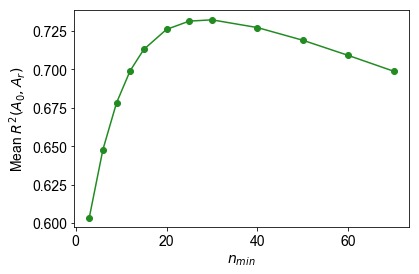

In [167]:
ns = [3,6,9,12,15,20,25,30,40,50,60,70]
plt.plot(ns,cod_A,'o-',color='forestgreen')
plt.xlabel('$n_{min}$')
plt.ylabel('Mean $R^2(A_0,A_r)$')

In [237]:
p1,p2,n=mesh_params
    
resx = p2[0]/n[0] # resolution in m per px 
resy = p2[1]/n[1] # resolution in m per px 
resz = p2[2]/n[2] # resolution in m per px 

resx,resy,resz
res=resx

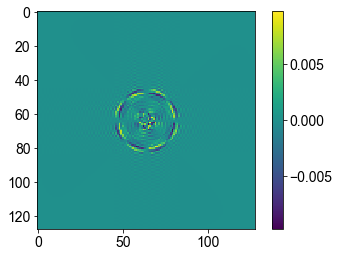

In [211]:
A = [AX,AY,AZ]
Ar = [t1,t2,t3]

def divergence(f,mesh_params):
    """
    Computes the divergence of the vector field f, corresponding to dFx/dx + dFy/dy + ...
    :param f: List of ndarrays, where every item of the list is one dimension of the vector field
    :return: Single ndarray of the same shape as each of the items in f, which corresponds to a scalar field
    """
    p1,p2,n=mesh_params
    
    res = p2[0]/n[0] # resolution in m per px 

    
    
    num_dims = len(f)
    return np.ufunc.reduce(np.add, [np.gradient(f[i],res, axis=i) for i in range(num_dims)])

divA = divergence(A,mesh_params)
plt.imshow(np.mean(divA,axis=2))
plt.colorbar()

In [213]:
vmax,vmin=np.max(AZ[n:-n,n:-n,n+20]),np.min(AZ[n:-n,n:-n,n+20])

TypeError: bad operand type for unary -: 'tuple'

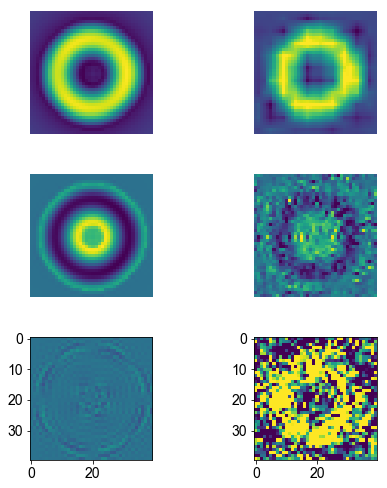

In [218]:
f,axs=plt.subplots(nrows=3,ncols=2,figsize=(7,7))
n=44
vmax,vmin=np.max(AZ[n:-n,n:-n,n+20]),np.min(AZ[n:-n,n:-n,n+20])
axs[0,0].imshow(AZ[n:-n,n:-n,n+20],vmax=vmax,vmin=vmin)
#plt.colorbar()


axs[0,1].imshow(t3[n:-n,n:-n,n+20],vmax=vmax,vmin=vmin)
#plt.colorbar()

curlA = ma.calculate_B_from_A(AX,AY,AZ,mesh_params)[2]
vmax,vmin=np.max(curlA[n:-n,n:-n,n+20]),np.min(curlA[n:-n,n:-n,n+20])
axs[1,0].imshow(curlA[n:-n,n:-n,n+20],vmax=vmax,vmin=vmin)
#plt.colorbar()
curlA = ma.calculate_B_from_A(t1,t2,t3,mesh_params)[2]
#vmax,vmin=np.max(curlA[n:-n,n:-n,n+20]),np.min(curlA[n:-n,n:-n,n+20])
axs[1,1].imshow(curlA[n:-n,n:-n,n+20],vmax=vmax,vmin=vmin)



divA = divergence(A,mesh_params)
#vmax,vmin=np.max(divA[n:-n,n:-n,n+20]),np.min(divA[n:-n,n:-n,n+20])
axs[2,0].imshow(divA[n:-n,n:-n,n+20],vmax=vmax,vmin=vmin)
#plt.colorbar()

divA = divergence(Ar,mesh_params)
axs[2,1].imshow(divA[n:-n,n:-n,n+20],vmax=vmax,vmin=vmin)
#plt.colorbar()

axs[0,0].axis('off')
axs[0,1].axis('off')
axs[1,0].axis('off')
axs[1,1].axis('off')

plt.tight_layout()

In [216]:
np.shape(curlA)

(3, 128, 128, 128)

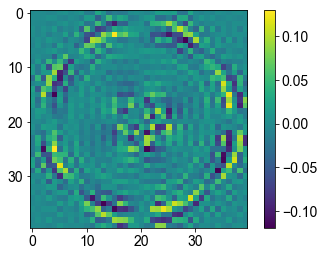

In [225]:

divA = divergence(A,mesh_params)
plt.imshow(divA[n:-n,n:-n,n+20])
plt.colorbar()

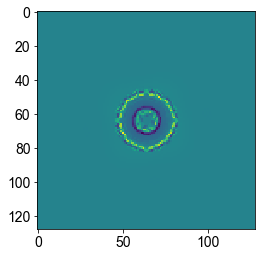

In [185]:
plt.imshow(divA[:,:,n+40])

In [238]:
#https://github.com/shixun22/helmholtz/blob/master/helmholtz.py

Vf = np.array(A)

#if Vf.shape[0]!=3: print 'Not a 3D field in required form!'

NX, NY, NZ = Vf.shape[1:]

Vfx = Vf[0]
Vfy = Vf[1]
Vfz = Vf[2]

vx_f = np.fft.fftn(Vfx)
vy_f = np.fft.fftn(Vfy)
vz_f = np.fft.fftn(Vfz)

kx = np.fft.fftfreq(NX,res).reshape(NX,1,1)
ky = np.fft.fftfreq(NY,res).reshape(NY,1)
kz = np.fft.fftfreq(NZ,res)
k2 = kx**2 + ky**2 + kz**2
k2[0,0,0] = 1. # to avoid inf. we do not care about the k=0 component

div_Vf_f = (vx_f * kx +  vy_f * ky + vz_f * kz) #* 1j
V_compressive_overk = div_Vf_f / k2
V_compressive_x = np.fft.ifftn(V_compressive_overk * kx) #[:,np.newaxis,np.newaxis])
V_compressive_y = np.fft.ifftn(V_compressive_overk * ky)
V_compressive_z = np.fft.ifftn(V_compressive_overk * kz)

V_solenoidal_x = Vfx - V_compressive_x
V_solenoidal_y = Vfy - V_compressive_y
V_solenoidal_z = Vfz - V_compressive_z

# check if the solenoidal part really divergence-free
divVs = np.fft.ifftn((np.fft.fftn(V_solenoidal_x) * kx + np.fft.fftn(V_solenoidal_y) * ky + np.fft.fftn(V_solenoidal_z) * kz) * 1j * 2. * np.pi)

# print 'div_solenoidal max:', abs(divVs).max()

# # check the power in solenoidal and compressive components
# print 'variance:'
# print 'solenoidal x,y,z:', V_solenoidal_x.var(), V_solenoidal_y.var(), V_solenoidal_z.var()
# print 'compressive x,y,z:', V_compressive_x.var(), V_compressive_y.var(), V_compressive_z.var()

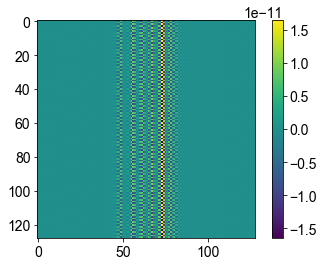

In [252]:
n=44
plt.imshow(V_compressive_x[:,:,n+20].real)
plt.colorbar()

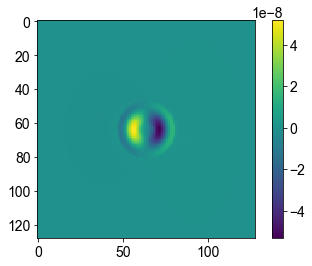

In [251]:
n=44
plt.imshow(V_solenoidal_x[:,:,n+20].real)
plt.colorbar()

In [243]:
np.shape(V_solenoidal_z)

(128, 128, 128)

### Wavelet free recon

In [3]:
[phis_h, angles_h, BX_h,BY_h,BZ_h, mesh_params_h,MX_h,MY_h,MZ_h,AX_h,AY_h,AZ_h ] = np.load(r'Phantoms/hopfion_phantom.npy',allow_pickle=True)
phis = phis_h
angles=angles_h
mesh_params = mesh_params_h

n_pad=44
nmaj=1
nmin=10
#w=3e-3
w=5e-3
th1,th2=.2,.7
BX,BY,BZ=BX_h,BY_h,BZ_h
#AX,AY,AZ = AX_s,AY_s,AZ_s
AX,AY,AZ = AX_h,AY_h,AZ_h

cod_nowav = []
cod_conv = []
cod_wav = []
ns = [3,6,9,12,15,20,25,30,40,50,60,70]

# t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=3, 
#                                                thresh_range=(th1,th2),algorithm='SIRT3D_CUDA',weight=w)

In [ ]:
nn=3
px = phis[:,:10]
py = phis[:,10:]
angx=angles[:10]
angy=angles[10:]
bx_p,by_p = ma.dual_axis_B_generation(px,py,mesh_params)
b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,angx,angy,mesh_params,niter=nn,algorithm='SIRT3D_CUDA',callback_freq=5)

In [4]:
# [phis_s, angles_s, BX_s,BY_s,BZ_s, mesh_params_s,MX_s,MY_s,MZ_s,AX_s,AY_s,AZ_s ] = np.load(r'Phantoms/sphere_phantom.npy',allow_pickle=True)

# phis = phis_s
# angles=angles_s
# mesh_params = mesh_params_s

[phis_h, angles_h, BX_h,BY_h,BZ_h, mesh_params_h,MX_h,MY_h,MZ_h,AX_h,AY_h,AZ_h ] = np.load(r'Phantoms/hopfion_phantom.npy',allow_pickle=True)

phis = phis_h
angles=angles_h
mesh_params = mesh_params_h

n_pad=44
nmaj=1
nmin=10
#w=3e-3
w=5e-3
th1,th2=.2,.7
BX,BY,BZ=BX_h,BY_h,BZ_h
#AX,AY,AZ = AX_s,AY_s,AZ_s
AX,AY,AZ = AX_h,AY_h,AZ_h

cod_nowav = []
cod_conv = []
cod_wav = []
ns = [3,6,9,12,15,20,25,30,40,50,60,70]
for nn in ns:
    t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=nmaj,n_step_iter=nn, 
                                               thresh_range=(th1,th2),algorithm='SIRT3D_CUDA',weight=w)
    b1m,b2m,b3m = ma.calculate_B_from_A(t1,t2,t3,mesh_params=mesh_params)
    n=n_pad
    codx = ma.COD(BX[n:-n,n:-n,n:-n],b1m[n:-n,n:-n,n:-n])
    cody = ma.COD(BY[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n])
    codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n])
    cod = np.mean([codx,cody,codz])
    cod_nowav.append(cod)
    print(nn,cod)
    
    t1,t2,t3=ma.iterative_update_algorithm(phis,angles,mesh_params,n_pad,n_full_iter=2,n_step_iter=nn, 
                                               thresh_range=(th1,.8),algorithm='wavelet_coif1',weight=w)
    b1m,b2m,b3m = ma.calculate_B_from_A(t1,t2,t3,mesh_params=mesh_params)
    n=n_pad
    codx = ma.COD(BX[n:-n,n:-n,n:-n],b1m[n:-n,n:-n,n:-n])
    cody = ma.COD(BY[n:-n,n:-n,n:-n],b2m[n:-n,n:-n,n:-n])
    codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3m[n:-n,n:-n,n:-n])
    cod = np.mean([codx,cody,codz])
    cod_wav.append(cod)
    print(nn,cod)
    
    
    px = phis[:,:10]
    py = phis[:,10:]
    angx=angles[:10]
    angy=angles[10:]
    bx_p,by_p = ma.dual_axis_B_generation(px,py,mesh_params)
    b1d,b2d = ma.dual_axis_reconstruction(bx_p,by_p ,angx,angy,mesh_params,niter=nn,algorithm='SIRT3D_CUDA',callback_freq=5)
    b3d = ma.dual_axis_bz_from_bxby(b1d,b2d)
    n=n_pad
    codx = ma.COD(BX[n:-n,n:-n,n:-n],b1d[n:-n,n:-n,n:-n])
    cody = ma.COD(BY[n:-n,n:-n,n:-n],b2d[n:-n,n:-n,n:-n])
    codz = ma.COD(BZ[n:-n,n:-n,n:-n],b3d[n:-n,n:-n,n:-n])
    cod = np.mean([codx,cody,codz])
    cod_conv.append(cod)
    print(nn,cod)

3 0.3835292752628578
3 0.47856037895201453
3 0.34041566753045654
6 0.37500294335073886
6 0.5119134790318576
6 0.3388745570551985
9 0.36517222800777355
9 0.5215099281639665
9 0.3354527232338782
12 0.35613204304773216
12 0.5191060403556484
12 0.33140269465224165
15 0.34818332673007557
15 0.5106859080013457
15 0.32727392230667607
20 0.33717957230306944
20 0.4923413819038771
20 0.32087427781818084
25 0.3284816962278117
25 0.4733573879925608
25 0.31542815694149823
30 0.32157875045668316
30 0.45497178240354125
30 0.3109875157616991
40 0.31167782397838195
40 0.4221389819032275
40 0.304668948853563
50 0.3053080713211133
50 0.394710788328279
50 0.30081873435053263
60 0.30115460732000593
60 0.370748523273894
60 0.29851157178413273
70 0.2984012226608961
70 0.35109620158107574
70 0.29713592546119005


Text(0, 0.5, 'Mean $R^2(B_0,B_r)$')

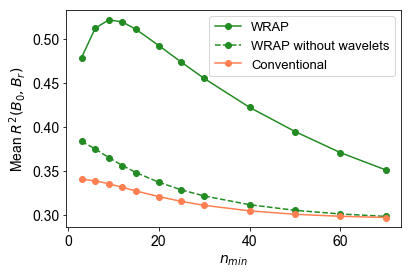

In [10]:
import matplotlib
# Set font and colormap for plotting
font = {'family':'sans-serif','sans-serif':['Arial'],
        'size'   : 14}
matplotlib.rc('font', **font)


plt.plot(ns,cod_wav,'o-',color='forestgreen',label='WRAP')
plt.plot(ns,cod_nowav,'o--',color='forestgreen',label='WRAP without wavelets')
plt.plot(ns,cod_conv,'o-',color='coral',label='Conventional')
plt.legend(fontsize=13)
plt.xlabel('$n_{min}$')
plt.ylabel('Mean $R^2(B_0,B_r)$')